<h1>Lorenzo Severini: <br> 
    Attention analysis and cosine similarity analysis of present and dropped mentions in Italian coreference dataset</h1>

<h2>Italian Language Models</h2>

In this notebook I use and compare four Italian language models. The model's names are in the list that follows, in parentheses I specify, for each model, the type of tokeniser used, the pre-training objective, the pre-training corpus, and the architecture used.

- [UmBERTo](https://github.com/musixmatchresearch/umberto): (SentencePiece tokeniser, Whole Word Masking (WWM), common-crawl/wikipedia, RoBERTa based) <br>two versions: i) trained on CommonCrawl (via OSCAR) and ii) trained on Wikipedia; the former is trained on a large corpus while the latter on a small corpus. 
- [GilBERTo](https://github.com/idb-ita/GilBERTo): (SentencePiece tokeniser, Subword Masking (MLM), OSCAR(web-crawl), RoBERTa based)
- [AlBERTo](https://github.com/marcopoli/AlBERTo-it): (Ekphrasis + SentencePiece tokeniser, Subword Masking (MLM), tweets, BERT based)

All models have the same number of layers and heads (12, 12) and hidden size (768), with \~110M parameters.

In [4]:
## import models and tokenisers

from transformers import AutoTokenizer, AutoModel
# AutoTokenizer automatically retrieves the model's configuration, pre-trained weights, vocabulary, etc.

model_names = ["bert-base-uncased",
               "Musixmatch/umberto-commoncrawl-cased-v1",
                "Musixmatch/umberto-wikipedia-uncased-v1",
                "idb-ita/gilberto-uncased-from-camembert",
                "m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0"]

simple_names = ["BERT",
                "UmBERToCC",
                "UmBERToW",
                "GilBERTo",
                "AlBERTo"]

# store (name,tokeniser,model) tuples
model_pairs = [] 
m = 0

for name in model_names:
    model_name = name

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name, 
                                      output_attentions=True, 
                                      attn_implementation="eager")
    model_pairs.append((name,tokenizer,model,simple_names[m]))
    m+=1
    

print("Models list:")
count = 0
for model in model_pairs:
    print(f"n.{count} {model[0]}")
    count+=1

Models list:
n.0 bert-base-uncased
n.1 Musixmatch/umberto-commoncrawl-cased-v1
n.2 Musixmatch/umberto-wikipedia-uncased-v1
n.3 idb-ita/gilberto-uncased-from-camembert
n.4 m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0


<h2>Italian coreference dataset</h2>

<h3>Live Memories Corpus</h3>

*Anaphoric Annotation of Wikipedia and Blogs in the Live Memories Corpus* ([Rodriguez et al. 2010](http://www.lrec-conf.org/proceedings/lrec2010/summaries/431.html))

The Live Memory Corpus is a corpus of Italian texts annotated for anaphoric relations. The texts come from Italian Wikipedia articles (specifically about Trentino region) and from users' comments on internet blogs. Annotations are manually added and comprehend: morphosyntactic agreement, anaphoricity, semantic class of Nominal Phrases, etc. In annotating anaphoric links the corpus also deals with specific phenomena of the Italian language, i.e., phonetically non-realised pronouns and incorporated clitics. (adapted from the paper's abstract)

<h3>Processing dataset</h3>

Columns values:

column index -- meaning

1. -- token ID
2. -- token (surface form)
3. -- empty
4. -- lemma
5. -- empty
6. -- POS tag or syntactic class
7. -- empty
8. -- morphological features
9. -- empty
10. -- dependency head index: token the word depends on (0==root)
11. -- empty
12. -- dependency relation
13. -- ontological type
14. -- empty
15. -- empty 
16. -- empty
17. -- coreference annotation1
18. -- coreference annotation2 (duplicate or parallel coreference annotation)
19. -- coreference chain clustering indicator

**coreference annotation** describes: mention ID, coreference set, mention type (e.g. nominal), semantic class (e.g. person), and whether it's the beginning (B-MIN) or inside (I-MIN) of a mention.<br>
**coreference chain clustering indicator** marks which mentions belong to the same coreference cluster (same index), i.e., which mentions refer to the same entity; and marks the start and end of a coreference mention span (opened and closed parentheses).

If a subject is dropped then the mention is marked onto the verb, this allows to later extract mentions that are instances of pro-drop.

In [1]:
"""
the lines in this code block are to be run separately:
    - first line saves the current dataframe to kaggle's working directory, from where it can be downloaded and added to the notebook's datasets 
    - second line loads a dataframe from one of the uploaded datasets: this is necessary so that the preprocessed dataframe is quickly accessible
        e.g., in coref_df_tf: i) all pre-processing has been done, ii) cosine similarity for the 4 models has been processed for the 3 different scenarios
"""

# save dataframe for future quick access
coref_df_tf.to_csv("/kaggle/working/coref_df_tf_processed+cosine-sim_Ucc-Uw-G-A.csv", index=False)

# quick access of dataframe: download from imported dataframes
# this dataframe does not need to be worked at all, all processing has been carried out: start from create split cell
import pandas as pd
df = pd.read_csv("/kaggle/input/lmc-final-processed-with-cosine-similarity/coref_df_tf_processedcosine-sim_Ucc-Uw-G-A.csv")
df.head(3)

coref_df_tf = df.copy()
coref_df = coref_df_tf[coref_df_tf['label']==1]
#coref_df_tf = coref_df_tf.drop('column_name', axis=1) # in case a column needs to be dropped


# count how many NaN values there are per column in the dataframe
#print(coref_df_tf.isna().sum())
# count how many antecedent and mention are the same
#print((coref_df_tf['antecedent'] == coref_df_tf['mention']).sum())

In [1]:
## import dataset, assign column names, create sentence_id column
## sentence_id is needed to group sentences together which will be the examples of the dataframe later

import pandas as pd

# filepath = "/kaggle/input/document-wp-0105/document-wp_0105.txt" # small sample (1 document)
filepath = "/kaggle/input/livememorycorpus/it-train.v3amin.txt"

column_names = [
    'token_id',             # id for each token in sentence
    'word',                 # token surface form
    'ph1',                  # (empty)
    'lemma',                # token lemma form
    'ph2',                  # (empty)
    'pos',                  # POS / syntactic class
    'ph3',                  # (empty)
    'morpho_features',      # morphological features
    'ph4',                  # (empty)
    'dep_head_id',          # dependency head index
    'ph5',                  # (empty)
    'dep_rel',              # dependency relation
    'onto_type',            # ontological type
    'ph6',                  # (empty)
    'ph7',                  # (empty)
    'ph8',                  # (empty)
    'coref_col1',           # main coreference annotation
    'coref_col2',           # alternate annotation or adjudicated
    'coref_chain_info'      # coreference chain indicator
]

df = pd.read_csv(
    filepath,
    sep="\t",
    names=column_names,
    comment="#", # skips lines starting with #
    engine="python",
    encoding="latin1",
    quoting=3, # disable quote parsing
    dtype=str # treat everything as string
)

df['token_id'] = pd.to_numeric(df['token_id'], errors="coerce") # convert token column to int
#df['Dep_Head_ID'] = pd.to_numeric(df['Dep_Head_ID'], errors="coerce")

# create a sentence_id column to group the sentences
# token_id==1 marks the start of a new sentence 
df['sentence_id'] = (df['token_id'] == 1).cumsum() - 1 
# reorder columns
cols = df.columns.tolist()
cols.insert(1, cols.pop(cols.index('sentence_id')))
df = df[cols]

df.head(10)

token_id  sentence_id            word ph1           lemma ph2   pos ph3  \
0         1            0          Castel   _          castel   _   SPN   _   
1         2            0           Ivano   _           ivano   _   SPN   _   
2         1            1          Castel   _          castel   _   SPN   _   
3         2            1           Ivano   _           ivano   _   SPN   _   
4         3            1               è   _          essere   _    VI   _   
5         4            1             una   _              un   _    RS   _   
6         5            1  fortificazione   _  fortificazione   _    SS   _   
7         6            1             che   _             che   _  CCHE   _   
8         7            1              si   _              si   _    PN   _   
9         8            1            erge   _          ergere   _    VI   _   

                  morpho_features ph4 dep_head_id ph5       dep_rel  \
0                          _null_   _           0   _          ROOT   
1                          _null_   _           1   _  CONTIN-DENOM   
2                          _null_   _           3   _          SUBJ   
3                          _null_   _           1   _  CONTIN-DENOM   
4  essere+v+indic+pres+nil+3+sing   _           0   _          ROOT   
5                indet+art+f+sing   _           5   _           DET   
6         fortificazione+n+f+sing   _           3   _          PRED   
7                        che+conj   _           8   _          SUBJ   
8     rifl+pron+accdat+_+3+_+clit   _           8   _          DOBJ   
9  ergere+v+indic+pres+nil+3+sing   _           5   _         RELCL   

   onto_type ph6 ph7 ph8                          coref_col1  \
0  (facility   _   _   _  B-M_1=set_2=nominal=facility=B-MIN   
1  facility)   _   _   _  I-M_1=set_2=nominal=facility=I-MIN   
2  (facility   _   _   _  B-M_3=set_2=nominal=facility=B-MIN   
3  facility)   _   _   _  I-M_3=set_2=nominal=facility=I-MIN   
4          _   _   _   _                                   O   
5          _   _   _   _     B-M_5=set_29=nominal=null=B-MIN   
6          _   _   _   _     I-M_5=set_29=nominal=null=I-MIN   
7          _   _   _   _     I-M_5=set_29=nominal=null=I-MIN   
8          _   _   _   _     I-M_5=set_29=nominal=null=I-MIN   
9          _   _   _   _     I-M_5=set_29=nominal=null=I-MIN   

                           coref_col2 coref_chain_info  
0  B-M_1=set_2=nominal=facility=B-MIN               (1  
1  I-M_1=set_2=nominal=facility=I-MIN               1)  
2  B-M_3=set_2=nominal=facility=B-MIN               (1  
3  I-M_3=set_2=nominal=facility=I-MIN               1)  
4                                   O                _  
5     B-M_5=set_30=nominal=null=B-MIN               (2  
6     I-M_5=set_30=nominal=null=I-MIN                _  
7     I-M_5=set_30=nominal=null=I-MIN                _  
8     I-M_5=set_30=nominal=null=I-MIN                _  
9     I-M_5=set_30=nominal=null=I-MIN                _

In [2]:
# clean dataframe (drop empty columns)

drop_columns = ['ph1', 'ph2', 'ph3', 'ph4', 'ph5', 'ph6', 'ph7', 'ph8', ]

for c in drop_columns: 
    df = df.drop(c, axis=1)

In [4]:
## process dataframe
    # add true examples: tracking of coreference chains in same sentence;
    # add false examples: random sampling from the sentence's other chain's spans; 
    # prioritise V mentions in false examples.
    # oversample the false examples, later pruning is carried out
## output is a dataframe that contains i) the sentence, ii) the antecedent and mention contained, 
#                                    iii) whether the mention is a true or false mention, and iv) whether the mention is from pro-drop

import pandas as pd
import string
import re
import random

RNG = random.Random(42)

def rebuild_sentence(tokens):
    """
    Rebuilds a sentence with the right formatting (using the right spacing before and after punctuation).
    """
    sentence = ""
    for i, token in enumerate(tokens):
        if token is None:
            token = ""

        # no space before closing punctuation or sentence-final punctuation
        if token in [".", ",", ";", ":", "!", "?", ")", "»", "]"]:
            sentence += token

        # no space after opening punctuation
        elif i > 0 and tokens[i - 1] in ["(", "«", "["]:
            sentence += token

        # no space around apostrophes
        elif token.startswith("'") or (i > 0 and tokens[i - 1].endswith("'")):
            sentence += token

        else:
            if sentence:
                sentence += " "
            sentence += token
    return sentence


def process_coref_dataframe(df):
    """
    Goes through the dataframe and extracts:
        the sentence, 
        the antecedent and the mention (processed with info from 'coref_chain_info'),
        whether the mention is instance of pro-drop (whether POS of word of interest is =='V')
    """
    output = []
    current_sentence = []
    current_corefs = {}
    sentence_tokens = []

    def get_spans(mentions):
        starts, ends = [], []
        for m in mentions:
            if isinstance(m, tuple):
                if m[0] == 'start': starts.append(m[1])
                if m[0] == 'end': ends.append(m[1])
            else:
                starts.append(m)
                ends.append(m)
        return list(zip(starts, ends))
    
        
    for i, row in df.iterrows():
        token_id = int(row['token_id'])
        word = row['word']
        pos = row['pos']
        coref = row['coref_chain_info']

        # handle sentence splitting
        if token_id == 1 and sentence_tokens:
            sentence_text = rebuild_sentence(sentence_tokens)

            # build spans for all coreference chains
            all_spans = {cid: get_spans(mentions) for cid, mentions in current_corefs.items()}

            # process each chain (positives + negatives)
            for chain_id, spans in all_spans.items():
                if len(spans) >= 2:
                    antecedent_span = spans[0]
                    
                    for mention_span in spans[1:]:
                        # antecedent tokens (same for both examples)
                        ant_tokens = [t if t is not None else "" for t in sentence_tokens[antecedent_span[0]:antecedent_span[1]+1]]
                    
                        # TRUE mention tokens and POS check
                        men_tokens = [t if t is not None else "" for t in sentence_tokens[mention_span[0]:mention_span[1]+1]]
                        mention_idx = i - len(sentence_tokens) + mention_span[0]
                        mention_pos = df.iloc[mention_idx]['pos']
                        is_dropped = mention_pos.startswith("V")
                    
                        # TRUE example
                        output.append({
                            'text': sentence_text,
                            'antecedent': rebuild_sentence(ant_tokens),
                            'mention': rebuild_sentence(men_tokens),
                            'dropped_subject': is_dropped,
                            'label': 1
                        })
                    
                        # FALSE example — same antecedent, but different mention (from a different coref chain)
                        # build a list of all false mention spans (other chains)
                        false_candidates = []
                        for other_chain_id, other_spans in all_spans.items():
                            if other_chain_id == chain_id or not other_spans:
                                continue
                            false_candidates.extend(other_spans)
                        
                        # remove duplicate spans 
                        false_candidates = list({(s, e): None for (s, e) in false_candidates}.keys())
                        
                        # sample 2 random false mentions without replacement
                        num_neg = min(2, len(false_candidates))
                        
                        # prioritize dropped subject candidates (POS starts with "V")
                        verb_candidates = []
                        non_verb_candidates = []
                        for s, e in false_candidates:
                            idx = i - len(sentence_tokens) + s
                            pos_tag = df.iloc[idx]['pos']
                            (verb_candidates if pos_tag.startswith("V") else non_verb_candidates).append((s, e))
                        
                        # sample more from verb_candidates if available
                        n_verb = min(num_neg, len(verb_candidates))
                        n_nonverb = num_neg - n_verb
                        
                        sampled_false = []
                        if n_verb > 0:
                            sampled_false += RNG.sample(verb_candidates, k=n_verb)
                        if n_nonverb > 0 and len(non_verb_candidates) >= n_nonverb:
                            sampled_false += RNG.sample(non_verb_candidates, k=n_nonverb)


                        for false_mention_span in sampled_false:
                            false_mention_tokens = [
                                t if t is not None else ""
                                for t in sentence_tokens[false_mention_span[0]:false_mention_span[1]+1]
                            ]
                            false_mention_idx = i - len(sentence_tokens) + false_mention_span[0]
                            false_mention_pos = df.iloc[false_mention_idx]['pos']
                            is_dropped_false = false_mention_pos.startswith("V")
                        
                            output.append({
                                'text': sentence_text,
                                'antecedent': rebuild_sentence(ant_tokens),
                                'mention': rebuild_sentence(false_mention_tokens),
                                'dropped_subject': is_dropped_false,
                                'label': 0
                            })


            
            # reset for new sentence
            sentence_tokens = []
            current_corefs = {}

        sentence_tokens.append(word)
        
        # coreference parsing
        if pd.notna(coref) and coref != "_":
            for item in coref.split("|"):
                item = item.strip()
                if item.startswith('(') and item.endswith(')'):
                    cid = item[1:-1]
                    current_corefs.setdefault(cid, []).append(len(sentence_tokens) - 1)
                elif item.startswith('('):
                    cid = item[1:]
                    current_corefs.setdefault(cid, []).append(('start', len(sentence_tokens) - 1))
                elif item.endswith(')'):
                    cid = item[:-1]
                    current_corefs.setdefault(cid, []).append(('end', len(sentence_tokens) - 1))

    # handle last sentence
    if sentence_tokens:
        sentence_text = rebuild_sentence(sentence_tokens)
        all_spans = {cid: get_spans(mentions) for cid, mentions in current_corefs.items()}

        for chain_id, spans in all_spans.items():
            if len(spans) >= 2:
                antecedent_span = spans[0]
                
                # true mention
                for mention_span in spans[1:]:
                    ant_tokens = sentence_tokens[antecedent_span[0]:antecedent_span[1]+1]
                    men_tokens = sentence_tokens[mention_span[0]:mention_span[1]+1]
                    mention_pos = df.iloc[i - len(sentence_tokens) + mention_span[0]]['pos']
                    dropped = mention_pos.startswith("V")
                    output.append({
                        'text': sentence_text,
                        'antecedent': rebuild_sentence(ant_tokens),
                        'mention': rebuild_sentence(men_tokens),
                        'dropped_subject': dropped,
                        'label': 1
                    })

                    # false mention
                    false_candidates = []
                    for other_chain_id, other_spans in all_spans.items():
                        if other_chain_id == chain_id or not other_spans:
                            continue
                        false_candidates.extend(other_spans)
                    
                    false_candidates = list({(s, e): None for (s, e) in false_candidates}.keys())
                    
                    num_neg = min(2, len(false_candidates))
                    sampled_false = RNG.sample(false_candidates, k=num_neg) if num_neg > 0 else []
                    
                    for false_mention_span in sampled_false:
                        false_mention_tokens = [
                            t if t is not None else ""
                            for t in sentence_tokens[false_mention_span[0]:false_mention_span[1]+1]
                        ]
                        false_mention_idx = i - len(sentence_tokens) + false_mention_span[0]
                        false_mention_pos = df.iloc[false_mention_idx]['pos']
                        is_dropped_false = false_mention_pos.startswith("V")
                    
                        output.append({
                            'text': sentence_text,
                            'antecedent': rebuild_sentence(ant_tokens),
                            'mention': rebuild_sentence(false_mention_tokens),
                            'dropped_subject': is_dropped_false,
                            'label': 0
                        })

    
    return pd.DataFrame(output)


coref_df_tf = process_coref_dataframe(df)
print(coref_df_tf['label'].value_counts())
coref_df_tf.head(5)

label
0    5203
1    2609
Name: count, dtype: int64


text  \
0  Ritenuto famoso per il rarissimo esempio in re...   
1  Ritenuto famoso per il rarissimo esempio in re...   
2  Ritenuto famoso per il rarissimo esempio in re...   
3  Il primo documento storico è datato 1187 e rig...   
4  Il primo documento storico è datato 1187 e rig...   

                   antecedent  \
0                      appare   
1                      appare   
2                      appare   
3  Il primo documento storico   
4  Il primo documento storico   

                                             mention  dropped_subject  label  
0                                           presenta             True      1  
1                                            regione            False      0  
2  il rarissimo esempio in regione di cammino di ...            False      0  
3                                           riguarda             True      1  
4                                il Signore di Ivano            False      0

The previous code cell works on the original dataset and processes it into a dataframe which can be used later for attention patterns visualisation, probing classifier training, cosine similarity visualisation.

The original dataset contains one word per row, with different columns specifying different characteristics of each word. The sentences are rebuilt in order to have one sentence per row in the output dataframe: this is done by keeping track of the token's indices, in fact, each time a new sentence starts, the token index is equal to 1. Coreference chains are then extracted between the words in the sentence thanks to the information on coreference chains and spans contained in the original dataset. Each row in the processed dataframe will eventually contain one sentence, one antecedent, and one mention referring back to the antecedent. <br>
Mentions can either be present or dropped: present mentions are the prototypical case and are NPs which refer back to an antecedent with which they stand in a coreference relationship; dropped mentions are typical in Italian, a language where subjects can be dropped, and are collected by considering the verb which contains, in its span, the dropped mention. The column **'dropped_subject'** reflects, with a boolean value, whether a mention is a dropped mention (True) or a present mention (False). <br>
In order to create a balanced dataset with true and false examples, the mentions are collected both from words (or spans) which stand in a coreference relationship to an antecedent, and from words (or spans) which belong do different coreference chains, thus having no connection to the antecedent. The column **'label'** indicates, with a boolean value, whether the mention correctly refers back to the antecedent (True) or whether it does not refer back to the antecedent (False). 

Important to note is that I chose to retrieve false mentions pooling at random from the non-referring mentions in the sentence: choosing at random allows for false mentions to always have different positions, thus not biasing the model's predictions as it could happen in the case in which they were always found in similar positions in the sentences (e.g., at the beginning if taking always the first one, or at the end if taking the last one). While creating the false examples, I also chose to favour pooling of dropped mentions, i.e., mentions which were marked on verbs, in order to later reach a balance between true dropped mentions and false dropped mentions. <br>
Oversampling false examples was key at this point in order to get as balanced a dataset as possible at the end. In fact, not all false examples are perfect and further cleaning of the dataset reduces their number drastically. Before carrying out attention visualisation and the training of the classifier excess examples are pruned away.

In [6]:
## visualisation of balance of non-dropped and dropped mentions between true and false labels (oversampling in false labels) 

coref_df = coref_df_tf[coref_df_tf['label'] == 1].copy()
coref_df_f = coref_df_tf[coref_df_tf['label'] == 0].copy()
print(f"Distribution in true labels:\n{coref_df['dropped_subject'].value_counts()}\n")
print(f"Distribution in false labels:\n{coref_df_f['dropped_subject'].value_counts()}")

Distribution in true labels:
dropped_subject
False    1988
True      621
Name: count, dtype: int64

Distribution in false labels:
dropped_subject
False    4435
True      768
Name: count, dtype: int64


It can be seen that the dataset is now unbalanced towards false examples. These will be later reduced by further cleaning the examples and by final pruning of excess examples. What is important is that true dropped mentions and false dropped mentions, which have relatively few examples, are balanced between themselves.

In [7]:
## add positional information for antecedent and mention 

import pandas as pd
import re

def get_all_offsets(text, substring):
    """
    Checks all occurrences of target in text. 
    """
    return [m.start() for m in re.finditer(re.escape(substring), text)]

def expand_with_offsets(df):
    """
    Goes through the dataset and gets information regarding offset of antecedent and mention (all occurrences in text).
    """
    expanded_rows = []
    for _, row in df.iterrows():
        sentence = row['text']
        antecedent = row['antecedent']
        mention = row['mention']
        label = row['label']
        dropped = row.get('dropped_subject', None)

        ant_offsets = get_all_offsets(sentence, antecedent)
        men_offsets = get_all_offsets(sentence, mention)

        if not ant_offsets:
            print(f"[Row {idx}] Antecedent '{antecedent}' not found in sentence:\n{sentence}\n")
        if not men_offsets:
            print(f"[Row {idx}] Mention '{mention}' not found in sentence:\n{sentence}\n")

        for ant_offset in ant_offsets:
            for men_offset in men_offsets:
                expanded_rows.append({
                    'text': sentence,
                    'antecedent': antecedent,
                    'mention': mention,
                    'label': label,
                    'antecedent_offset': ant_offset,
                    'mention_offset': men_offset,
                    'dropped_subject': dropped
                })

    return pd.DataFrame(expanded_rows)

coref_df = expand_with_offsets(coref_df)
#coref_df.head(5)

coref_df_tf = expand_with_offsets(coref_df_tf)
print(coref_df_tf['label'].value_counts())
coref_df_tf.head(5)

label
0    6152
1    3761
Name: count, dtype: int64


text  \
0  Ritenuto famoso per il rarissimo esempio in re...   
1  Ritenuto famoso per il rarissimo esempio in re...   
2  Ritenuto famoso per il rarissimo esempio in re...   
3  Il primo documento storico è datato 1187 e rig...   
4  Il primo documento storico è datato 1187 e rig...   

                   antecedent  \
0                      appare   
1                      appare   
2                      appare   
3  Il primo documento storico   
4  Il primo documento storico   

                                             mention  label  \
0                                           presenta      1   
1                                            regione      0   
2  il rarissimo esempio in regione di cammino di ...      0   
3                                           riguarda      1   
4                                il Signore di Ivano      0   

   antecedent_offset  mention_offset  dropped_subject  
0                 73             107             True  
1                 73              44            False  
2                 73              20            False  
3                  0              43             True  
4                  0              52            False

In [8]:
## add string label 

coref_df_tf['label_str'] = coref_df_tf['label'].map({
    1: 'True-mention',
    0: 'False-mention'
})

coref_df_tf['dropped_subject_str'] = coref_df_tf['dropped_subject'].map({
    True: 'Dropped',
    False: 'Non-Dropped'
})


## reorder columns
cols = coref_df_tf.columns.tolist()
cols.insert(7, cols.pop(cols.index('dropped_subject_str')))
cols.insert(1, cols.pop(cols.index('antecedent_offset')))
cols.insert(3, cols.pop(cols.index('mention_offset')))
cols.insert(6, cols.pop(cols.index('label_str')))
coref_df_tf = coref_df_tf[cols]
coref_df_tf.head(1)

text  antecedent_offset  \
0  Ritenuto famoso per il rarissimo esempio in re...                 73   

  antecedent  mention_offset   mention  label     label_str  dropped_subject  \
0     appare             107  presenta      1  True-mention             True   

  dropped_subject_str  
0             Dropped

In the previous two code cells I extracted offset information for both antecedent and mention in all examples in the dataframe. This is an information needed later in the pipeline for training the probing classifier on the data. I also reordered the columns of the dataframe in order to have a neater and easier to read dataframe. Finally I added two columns which translated in string values the labels columns: these translate the 'label' column into 'True-mention' or 'False-mention', and the 'dropped_subject' column into 'Dropped' and 'Non-Dropped'. The string labels are needed later for an easier interpretation of the experiments' results when plotted in the graphs. 

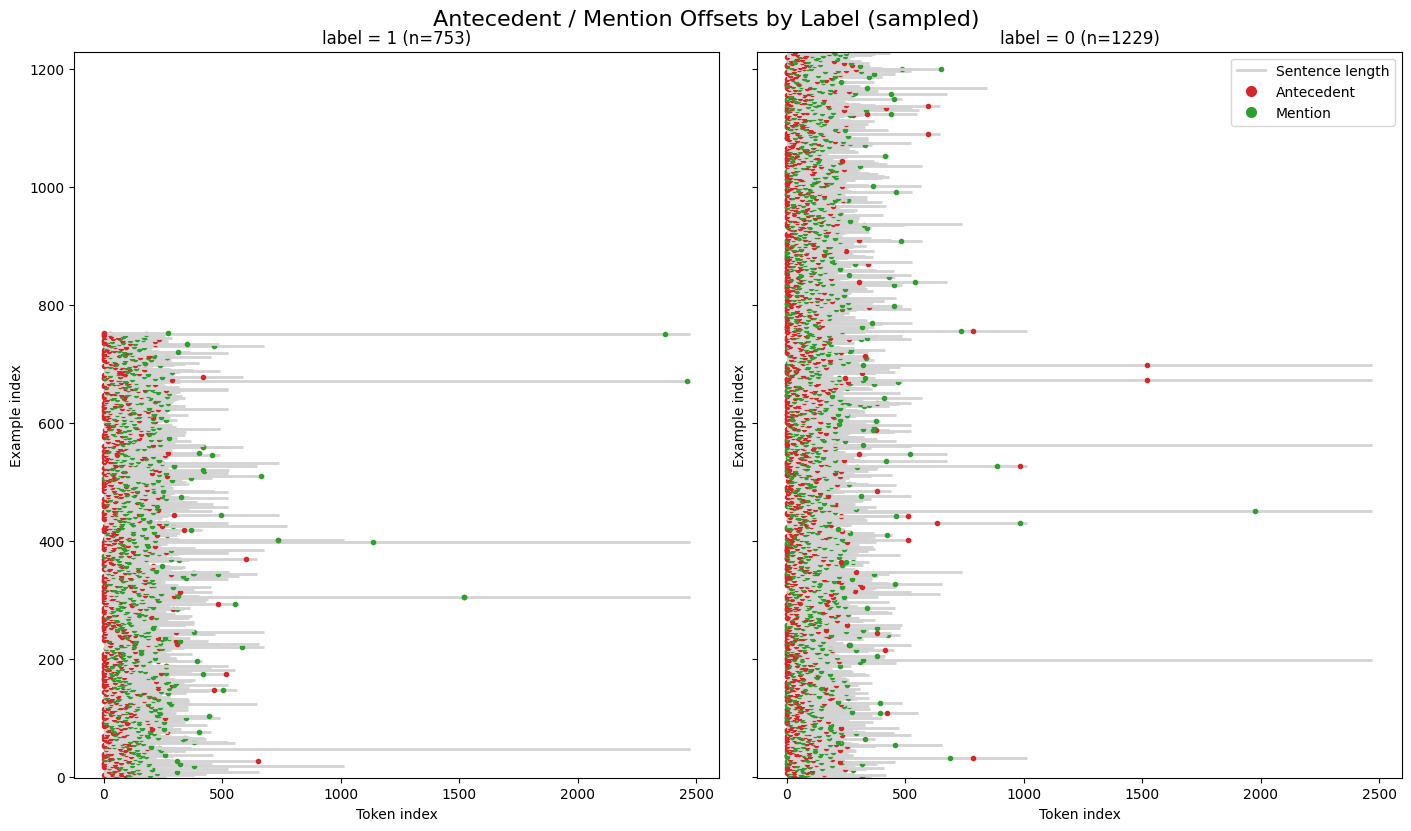

In [9]:
## graph visualisation of length of sentences and relative position of antecedent and mention throughout the dataframe, divided in true mentions and false mentions

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D

df = coref_df_tf.copy()
df["text_len"] = df["text"].apply(len)

# sample to keep plot readable
max_examples = len(df)//5
sampled = df.sample(n=min(len(df), max_examples), random_state=42).reset_index(drop=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharex=True, sharey=True, constrained_layout=True)
label_values = [1, 0]
label_titles = {1: "label = 1", 0: "label = 0"}
marker_colors = {"antecedent": "tab:red", "mention": "tab:green"}

for ax, lbl in zip(axes, label_values):
    subset = sampled[sampled["label"] == lbl].reset_index(drop=True)
    for i, (_, row) in enumerate(subset.iterrows()):
        length = row["text_len"]
        a_off = row["antecedent_offset"]
        m_off = row["mention_offset"]

        # baseline sentence length
        ax.hlines(y=i, xmin=0, xmax=length, color="lightgray", linewidth=2)

        # antecedent marker (vertical tick)
        if pd.notna(a_off):
            ax.plot(a_off, i, marker=".", markersize=6, color=marker_colors["antecedent"])

        # mention marker (underscore)
        if pd.notna(m_off):
            ax.plot(m_off, i, marker=".", markersize=6, color=marker_colors["mention"])

    ax.set_title(f"{label_titles[lbl]} (n={len(subset)})")
    ax.set_xlabel("Token index")
    ax.set_ylabel("Example index")
    ax.set_ylim(-1, max(len(subset), 1))  # ensure visible

# shared legend
legend_elements = [
    Line2D([0], [0], color="lightgray", lw=2, label="Sentence length"),
    Line2D([0], [0], marker=".", color=marker_colors["antecedent"], linestyle="None", markersize=14, label="Antecedent"),
    Line2D([0], [0], marker=".", color=marker_colors["mention"], linestyle="None", markersize=14, label="Mention"),
]
axes[-1].legend(handles=legend_elements, loc="upper right")

fig.suptitle("Antecedent / Mention Offsets by Label (sampled)", fontsize=16, y=1.02)
plt.show()

Looking at a sample of the examples, it is clear that most of the antecedents' offsets are located towards the beginning of the sentences, both in the true and false examples, and that most of the mentions's offsets follow the antecedents. What is important here is that the false mentions distribution, which is composed of examples created automatically, mimics the true mentions distribution, in order to see whether the model can actually differentiate between the two.

In [11]:
## check whether there is imbalance given by antecedet-mention order  

print("Balance of position of antecedent and mention (before)")
true_df = coref_df_tf[coref_df_tf['label'] == True]
false_df = coref_df_tf[coref_df_tf['label'] == False]

am = (true_df['antecedent_offset'] > true_df['mention_offset']).sum()
ma = (true_df['antecedent_offset'] < true_df['mention_offset']).sum()
print(f"True: ant>men: {am} -- ant<ment: {ma}")

am = (false_df['antecedent_offset'] > false_df['mention_offset']).sum()
ma = (false_df['antecedent_offset'] < false_df['mention_offset']).sum()
print(f"False: ant>men: {am} -- ant<ment: {ma}")

# loop over dataframe and swap antecedent and mention labels if antecedent_offset>mention_offset
for i,row in coref_df_tf.iterrows():
    if row['antecedent_offset'] > row['mention_offset']:
        mention = row['mention']
        mention_offset = row['mention_offset']
        antecedent = row['antecedent']
        antecedent_offset = row['antecedent_offset']
        coref_df_tf.at[i, 'mention'] = antecedent
        coref_df_tf.at[i, 'mention_offset'] = antecedent_offset
        coref_df_tf.at[i, 'antecedent'] = mention
        coref_df_tf.at[i, 'antecedent_offset'] = mention_offset


print("\nBalance of position of antecedent and mention (after)")
true_df = coref_df_tf[coref_df_tf['label'] == True]
false_df = coref_df_tf[coref_df_tf['label'] == False]

am = (true_df['antecedent_offset'] > true_df['mention_offset']).sum()
ma = (true_df['antecedent_offset'] < true_df['mention_offset']).sum()
print(f"True: ant>men: {am} -- ant<ment: {ma}")

am = (false_df['antecedent_offset'] > false_df['mention_offset']).sum()
ma = (false_df['antecedent_offset'] < false_df['mention_offset']).sum()
print(f"False: ant>men: {am} -- ant<ment: {ma}")

Balance of position of antecedent and mention (before)
True: ant>men: 346 -- ant<ment: 2380
False: ant>men: 1223 -- ant<ment: 2597

Balance of position of antecedent and mention (after)
True: ant>men: 0 -- ant<ment: 2726
False: ant>men: 0 -- ant<ment: 3820


An analysis of the count of examples where the antecedent follows the mention has shown imbalance between true and false labels. After a visual analysis of examples coming from the two distributions I decided to edit, in both distributions, cases where the antecedent had an offset greater than the offset of the mention, eventually swapping the two elements. In this way, both true and false distributions only have antecedents that precede the mentions. 

In [14]:
## visualisation of problematic examples

examples = [5,8,13,16]

for n in examples:
    for i, row in coref_df[n:n+1].iterrows():
        print(f"index: {i}.")
        print(f"sentence: {row['text']}")
        print(f"antecedent: {row['antecedent']}")
        print(f"mention: {row['mention']}")
        print(f"pro-drop: {row['dropped_subject']}")
        print("----------------")

index: 15.
sentence: Il castello, passato come feudo alla famiglia Wolkenstein, allo scoppio della Prima Guerra Mondiale venne abbandonato dalla stessa famiglia, e venne occupato dal Comando delle truppe italiane in Valsugana.
antecedent: Il castello, passato come feudo alla famiglia Wolkenstein
mention: venne
pro-drop: True
----------------
index: 18.
sentence: Il castello, passato come feudo alla famiglia Wolkenstein, allo scoppio della Prima Guerra Mondiale venne abbandonato dalla stessa famiglia, e venne occupato dal Comando delle truppe italiane in Valsugana.
antecedent: Il castello, passato come feudo alla famiglia Wolkenstein
mention: venne
pro-drop: True
----------------
index: 34.
sentence: L'ingresso del complesso, quello più antico, era situato verso il paese e vi si poteva accedere grazie ad una torre di guardia, ancora oggi esistente, su cui vi risiedono gli stemmi dei vari casati: i Trapp, i Capitani Tirolesi, i Conti del Tirolo, gli Scaligeri, i Da Carrara e i Wolkenstei

A visual analysis of a sample of texts shows that the dataframe created has some flaws (examples above). <br>
In order to keep it as clean as possible I am deleting all examples with mentions which have a span longer than 3 tokens (examples 13 and 16), and I am keeping, in antecedents and mentions that have a comma (which in most cases is given by a relative sentence adding attributes to the mention), only the words that precede it, thus hopefully preserving the correct element and not other attributes (examples 5 and 8).

In [10]:
## drop too long mentions + keep only strings before comma in antecedents and mentions

def clean_examples(df,title):
    """
    Iterates through the dataframe and:
        if mention text has a comma, it keeps only the text before the comma
        if mention text is longer than 3 words, it delets the whole example 
        if antecedent text has a comma, it keeps only the text before the comma
    """
    lenght_pre = len(df)
    to_drop = []

    for i,row in df.iterrows():
        # keep only text before comma in mention text
        if "," in row['mention']:
            new_text = row['mention'].split(",")[0]
            df.at[i, 'mention'] = new_text

        # keep only mentions shorter or equal than 3 words
        if len(row['mention'].split()) > 3:
            to_drop.append(i)

        # keep only text before comma in antecedent text
        elif "," in row['antecedent']:
            new_text = row['antecedent'].split(",")[0]
            df.at[i, 'antecedent'] = new_text

    df = df.drop(to_drop).reset_index(drop=True)
    print(f"Examples dropped {title}: {lenght_pre-len(df)}")
    return(df)

coref_df = clean_examples(coref_df,"'coref-df only true'")
coref_df_tf = clean_examples(coref_df_tf,"'coref-df true+false'")

Examples dropped 'coref-df only true': 688
Examples dropped 'coref-df true+false': 3014


In [13]:
## count how many times cosine similarity is 1 in the dataset (probably same occurrence between the two words)

# ! to run this first partthe dataset with cosine similarity must be loaded first !
#column = 'similarity-avg-AlBERTo'
#count_ones = ((coref_df_tf[column] < 1.000001) & (coref_df_tf[column] > 0.999999)).sum()
#print(f"Number of cosine similarity equal to 1 (0.999999>sim>1.000001) in '{column}': {count_ones}")


## check how many same occurrences there are between antecedent and mention
same_occurrences = (coref_df_tf['antecedent'].str.strip().str.lower() 
                    == coref_df_tf['mention'].str.strip().str.lower()).sum()
print(f"Number of same occurrences between antecedent and mention: {same_occurrences}")


## check distribution of the same occurrences between true and false antecedent labels
mask = (
    coref_df_tf['antecedent'].str.strip().str.lower()
    == coref_df_tf['mention'].str.strip().str.lower()
)
new_df = coref_df_tf.loc[mask].copy().reset_index(drop=True)

print("\nDistribution of same occurrences between true and false antecedent labels:")
print(new_df["label_str"].value_counts())


## check how many times the mention is contained in the antecedent
in_occurrences = coref_df_tf.apply(
    lambda r: (
        isinstance(r['mention'], str)
        and isinstance(r['antecedent'], str)
        and r['mention'].strip().lower() in r['antecedent'].strip().lower()
    ),
    axis=1
).sum()
print(f"\nNumber of occurrences of mention in antecedent: {in_occurrences}")

Number of same occurrences between antecedent and mention: 749

Distribution of same occurrences between true and false antecedent labels:
label_str
True-mention    749
Name: count, dtype: int64

Number of occurrences of mention in antecedent: 1121


After running the notebook once and extracting cosine similarity scores, I noticed that the distribution of true examples showed a peak at score 1.00. This would be a perfect score, i.e., a score that two words that are the same word would display. For this reason, I checked the dataset and deleted cases in which the antecedent was the same as the mention, and cases in which the antecedent contained words that were in the mention. In fact all these cases which would significantly skew the data. 

Taking 'similarity-avg-AlBERTo' as an example we can see that in 749 cases the similarity score is equal to 1 (or *extremely* close, as the the values are between 0.999999 and 1.000001). We can see that in the dataframe there are 749 cases of a mention being the same as the antecedent, cases which are found only in true mention cases. <br>
The number grows slightly when we consider mentions that are contained in an antecedent: 1132 cases (749 of which come from the mention being exactly the antecedent). 

All these examples are removed from the dataframe. 

In [14]:
## clean dataframe of mentions that are contained in the antecedent (and thus of same mention-antecedent pairs)
## this will reduce the cases of cosine_similarity==1

mask = coref_df_tf.apply(
    lambda r: isinstance(r['mention'], str)
              and isinstance(r['antecedent'], str)
              and r['mention'].strip().lower() in r['antecedent'].strip().lower(),
    axis=1
)

coref_df_tf = coref_df_tf.loc[~mask].reset_index(drop=True)

In [15]:
## balance of true and false labels in new df

print("Balance of true and false labels in new dataframe:")
coref_df_tf["label_str"].value_counts()

Balance of true and false labels in new dataframe:


label_str
False-mention    3649
True-mention     2129
Name: count, dtype: int64

In [4]:
coref_df = coref_df_tf[coref_df_tf['label']==1].copy()
coref_df.reset_index(drop=True, inplace=True)

## balance out dataset before splitting

dropped_true = ((coref_df_tf['dropped_subject'] == True) & (coref_df_tf['label'] == 1)).sum()
dropped_false = ((coref_df_tf['dropped_subject'] == True) & (coref_df_tf['label'] == 0)).sum() 
dropped_subject_diff = abs(dropped_true - dropped_false)

true_l = (coref_df_tf['label'] == True).sum()
false_l = (coref_df_tf['label'] == False).sum()
true_false_diff = max(0, abs(true_l - false_l) - dropped_subject_diff)


candidates_drop = coref_df_tf[(coref_df_tf['dropped_subject'] == True) & (coref_df_tf['label'] == 0)] # drop dropped mentions in false labels 
candidates_main = coref_df_tf[(coref_df_tf['label'] == 0) & (coref_df_tf['dropped_subject'] != True)] # drop false lables (no drop mentions!)


# remove in dropped
n_remove_drop = min(dropped_subject_diff, len(candidates_drop)) # if fewer than n examples
to_remove_drop = candidates_drop.sample(n=n_remove_drop, random_state=42)
# remove in main
n_remove_main = min(true_false_diff, len(candidates_main))
to_remove_main = candidates_main.sample(n=n_remove_main, random_state=42)

coref_df_tf = coref_df_tf.drop(to_remove_drop.index).drop(to_remove_main.index).reset_index(drop=True)

print(f"Dropped examples:")
print(f"{dropped_subject_diff}: false dropped mention")
print(f"{true_false_diff}: false label")

Dropped examples:
143: false dropped mention
1377: false label


In the previous code block the false examples are pruned in order to reach a balance between: i) true dropped mention and false dropped mentions, and ii) true labels and false labels overall.

<h4>Processing of dataset (summary)</h4>

I imported the whole *[Live Memories Corpus](http://www.lrec-conf.org/proceedings/lrec2010/summaries/431.html)* dataset and named all the columns according to the standards used in the paper. I dropped the columns that were empty. <br>
The dataset is then processed by a function which outputs a dataframe whose rows contain: the sentence, an antecedent and a mention that may refer to it, a boolean value indicating whether the mention is a present or dropped mention, a label indicating whether the mention refers or not to the antecedent. This function rebuilds the sentences from the original dataset, collects antecedents and mentions keeping track of the coreference chains indicated in the dataset's 'coref_chain_info' column, which indicates which mentions refer to each other (same index) and their spans (opened and closed parentheses across different tokens). Eventually, the mention is checked in order to classify it as a present or dropped mention: a dropped mention is recognised by checking whether the POS tag of the mentions starts with "V", in fact, dropped mentions, in the original dataset by Rodriguez et al. (2010), are marked onto the verbs which would have, in their span, the mention. <br>
This function also adds false mentions by randomly sampling other mentions in the sentence which do not refer back to the selected antecedent. Pooling at random from the sentence ensures that no positional bias will later be encountered in the model, and preference for sampling dropped mentions ensures a balance between true dropped mentions and false dropped mentions. Oversampling of false examples is preferred at this stage, with later pruning of excess examples. <br>
The successive step is adding offsets information for both antecedents and mentions. This is done by iterating through the sentences and looking for starting indices of the words (or spans) of interest. All occurrences are here considered, thus sentences with more than one occurrence are duplicated. <br>
Successively, two columns are added with string labels translating the boolean values contained in 'label' and in 'dropped_subject' into human readable labels. This is needed for later visualisations. <br>
A plot is then shown in order to visually analyse the relative position of antecedents and mentions in a sample of the data. This is done in order to explore whether the artificially constructed false examples have a similar distribution as the true examples, i.e., the antecedent precedes the mention. After an analysis of a number of samples texts in which the antecedent was marked on a word following the mention, and confirming that in all examples inverting the labels for antecedent and mention did not bring any linguistic problem, I decided to invert antecedent-mention pairs which showed an antecedent following a mention. In this way, in both true and false examples, the antecedent always precedes the mention. 

A successive visualisation of a sample of texts from the dataframe revealed some problematic examples corrected by a successive function:
- cases in which a too long mention appears, in these cases only the first three words are kept which are, in the majority of cases, article+adjective+noun,
- cases in which a comma appears in either the antecedent or the mention, these are edited by only keeping the text before the comma, which is in the majority of cases the real mention, with text after the comma being other neglectable attributes.

The dataset is then checked for antecedent and mention overlaps, i.e., cases in which the antecedent was the same as the mention, or cases in which the antecedent contained words from the mention. These cases are deleted since they would skew the data and compromise scores like cosine similarity which would assign a too great of a score to two identical words. <br>
Eventually, after all processing has been done, the dataset is pruned of the excess false examples in order to have a balance both between true and false dropped mention examples, and between true and false examples overall. 

<h2>Attention visualisation</h2>

In the next section I propose different matrix visualisation of attention between the antecedent and the mention. The matrix shows the model's layers in its rows and the models's heads in its columns. The scores displayed by the model's heads throughout the models' layers refer to how much attention is payed from one token to a target token. Since attention is bidirectional in encoder transformers models like the ones being investigated, I propose visualisations for both directions of attention, i.e., attention from the antecedent to the mention, and attention from the mention to the antecedent. <br>
Different splits of the data are considered in order to see how the resulting attention patterns differ from one another and explore whether it is possible to pinpoint the relation of interest to a specific model layer or to a more general locus in the model's architecture. <br>
I propose the matrix visualisations for all four Italian models. 

In [51]:
## work with dataframe split for ease of computing 
#split_coref_df = coref_df[:1000]

In [3]:
## create different splits from the original dataframe depending on different variables in order to later use them for visualisations

## divide original dataframe (only true labels) in two dataframes containing i) mentions with no pro-drop; and ii) mentions with pro-drop

df_no_dropped = coref_df[coref_df['dropped_subject'] == False] # mention was not POS tagged with 'V'
df_dropped = coref_df[coref_df['dropped_subject'] == True] # mention was POS tagged with 'V'

print(f"dataframe:\tlenght:\n"
      f"coref_df (true only)\n"
      f"-----------------------\n"
        f"df no-pro-drop\t{len(df_no_dropped)}\n"
        f"df pro-drop\t{len(df_dropped)}\n\n")


## divide original dataframe (true and false labels) in two dataframes containing i) mentions with no pro-drop; and ii) mentions with pro-drop

df_tf_no_dropped = coref_df_tf[coref_df_tf['dropped_subject'] == False] # mention was not POS tagged with 'V'
df_tf_dropped = coref_df_tf[coref_df_tf['dropped_subject'] == True] # mention was POS tagged with 'V'

print(f"dataframe:\tlenght:\n"
      f"coref_df_tf (true+false)\n"
      f"-----------------------\n"
        f"df no-pro-drop\t{len(df_tf_no_dropped)}\n"
        f"df pro-drop\t{len(df_tf_dropped)}\n\n")


## divide original dataframe (true and false labels) in two dataframes containing i) true mentions; and ii) false mentions

df_tf_true = coref_df_tf[coref_df_tf['label'] == True] # label==1 : correct mention
df_tf_false = coref_df_tf[coref_df_tf['label'] == False] # label==0 : false mention

print(f"dataframe:\tlenght:\n"
      f"coref_df_tf (true+false)\n"
      f"-----------------------\n"
        f"df true label\t{len(df_tf_true)}\n"
        f"df false label\t{len(df_tf_false)}\n\n")


## create two sub-dataframes which contain i) mentions with pro-drop in true label examples, and ii) mentions with pro-drop in false label examples
df_tf_true_drop = df_tf_true[df_tf_true['dropped_subject'] == True] # mention was POS tagged with 'V'
df_tf_false_drop = df_tf_false[df_tf_false['dropped_subject'] == True] # mention was POS tagged with 'V'

print(f"dataframe:\tlenght:\n"
      f"df_tf_true/false\n"
      f"-----------------------\n"
        f"df-true drop\t{len(df_tf_true_drop)}\n"
        f"df-false drop\t{len(df_tf_false_drop)}\n\n")

dataframe:	lenght:
coref_df (true only)
-----------------------
df no-pro-drop	1477
df pro-drop	652


dataframe:	lenght:
coref_df_tf (true+false)
-----------------------
df no-pro-drop	2954
df pro-drop	1304


dataframe:	lenght:
coref_df_tf (true+false)
-----------------------
df true label	2129
df false label	2129


dataframe:	lenght:
df_tf_true/false
-----------------------
df-true drop	652
df-false drop	652




The processed dataframe is divided into smaller dataframes in order to explore whether attention patterns change for different distributions.

Starting from the top:
- dataframe with only true labels is divided into cases of present mentions and cases of dropped mentions;
- dataframe with balanced true/false labels is divided into cases of present mentions and cases of dropped mentions;
- dataframe with balanced true/false labels is divided into True labels and False labels;
- two dataframes are created using only cases of dropped mentions and dividing them based on whether the mention is a true mention or a false mention. 

<h3>Visualisation of attention through attention matrices</h3>

In this first part I show the attention between an antecedent and a mention through attention matrices. These matrices, which represent layers (horizontal axis) and heads (vertical axis) of the model, allow for a visualisation of where, in the model's architecture, attention between two tokens (or spans of tokens) is located. Higher activations of specific heads in specific layers correspond to the model allocating higher attention between the two elements. Averaging the attention activation scores in a model given by particular splits of the data can help us understand where and when a model processes a particular relation between two tokens.

The visualisation of attention between antecedents and mentions I propose goes in both directions: attention from the antecedent to the mention, and attention from the mention to the antecedent. Moreover, I propose and compare different splits of the data in order to explore whether there exist visual differences between how the model processes different relationships. The splits I propose are, for examples, correct mentions vs incorrect mentions, non-dropped correct mentions vs dropped correct mentions, true dropped mentions vs false dropped mentions. <br>
Finally, I propose these visualisations for all four Italian models, thus allowing for a direct comparison of similarities and differences among these models.

model name: Musixmatch/umberto-commoncrawl-cased-v1


Processing: 100%|██████████| 2129/2129 [03:59<00:00,  8.89sample/s]


Number of labelling problems found: 104
Number of indexing problems found: 0


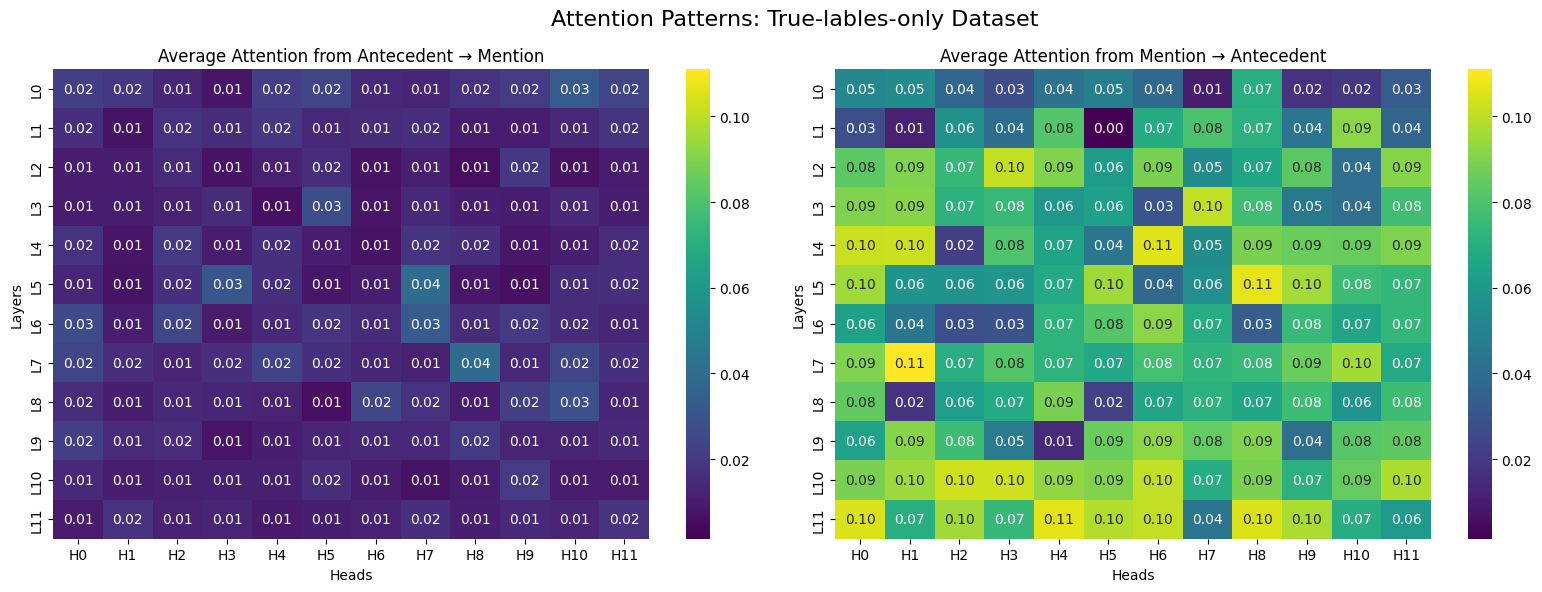

model name: Musixmatch/umberto-wikipedia-uncased-v1


Processing: 100%|██████████| 2129/2129 [03:57<00:00,  8.97sample/s]


Number of labelling problems found: 59
Number of indexing problems found: 0


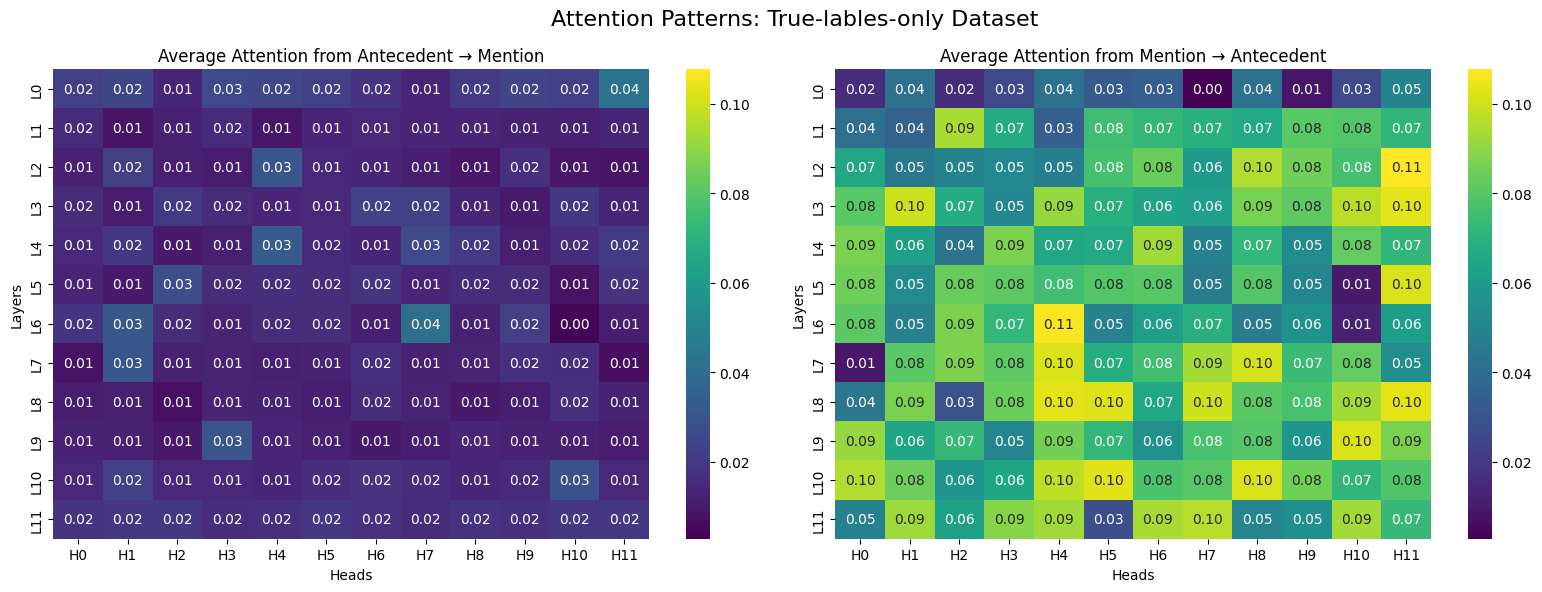

model name: idb-ita/gilberto-uncased-from-camembert


Processing: 100%|██████████| 2129/2129 [03:53<00:00,  9.11sample/s]


Number of labelling problems found: 104
Number of indexing problems found: 0


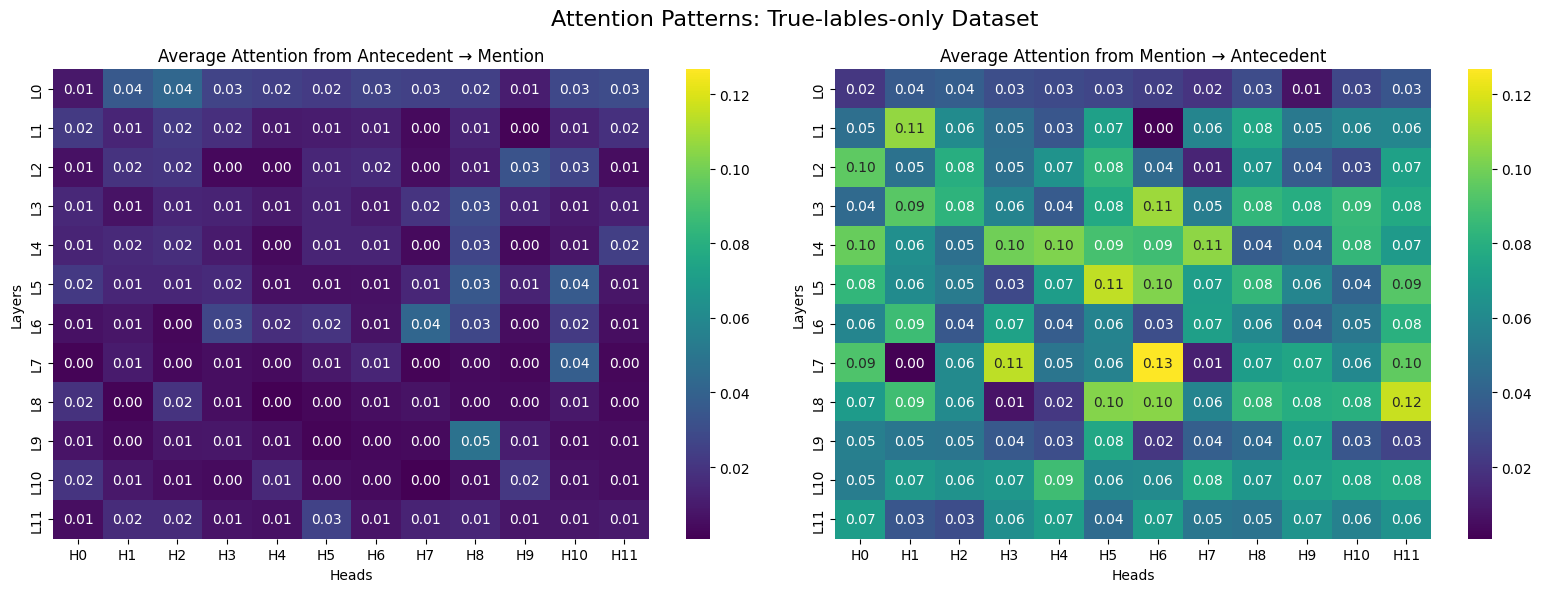

model name: m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0


Processing: 100%|██████████| 2129/2129 [03:50<00:00,  9.23sample/s]


Number of labelling problems found: 0
Number of indexing problems found: 0


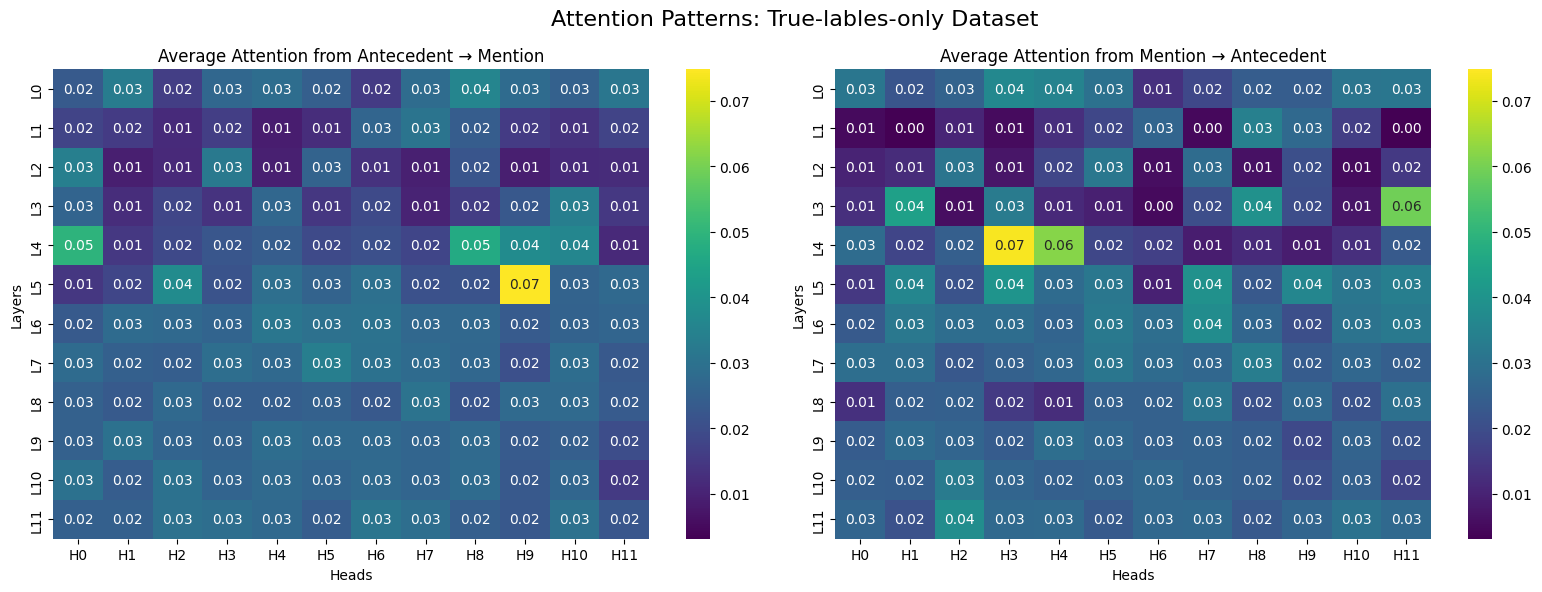

In [33]:
## visualisation: iteration through WHOLE DATASET
# model: iteration (4 Italian models)
# dataset: coref_df (only true labels) 

import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

problems = []

for m in model_pairs[1:]:

    model_name = m[0]
    print(f"model name: {model_name}")
    tokenizer = m[1]
    model = m[2]
    
    num_layers = model.config.num_hidden_layers
    num_heads = model.config.num_attention_heads
    
    # initialise accumulator
    total_attention_a2p = torch.zeros((num_layers, num_heads)) # tensor filled with 0s
    total_attention_p2a = torch.zeros((num_layers, num_heads)) 
    
    num_samples = len(coref_df)
    num_labelling_problems = 0
    num_indexing_problems = 0
    
    # iterate through dataset
    for n in tqdm(range(num_samples), desc="Processing", unit="sample", colour="green"):
        sentence = coref_df['text'][n].lower()
        antecedent = coref_df['antecedent'][n].lower()
        mention = coref_df['mention'][n].lower()
        
        # tokenise input
        inputs = tokenizer(sentence, return_tensors="pt", add_special_tokens=False)
        tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    
        with torch.no_grad():
            outputs = model(**inputs)
            attentions = outputs.attentions  # get attention matrices
        
        # identify token indices for antecedent (needed because of subword tokenizer)
        antecedent_tokens = tokenizer.tokenize(antecedent)  # tokenise antecedent itself
        antecedent_indices = []
        for i in range(len(tokens)):
            if tokens[i : i + len(antecedent_tokens)] == antecedent_tokens:
                antecedent_indices = list(range(i, i + len(antecedent_tokens)))
                break  # stop after first match
        # identify token indices for mention
        mention_tokens = tokenizer.tokenize(mention)  # tokenise mention itself
        mention_indices = []
        for i in range(len(tokens)):
            if tokens[i : i + len(mention_tokens)] == mention_tokens:
                mention_indices = list(range(i, i + len(mention_tokens))) # correct to plural (in whole code)
                break  # stop after first match
        
        # check if antecedent was found
        if not antecedent_indices:
            #print(f"Skipping example: antecedent '{antecedent}' not found in tokenized text.")
            #print("Sentence: ",coref_df['text'][n])
            #print(f"Example number: {n}.\n")
            num_labelling_problems+=1
            # creating a dictionary instead of printing problems for a clearer output view
            problems.append({
                'model' : model_name,
                'error' : "antecedent not found",
                'num' : n,
                'example' : coref_df['text'][n],
                'antecedent' : antecedent
            })
            continue  # avoid adding NaN values (results in Error)

        # check if antecedent was found
        if not mention_indices:
            #print(f"Skipping example: mention '{mention}' not found in tokenized text.")
            #print("Sentence: ",coref_df['text'][n])
            #print(f"Example number: {n}.\n")
            num_labelling_problems+=1
            # creating a dictionary instead of printing problems for a clearer output view
            problems.append({
                'model' : model_name,
                'error' : "mention not found",
                'num' : n,
                'example' : coref_df['text'][n],
                'mention' : mention
            })
            continue  # avoid adding NaN values (results in Error)

        # check if mention indices are within tokenised sentence bounds
        if any(idx >= len(tokens) for idx in mention_indices):
            #print(f"Out of bounds mention_indices at example {n}:")
            #print(f"Sentence: {row['text']}")
            #print(f"Mention: {row['mention']}")
            #print(f"Mention index: {mention_indices}, Sentence length: {len(tokens)}")
            num_indexing_problems+=1
            problems.append({
                'model' : model_name,
                'error' : "out of bounds mention index",
                'num' : n,
                'example' : coref_df['text'][n],
                'mention' : mention,
                'mention-idx, sentence-len' : (mention_indices,len(tokens))
            })
            continue
            

        # accumulate attention scores
        for layer in range(num_layers):
            for head in range(num_heads):
                attn_matrix = attentions[layer][0, head] # attention matrix of shape [seq_len, seq_len]
                attention_value_a2p = attn_matrix[np.ix_(antecedent_indices, mention_indices)].mean()
                attention_value_p2a = attn_matrix[np.ix_(mention_indices, antecedent_indices)].mean()
                total_attention_a2p[layer, head] += attention_value_a2p
                total_attention_p2a[layer, head] += attention_value_p2a
    
    # compute average attention across dataset
    valid_samples = num_samples - num_labelling_problems - num_indexing_problems
    avg_attention_a2p = total_attention_a2p / valid_samples
    avg_attention_p2a = total_attention_p2a / valid_samples
    
    # convert to NumPy for visualisation
    avg_attention_a2p = avg_attention_a2p.numpy()
    avg_attention_p2a = avg_attention_p2a.numpy()
    
    print(f"Number of labelling problems found: {num_labelling_problems}")
    print(f"Number of indexing problems found: {num_indexing_problems}")
    
    
    ## visualisation 

    vmin = min(avg_attention_a2p.min(), avg_attention_p2a.min())
    vmax = max(avg_attention_a2p.max(), avg_attention_p2a.max())

    # plot average attention heatmap
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

    # overall title
    fig.suptitle("Attention Patterns: True-lables-only Dataset", fontsize=16, y=0.98)
    
    # heatmap: antecedent > mention
    sns.heatmap(avg_attention_a2p, annot=True, fmt=".2f", cmap="viridis", # "coolwarm"
                xticklabels=[f"H{i}" for i in range(num_heads)],
                yticklabels=[f"L{i}" for i in range(num_layers)],
                ax=axs[0], vmin=vmin, vmax=vmax)
    axs[0].set_title("Average Attention from Antecedent → Mention")
    axs[0].set_xlabel("Heads")
    axs[0].set_ylabel("Layers")
    
    # heatmap: mention > antecedent
    sns.heatmap(avg_attention_p2a, annot=True, fmt=".2f", cmap="viridis", # "coolwarm"
                xticklabels=[f"H{i}" for i in range(num_heads)],
                yticklabels=[f"L{i}" for i in range(num_layers)],
                ax=axs[1], vmin=vmin, vmax=vmax)
    axs[1].set_title("Average Attention from Mention → Antecedent")
    axs[1].set_xlabel("Heads")
    axs[1].set_ylabel("Layers")
    
    plt.tight_layout()
    plt.show()

**Visualisation of attention patterns between antecedent and mention (in both directions) in dataframe containing only True labels:**

The two UmBERTo models and the GilBERTo model encounter some labelling problems, probably due to the tokenisation strategy used and handling of specific punctuation marks (high commas, parenthesis, etc., as shown in the following cell); on the other hand AlBERTo does not encounter any labelling problem. Labelling problems are skipped during the building of the attention matrices. 

The two **UmBERTo** models and **GilBERTo** have a similar pattern: they show higher activations in the attention from mention to antecedent rather than the other way around, with the two UmBERTo models reaching peaks of 0.11 and the GilBERTo model arriving up to 0.13. To a visual analysis attention seems to be slightly stronger in the second half of the models' layers for what concerns the two UmBERTo models, being however still fairly distributed throughout their architecture. GilBERTo, on the other hand, shows a less distributed pattern, with less heads strongly active in the relationship and with a higher concentration in the middle layers.
**AlBERTo** differs from the other models in showing active heads in both directions, i.e., antecedent to mention and mention to antecedent, with lower peaks (0.07) than the others. The heads active in the relation are extremely scarce with only 3 heads per direction being equal or above 0.05. What is interesting to note is that the heads with the strongest activations are found in the first half of the model's layers, with other heads having very low scores, while in the second half of the layers no strongly activated heads can be found, but rather a higher average attention in respect to the non-active initial heads can be observed.

In [34]:
## visualisation of 3 random problem examples from each model

import pandas as pd

problems_df = pd.DataFrame(problems)

samples = []
# group by model and sample (at least) 3
for model, group in problems_df.groupby("model"):
    sampled = group.sample(n=min(3, len(group)), random_state=43)
    samples.append(sampled)
samples = pd.concat(samples, axis=0).reset_index(drop=True)

# print sampled
for _,row in samples.iterrows():
    print(f"model: {row['model']}")
    print(f"error: {row['error']}")
    print(f"example: {row['num']}. {row['example']}")
    val = row['antecedent']
    if pd.isna(val) or val == "":
        val = row['mention']
    print(f"problem: {val}")
    print("---------------------")

model: Musixmatch/umberto-commoncrawl-cased-v1
error: antecedent not found
example: 36. Papi coinvolti nel concilio e nella sua preparazione''Leone X: Durante il suo pontificato ebbe luogo la ribellione di Lutero''Clemente VII Questi due papi di formazione rinascimentale, della famiglia dei Medici, sottovalutarono la portata della Riforma e non convocarono, come da più parti richiesto, il concilio per la riforma della chiesa.
problem: leone x
---------------------
model: Musixmatch/umberto-commoncrawl-cased-v1
error: antecedent not found
example: 219. Così, quando, nel 1838, don Pier Paolo Righler, padre spirituale del seminario teologico di Trento, fu nominato alla cattedra di professore di pastorale, il vescovo nominò a sua volta don Matteo Gottardi suo successore.
problem: nel 1838
---------------------
model: Musixmatch/umberto-commoncrawl-cased-v1
error: mention not found
example: 1567. La sede centrale dell'associazione si trova a Trento nel Palazzo Saracini - Cresseri (sec. XVI)

In [7]:
## iteration through the whole dataset after splitting it in two datasets plotted side by side for comparison
# model: iteration (4 Italian models)
# dataset: -- 

import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

problems = []

# function to visualise the different datasets: args(df,label_to_plot)
def average_attention_split(df0,df1,label0,label1,overall_title):
    
    # function to compute average attention
    def compute_average_attention(df_subset):
        total_attention_a2p = torch.zeros((num_layers, num_heads)) # accumulator
        total_attention_p2a = torch.zeros((num_layers, num_heads))
        num_samples = len(df_subset)
        
        num_labelling_problems = 0
        num_indexing_problems = 0
    
        # iterate through dataset
        for n in tqdm(range(num_samples), desc="Processing", unit="sample", colour="green"):
            sentence = df_subset['text'].iloc[n].lower()
            antecedent = df_subset['antecedent'].iloc[n].lower()
            mention = df_subset['mention'].iloc[n].lower()
            
            # tokenize input
            inputs = tokenizer(sentence, return_tensors="pt", add_special_tokens=False)
            tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    
            with torch.no_grad():
                outputs = model(**inputs)
                attentions = outputs.attentions # get attention matrices
    
            # identify token indices for antecedent (considers subword tokenizer)
            antecedent_tokens = tokenizer.tokenize(antecedent)
            antecedent_indices = []
            for i in range(len(tokens)):
                if tokens[i : i + len(antecedent_tokens)] == antecedent_tokens:
                    antecedent_indices = list(range(i, i + len(antecedent_tokens)))
                    break  
            
            # identify token index for mention
            mention_tokens = tokenizer.tokenize(mention)  # tokenise mention itself
            mention_indices = []
            for i in range(len(tokens)):
                if tokens[i : i + len(mention_tokens)] == mention_tokens:
                    mention_indices = list(range(i, i + len(mention_tokens))) # correct to plural (in whole code)
                    break  # stop after first match 
                    
            # check if antecedent was found
            if not antecedent_indices:
                #print(f"Skipping example: antecedent '{antecedent}' not found in tokenized text.")
                #print("Sentence: ", df_subset.iloc[n]['sentence'])
                #print(f"Example number: {n}.\n")
                num_labelling_problems+=1
                # creating a dictionary instead of printing problems for a clearer output view
                problems.append({
                    'model' : model_name,
                    'dataset split' : df_subset,
                    'error' : "antecedent not found",
                    'num' : n,
                    'example' : coref_df['text'][n],
                    'antecedent' : antecedent
                })
                continue  # avoid adding NaN values (results in Error)

            # check if mention was found
            if not mention_indices:
                #print(f"Skipping example: mention '{mention}' not found in tokenized text.")
                #print("Sentence: ", df_subset.iloc[n]['sentence'])
                #print(f"Example number: {n}.\n")
                num_labelling_problems+=1
                # creating a dictionary instead of printing problems for a clearer output view
                problems.append({
                    'model' : model_name,
                    'dataset split' : df_subset,
                    'error' : "mention not found",
                    'num' : n,
                    'example' : coref_df['text'][n],
                    'mention' : mention
                })
                continue  # avoid adding NaN values (results in Error)
                
            # check if mention indices are within tokenised sentence bounds
            if any(idx >= len(tokens) for idx in mention_indices):
                #print(f"Out of bounds mention_indices at example {n}:")
                #print(f"Sentence: {row['text']}")
                #print(f"Mention: {row['mention']}")
                #print(f"Mention index: {mention_indices}, Sentence length: {len(tokens)}")
                num_indexing_problems+=1
                problems.append({
                    'model' : model_name,
                    'dataset split' : df_subset,
                    'error' : "out of bounds mention index",
                    'num' : n,
                    'example' : coref_df['text'][n],
                    'mention' : mention,
                    'mention-idx, sentence-len' : (mention_indices,len(tokens))
                })
                continue

            # accumulate attention scores
            for layer in range(num_layers):
                for head in range(num_heads):
                    attn_matrix = attentions[layer][0, head] # attention matrix of shape [seq_len, seq_len]
                    attention_value_a2p = attn_matrix[np.ix_(antecedent_indices, mention_indices)].mean()
                    attention_value_p2a = attn_matrix[np.ix_(mention_indices, antecedent_indices)].mean()
                    total_attention_a2p[layer, head] += attention_value_a2p
                    total_attention_p2a[layer, head] += attention_value_p2a
                
        # compute average attention across dataset
        avg_attention_a2p = total_attention_a2p / num_samples
        avg_attention_p2a = total_attention_p2a / num_samples
        
        # convert to NumPy for visualisation
        avg_attention_a2p = avg_attention_a2p.numpy()
        avg_attention_p2a = avg_attention_p2a.numpy()

        return avg_attention_a2p, avg_attention_p2a
    
    # compute attention for both subsets and both directions
    avg_attention_0_a2p, avg_attention_0_p2a = compute_average_attention(df0)
    avg_attention_1_a2p, avg_attention_1_p2a = compute_average_attention(df1)


    ## visualisation
    
    # shared min and max for consistent color scale
    vmin = min(avg_attention_0_a2p.min(), avg_attention_0_p2a.min(), avg_attention_1_a2p.min(), avg_attention_1_p2a.min())
    vmax = max(avg_attention_0_a2p.max(), avg_attention_0_p2a.max(), avg_attention_1_a2p.max(), avg_attention_1_p2a.max())

    # plot side-by-side heatmaps
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    
    xticks = [f"H{i}" for i in range(num_heads)]
    yticks = [f"L{i}" for i in range(num_layers)]
    
    # overall title
    fig.suptitle(overall_title, fontsize=16, y=0.98)

    # plot each heatmap
    sns.heatmap(avg_attention_0_a2p, annot=True, fmt=".2f", cmap="viridis",
                xticklabels=xticks, yticklabels=yticks, ax=axs[0, 0], vmin=vmin, vmax=vmax)
    axs[0, 0].set_title(f"Average Attention from Antecedent → Mention — {label0}")
    axs[0, 0].set_xlabel("Heads")
    axs[0, 0].set_ylabel("Layers")

    sns.heatmap(avg_attention_0_p2a, annot=True, fmt=".2f", cmap="viridis",
                xticklabels=xticks, yticklabels=yticks, ax=axs[0, 1], vmin=vmin, vmax=vmax)
    axs[0, 1].set_title(f"Average Attention from Mention → Antecedent — {label0}")
    axs[0, 1].set_xlabel("Heads")
    axs[0, 1].set_ylabel("Layers")

    sns.heatmap(avg_attention_1_a2p, annot=True, fmt=".2f", cmap="viridis",
                xticklabels=xticks, yticklabels=yticks, ax=axs[1, 0], vmin=vmin, vmax=vmax)
    axs[1, 0].set_title(f"Average Attention from Antecedent → Mention — {label1}")
    axs[1, 0].set_xlabel("Heads")
    axs[1, 0].set_ylabel("Layers")

    sns.heatmap(avg_attention_1_p2a, annot=True, fmt=".2f", cmap="viridis",
                xticklabels=xticks, yticklabels=yticks, ax=axs[1, 1], vmin=vmin, vmax=vmax)
    axs[1, 1].set_title(f"Average Attention from Mention → Antecedent — {label1}")
    axs[1, 1].set_xlabel("Heads")
    axs[1, 1].set_ylabel("Layers")

    plt.tight_layout()
    plt.show()

model name: Musixmatch/umberto-commoncrawl-cased-v1


Processing: 100%|██████████| 652/652 [01:09<00:00,  9.35sample/s]


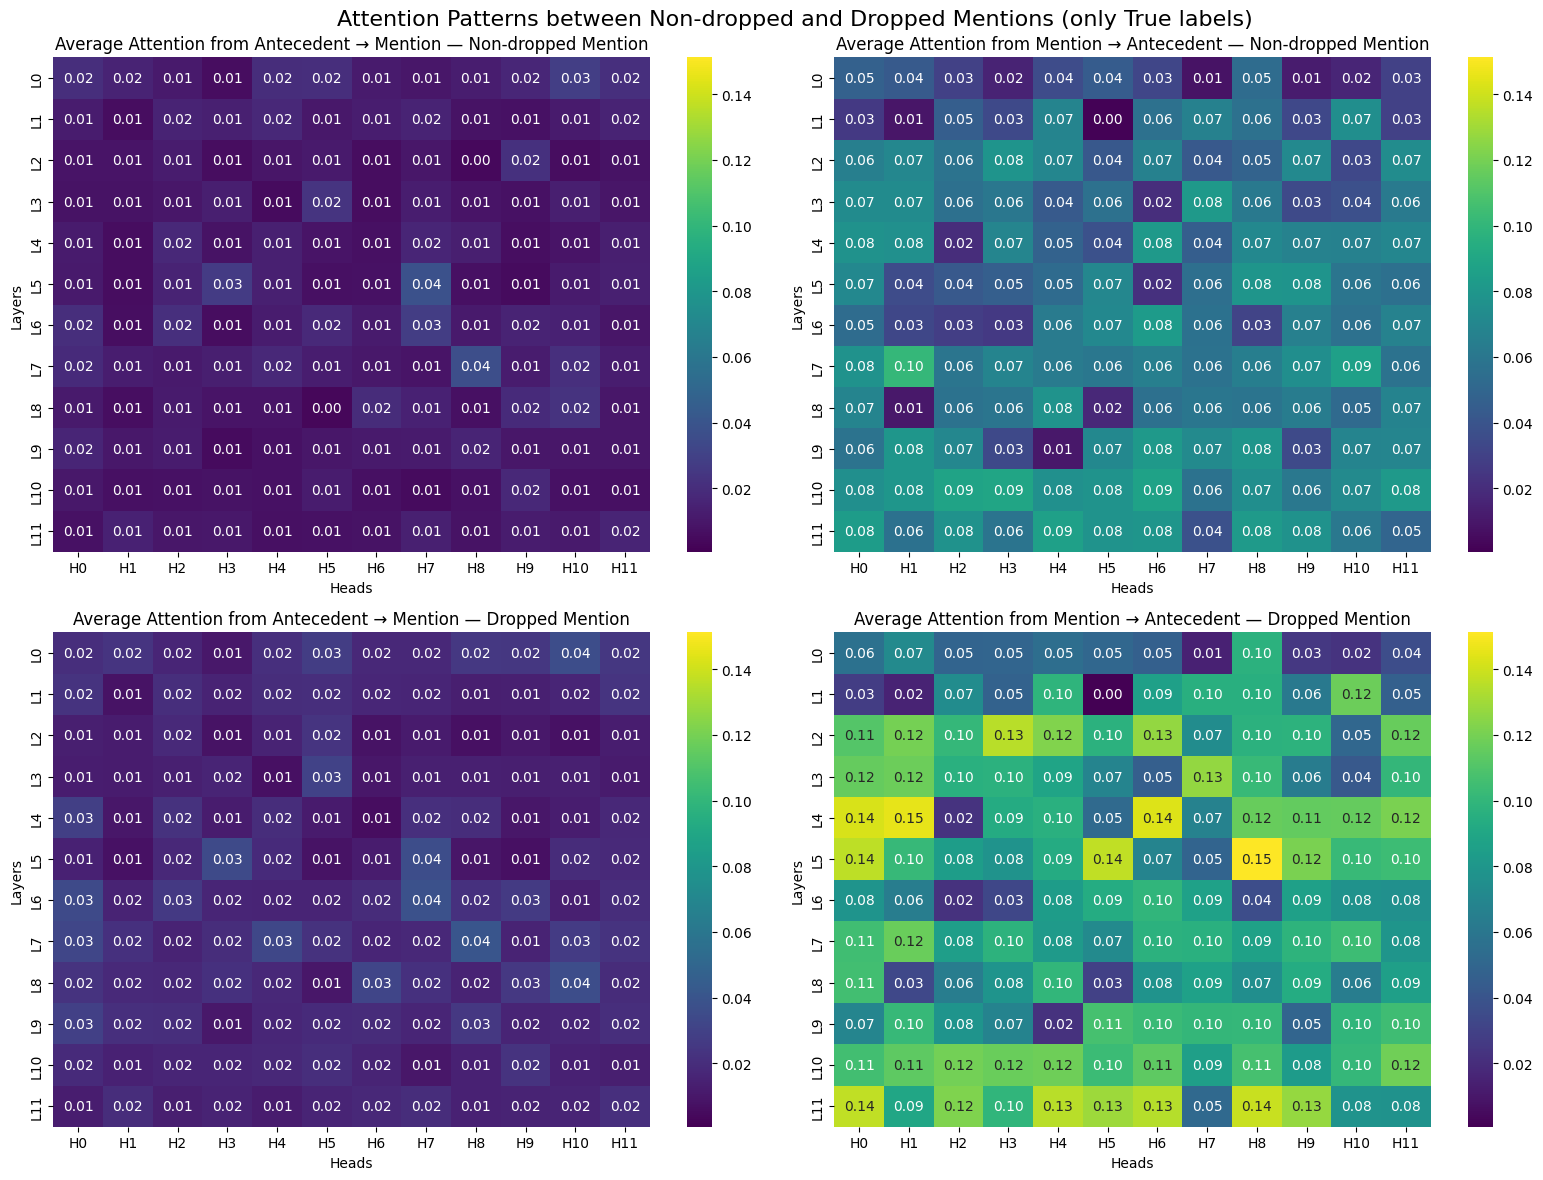

model name: Musixmatch/umberto-wikipedia-uncased-v1


Processing: 100%|██████████| 652/652 [01:09<00:00,  9.40sample/s]


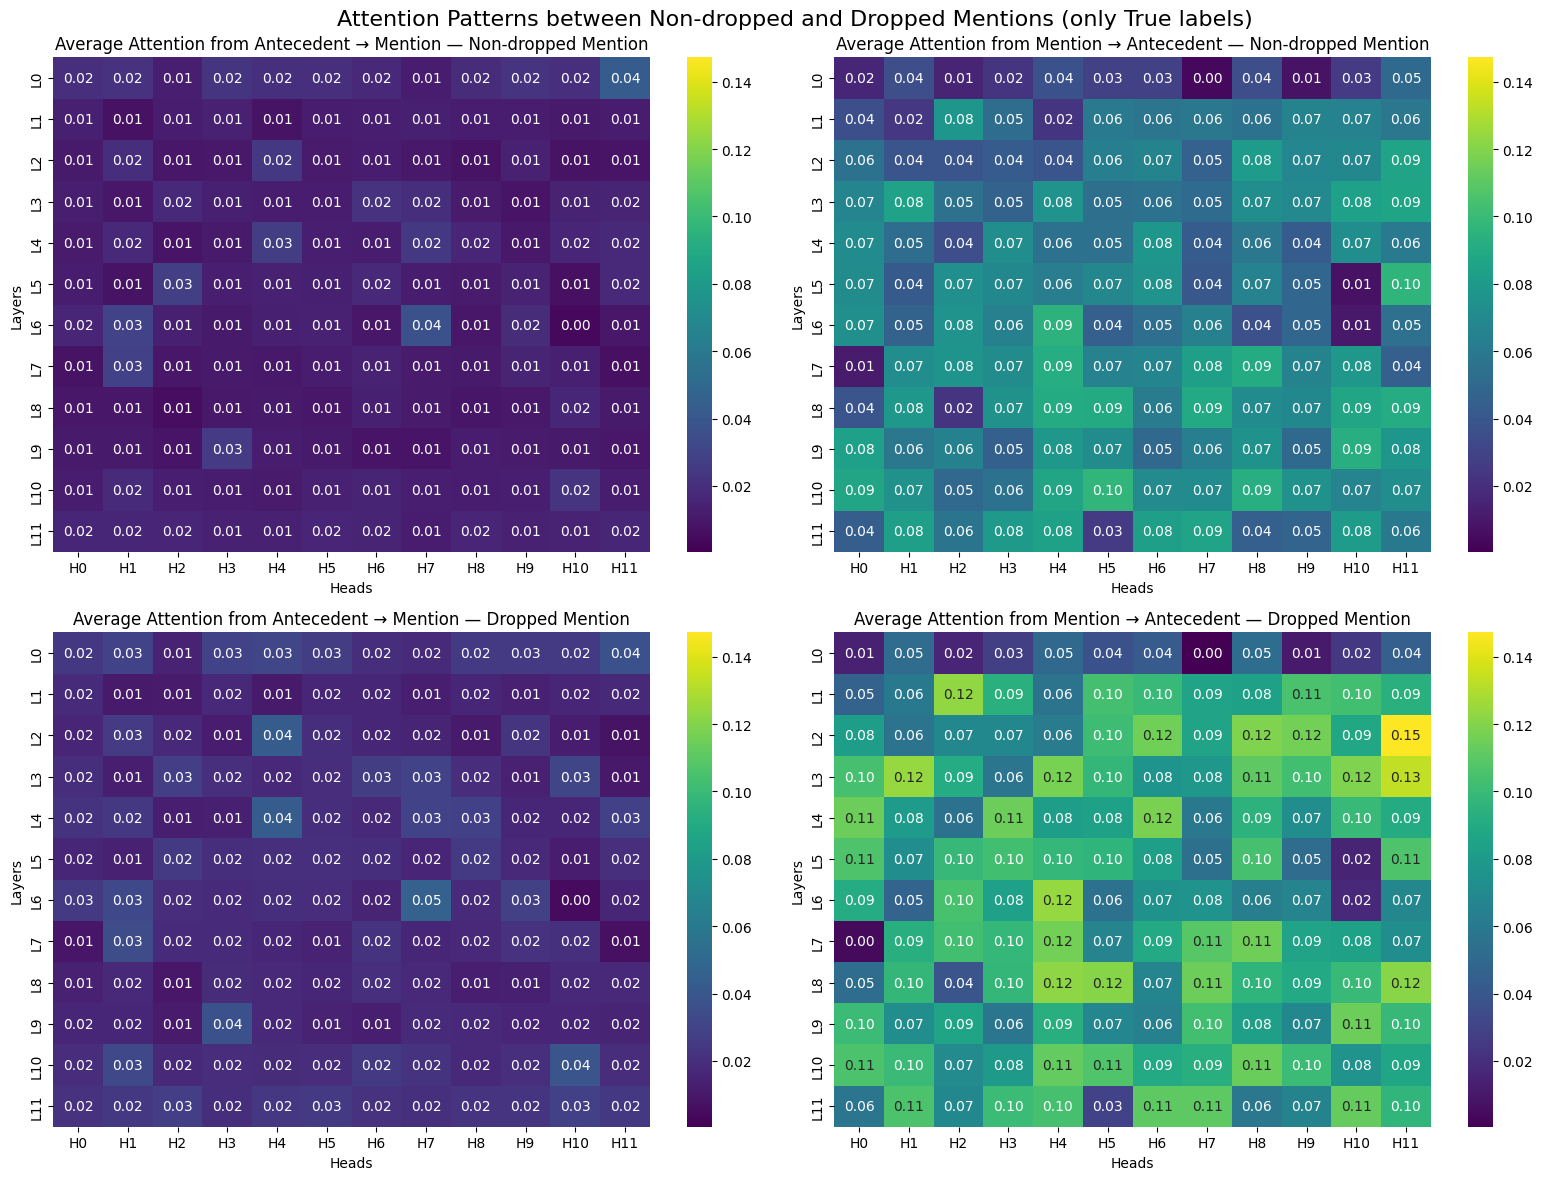

model name: idb-ita/gilberto-uncased-from-camembert


Processing: 100%|██████████| 652/652 [01:08<00:00,  9.58sample/s]


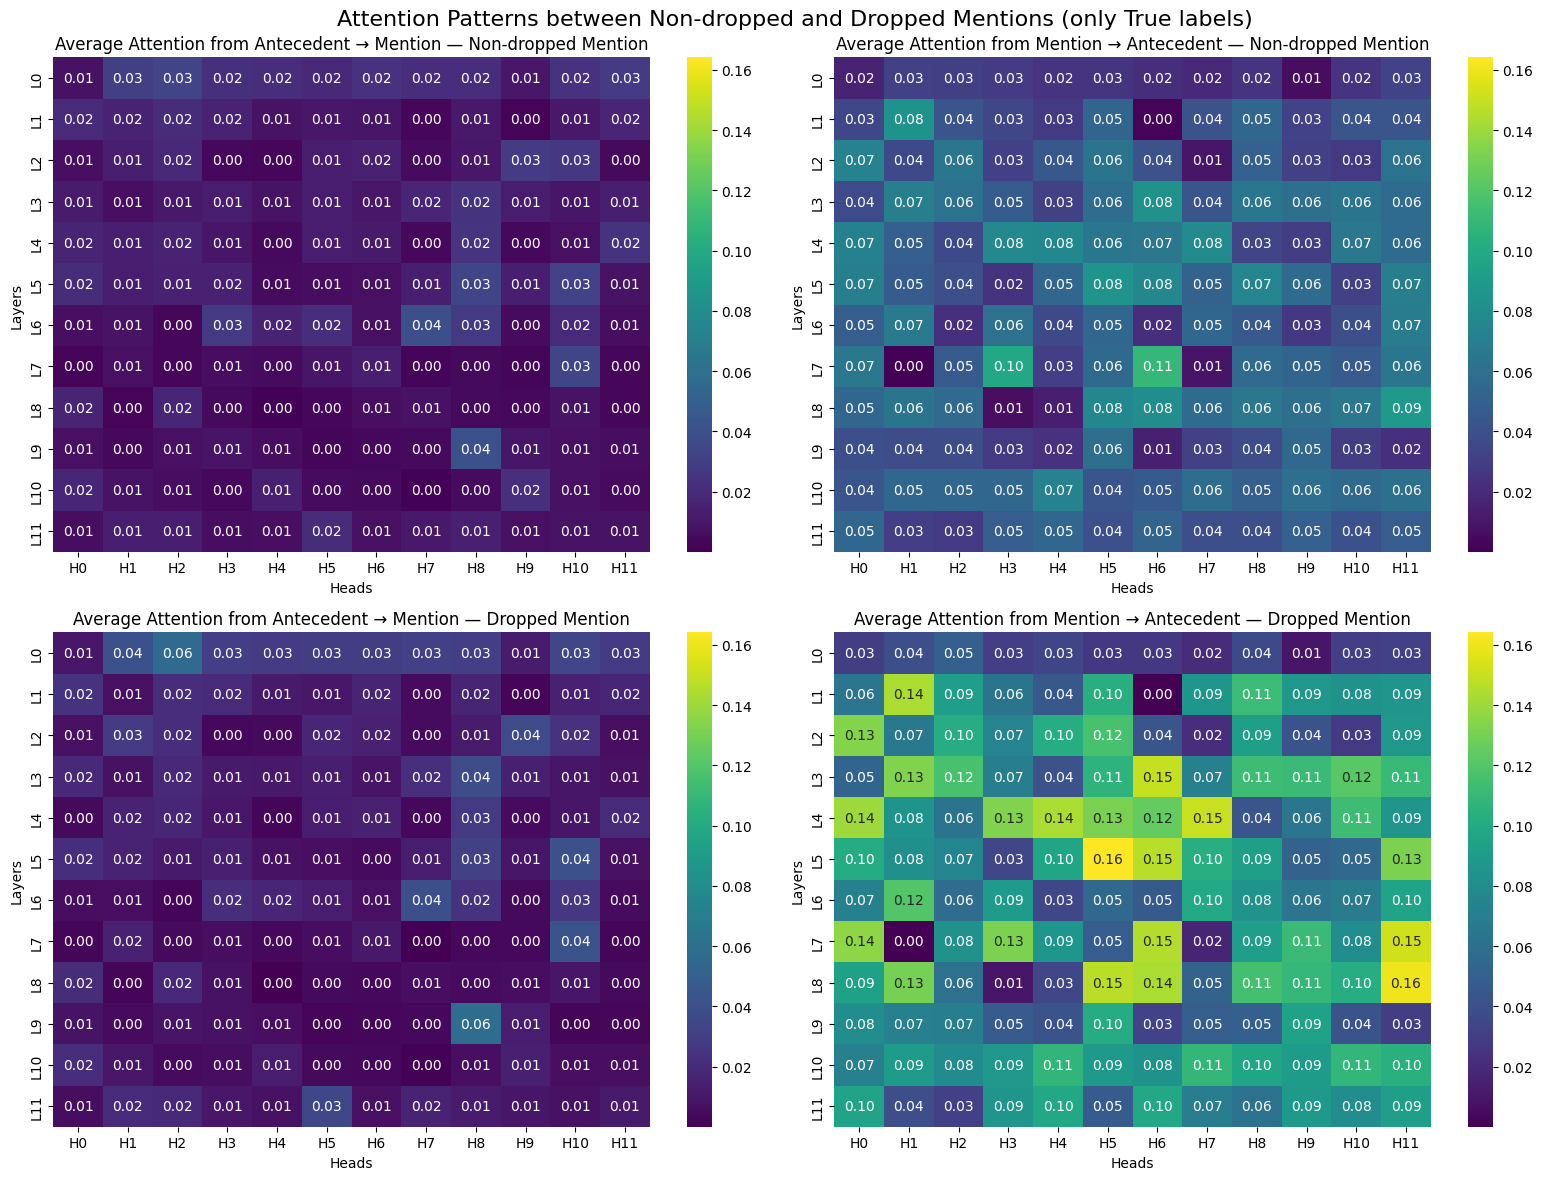

model name: m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0


Processing: 100%|██████████| 652/652 [01:06<00:00,  9.80sample/s]


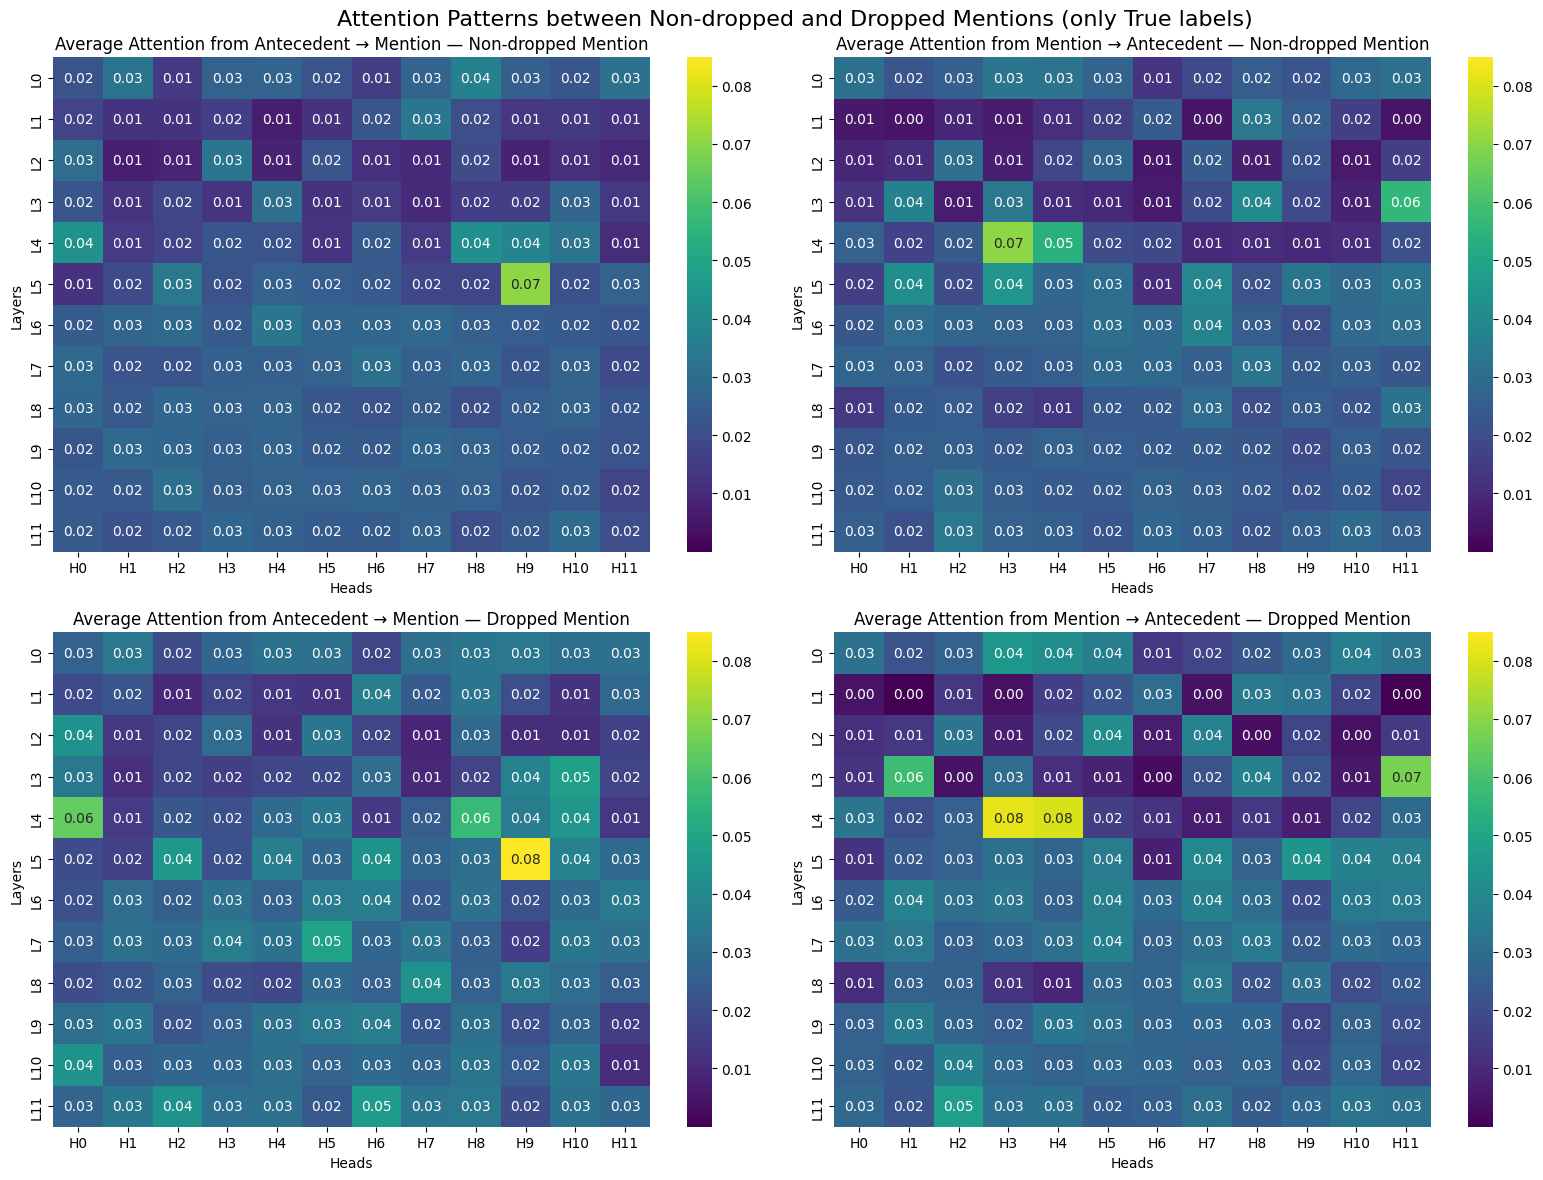

In [36]:
## attention pattern between non-dropped and dropped mentions (True-labels-only dataset)

for m in model_pairs[1:]:

    model_name = m[0]
    print(f"model name: {model_name}")
    tokenizer = m[1]
    model = m[2]

    num_layers = model.config.num_hidden_layers
    num_heads = model.config.num_attention_heads

    average_attention_split(df_no_dropped,df_dropped,"Non-dropped Mention","Dropped Mention","Attention Patterns between Non-dropped and Dropped Mentions (only True labels)")

**Visualisation of attention patterns between antecedent and mention (in both directions) in dataframe containing only True labels:** <br>
**Comparison of non-dropped and dropped mentions**

The two **UmBERTo** models behave similarly. In both non-dropped and dropped mention cases, when the direction of attention is from the antecedent towards the mention, the activation of the heads is very low throughout the model. A different scenario can be seen for the opposite direction, i.e., attention from mention to antecedent. Both models show an activation pattern which is low but nonetheless present throughout the model in attention from a present mention to its antecedent; showing however a stronger activation (\~0.15) when attention goes from a dropped mention (i.e., a verb) to its antecedent. What is interesting to note is the fact that while the verb, in the case of a dropped mention, pays attention to the antecedent, the opposite is not true, since the antecedent does not seem to pay any attention to the future verb of a dropped mention. <br>
**GilBERTo** shows a similar pattern in the four cases as the one seen for the previous two models, showing however slightly higher scores (up to 0.16) with attention being concentrated on fewer heads, thus resulting in a less distributed pattern. <br>
**AlBERTo**'s attention pattern differs in interesting ways. In fact, this last model is the only one which has heads active, in more or less the same way, in both directions. Attention peaks are way lower than the other models (0.07 for non-dropped mentions in both directions and 0.08 for dropped mentions in both directions), but it must be stated that the model shows way less active heads and way lower attention scores on average. The strongly active heads are in both cases located between layer 4 and layer 5, suggesting that the model might attend to this kind of relation in the middle of its architecture.

model name: Musixmatch/umberto-commoncrawl-cased-v1


Processing: 100%|██████████| 2129/2129 [04:19<00:00,  8.21sample/s]


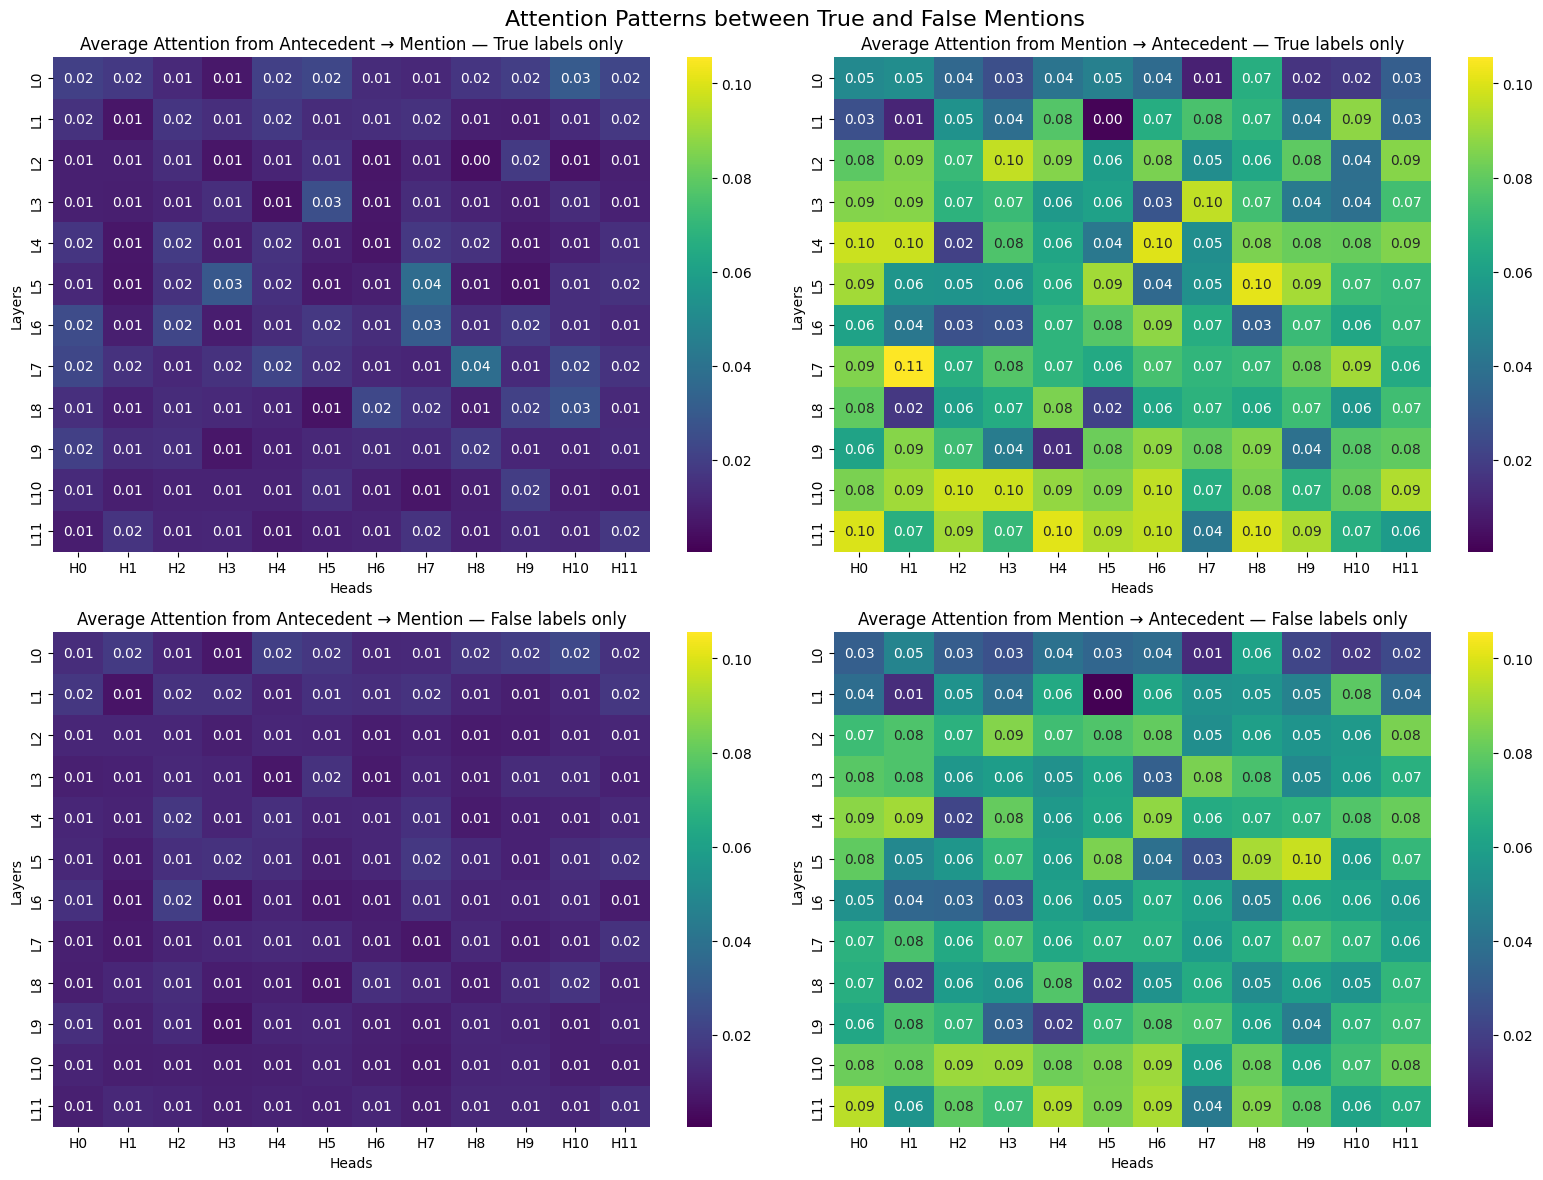

model name: Musixmatch/umberto-wikipedia-uncased-v1


Processing: 100%|██████████| 2129/2129 [04:18<00:00,  8.23sample/s]


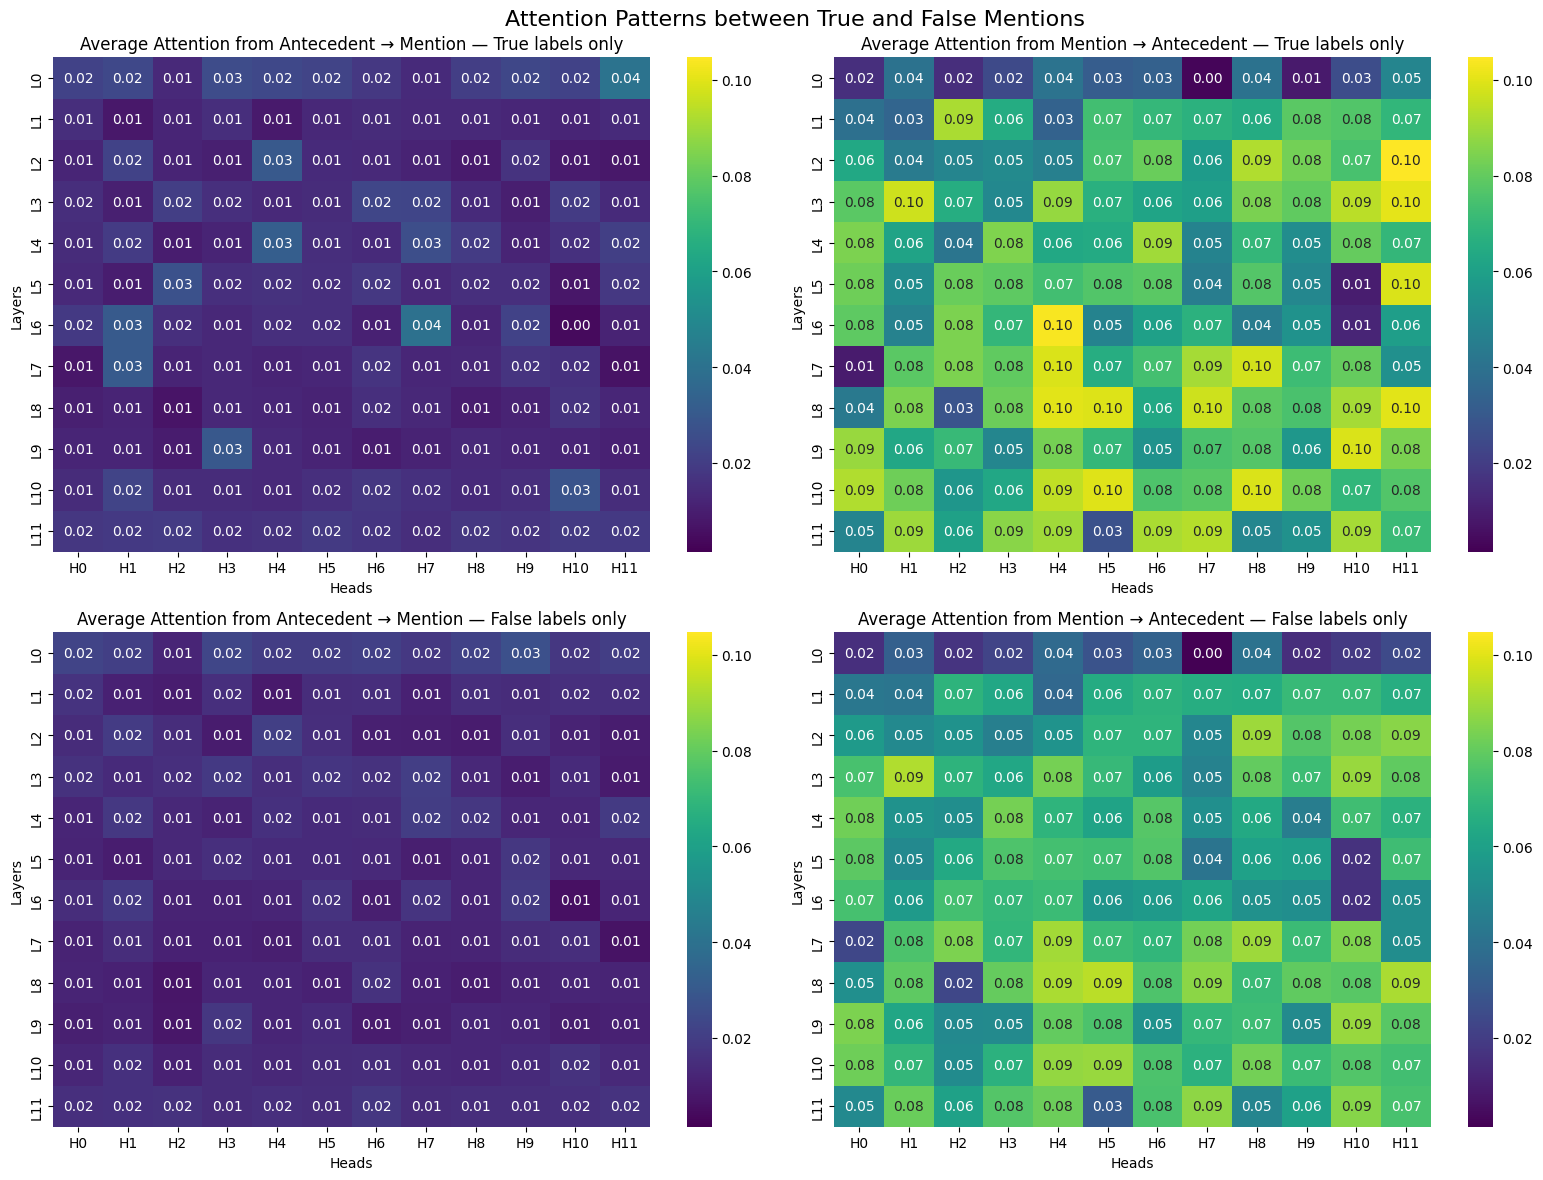

model name: idb-ita/gilberto-uncased-from-camembert


Processing: 100%|██████████| 2129/2129 [04:16<00:00,  8.29sample/s]


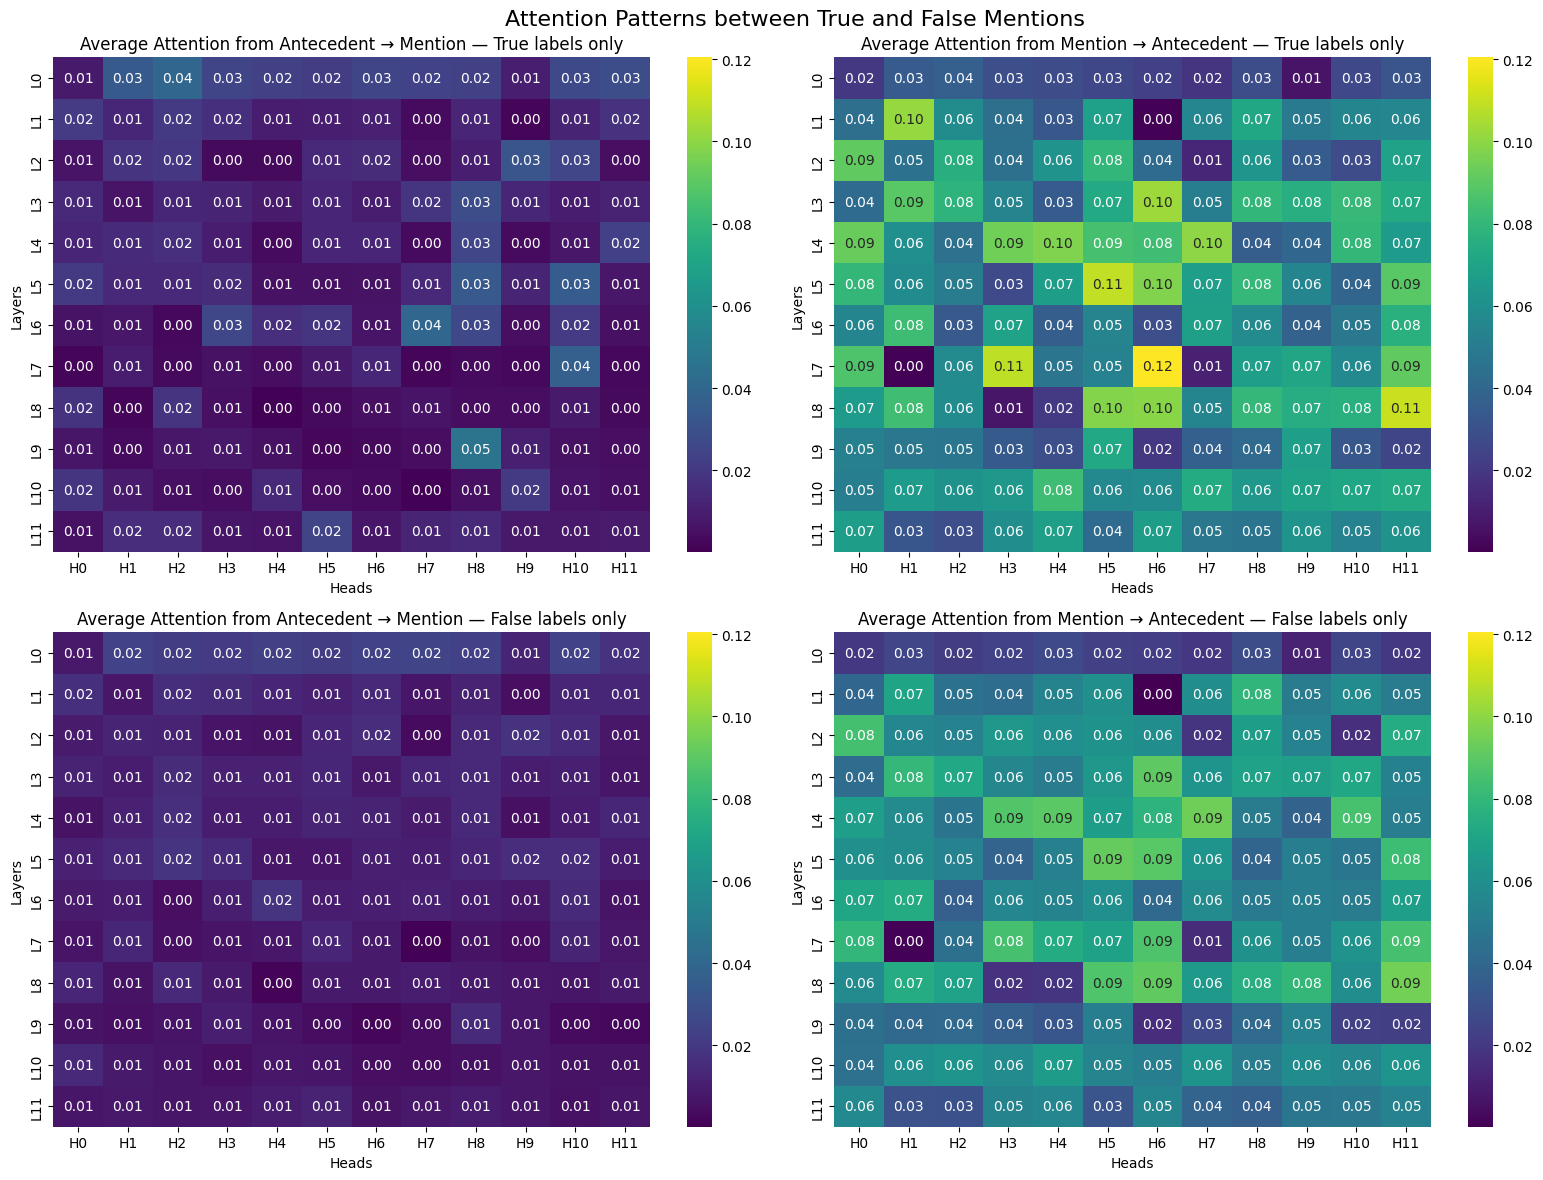

model name: m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0


Processing: 100%|██████████| 2129/2129 [04:14<00:00,  8.36sample/s]


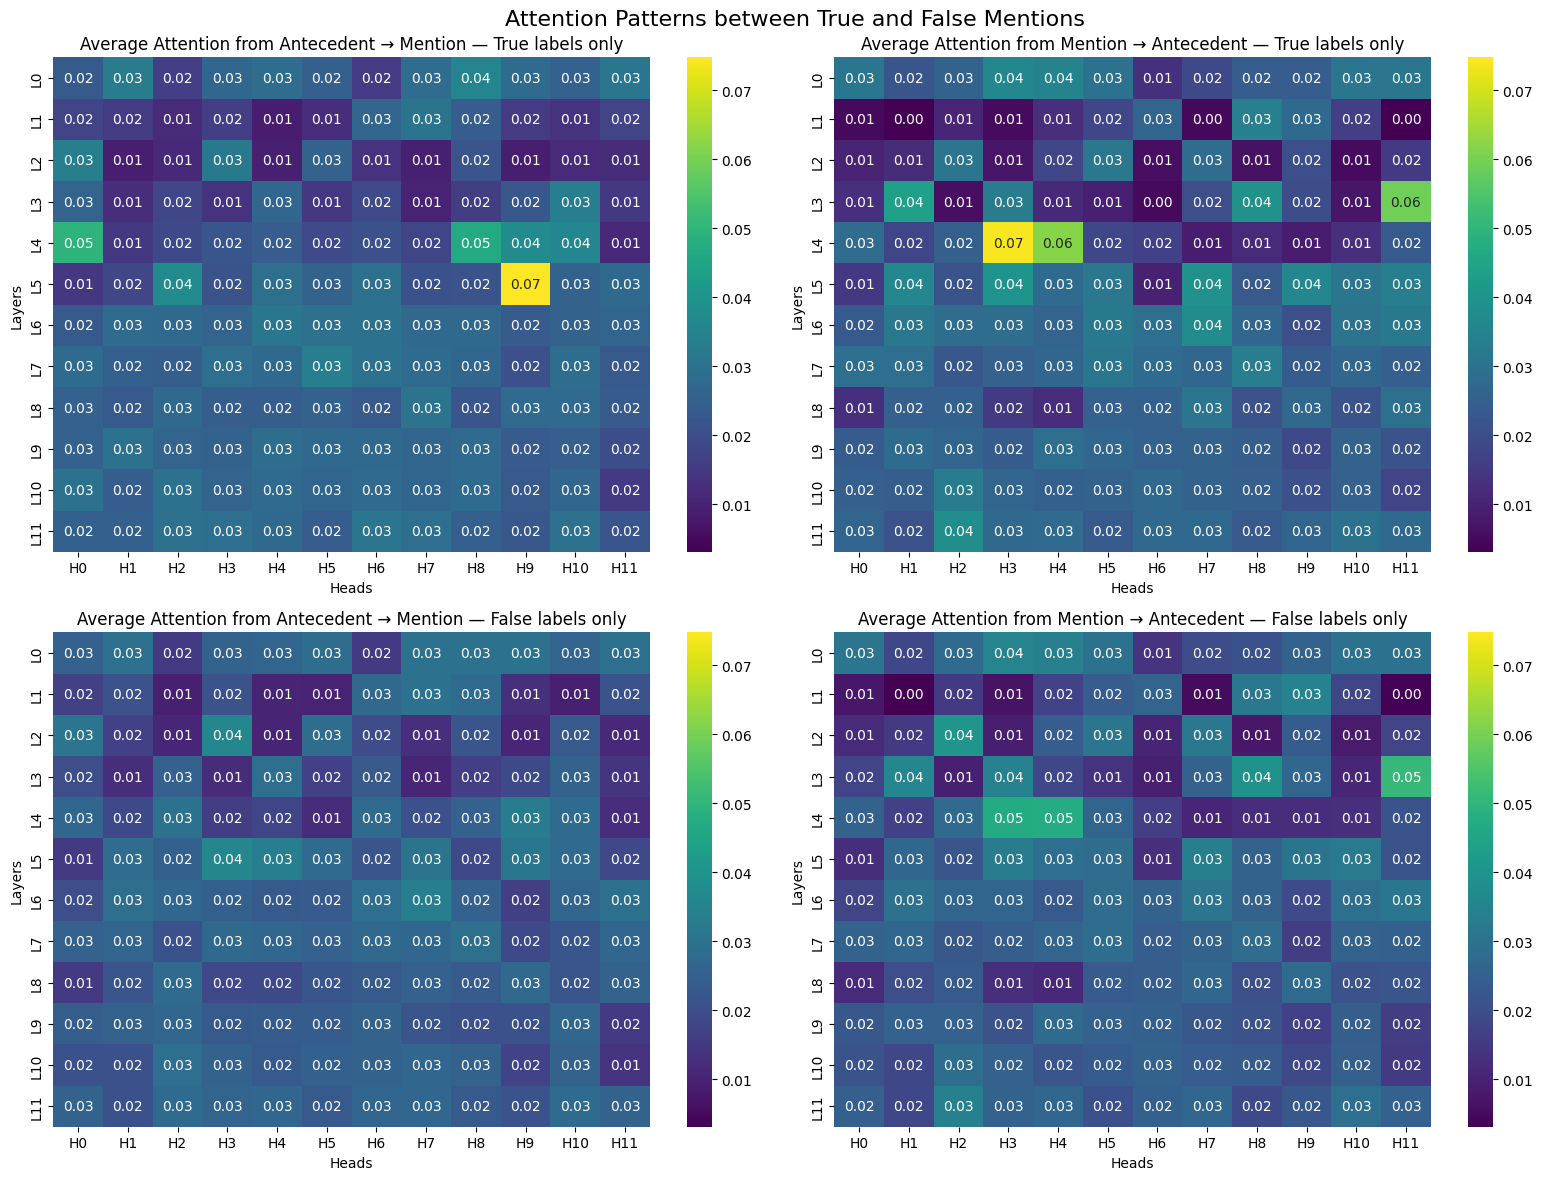

In [8]:
## attention pattern between True and False mentions (True/False balanced dataset)

for m in model_pairs[1:]:

    model_name = m[0]
    print(f"model name: {model_name}")
    tokenizer = m[1]
    model = m[2]

    num_layers = model.config.num_hidden_layers
    num_heads = model.config.num_attention_heads

    average_attention_split(df_tf_true,df_tf_false,"True labels only","False labels only","Attention Patterns between True and False Mentions")

**Visualisation of attention patterns between antecedent and mention (in both directions) in dataframe containing True and False balanced labels:** <br>
**Comparison of true and false mentions**


The two **UmBERTo** models and the **GilBERTo** model behave similarly. Both in the true and false examples, the attention from the antecedent to the mention (either true or false) is very low; what is interesting to note is that the attention in the opposite direction, i.e., from the mention to the antecedent, on one hand is active for both only true and only false examples with what seems like superimposable patterns, but on the other hand, it shows clearly that higher attention scores are reached in the case of true labels in respect to false labels. The models peak, respectively, at 0.11, 0.10, and 0.12 in the case of true examples, and at 0.10, 0.09, and 0.09 in the case of false examples. <br>
**AlBERTo** remains consistent with the previous visualisations: the strongest activations are found in both directions for true mention cases. For what concerns false mention cases, some activated heads can be seen, especially in the early layers and more strongly in the direction from the mention to the antecedent, however still following the pattern of the other models: the same heads seem to be activated in true and false cases, but with higher scores in the case of true examples compared to false examples.

model name: Musixmatch/umberto-commoncrawl-cased-v1


Processing: 100%|██████████| 652/652 [01:15<00:00,  8.69sample/s]


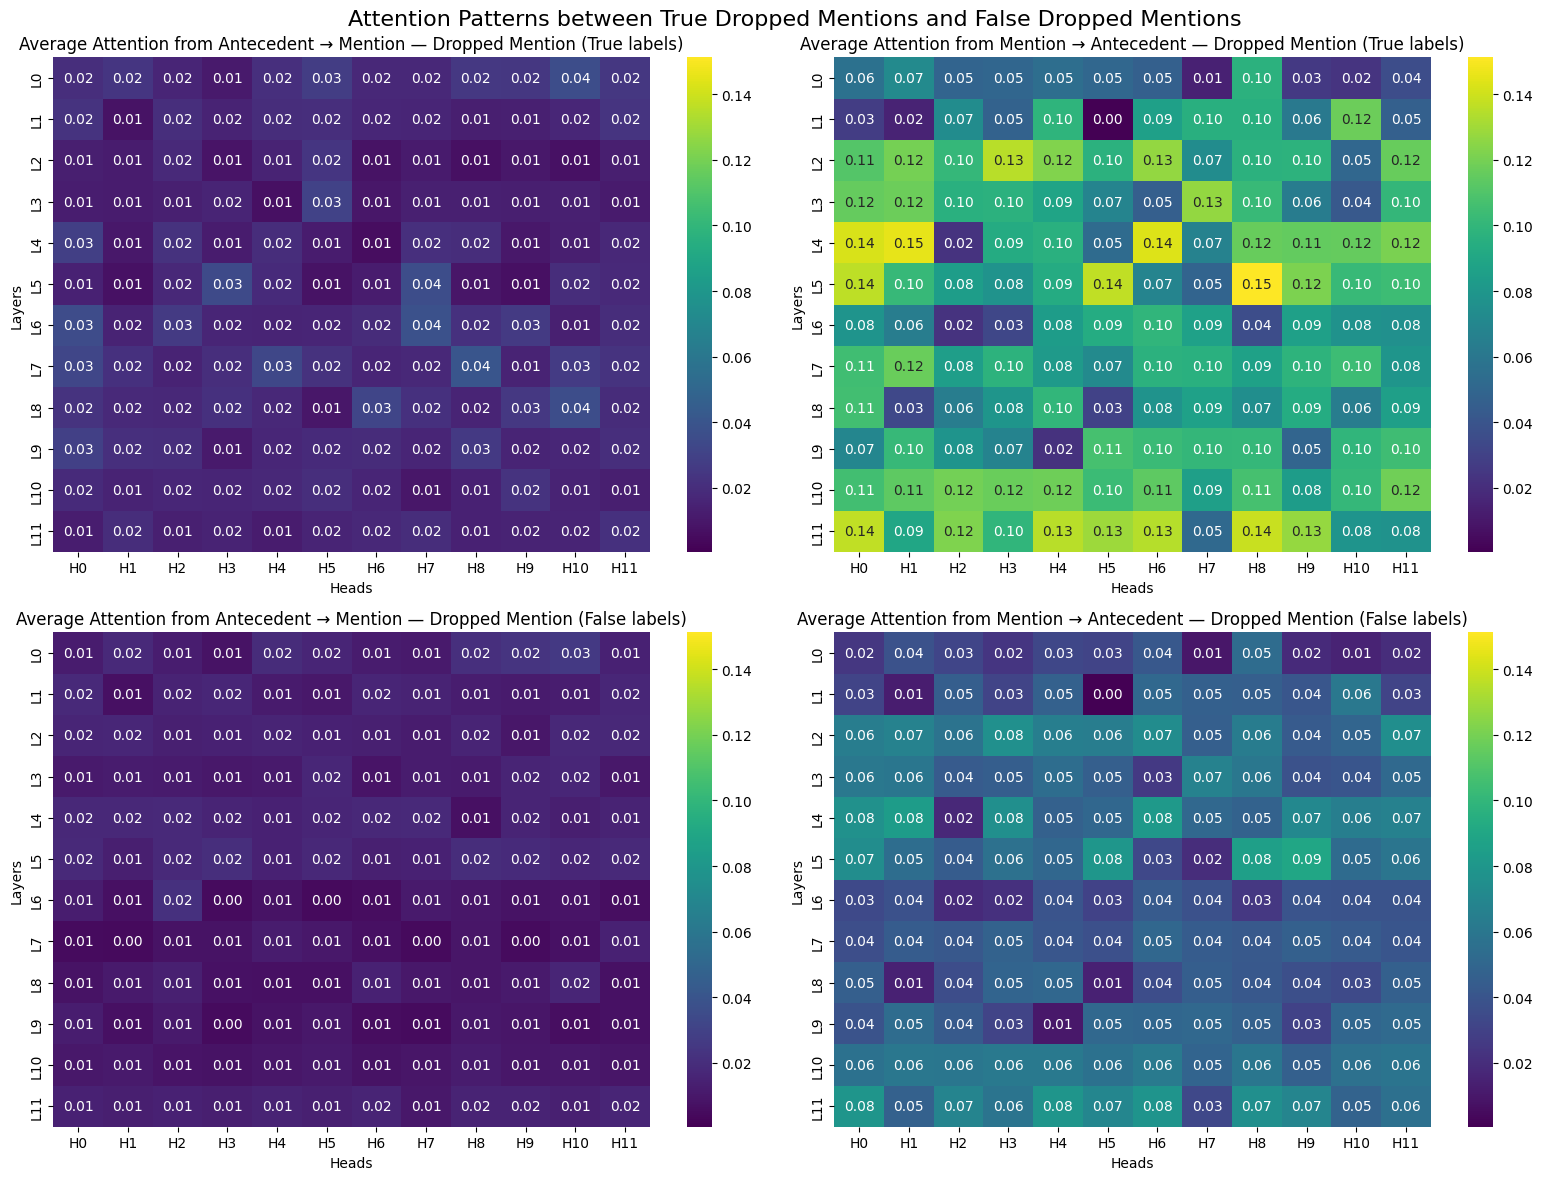

model name: Musixmatch/umberto-wikipedia-uncased-v1


Processing: 100%|██████████| 652/652 [01:14<00:00,  8.75sample/s]


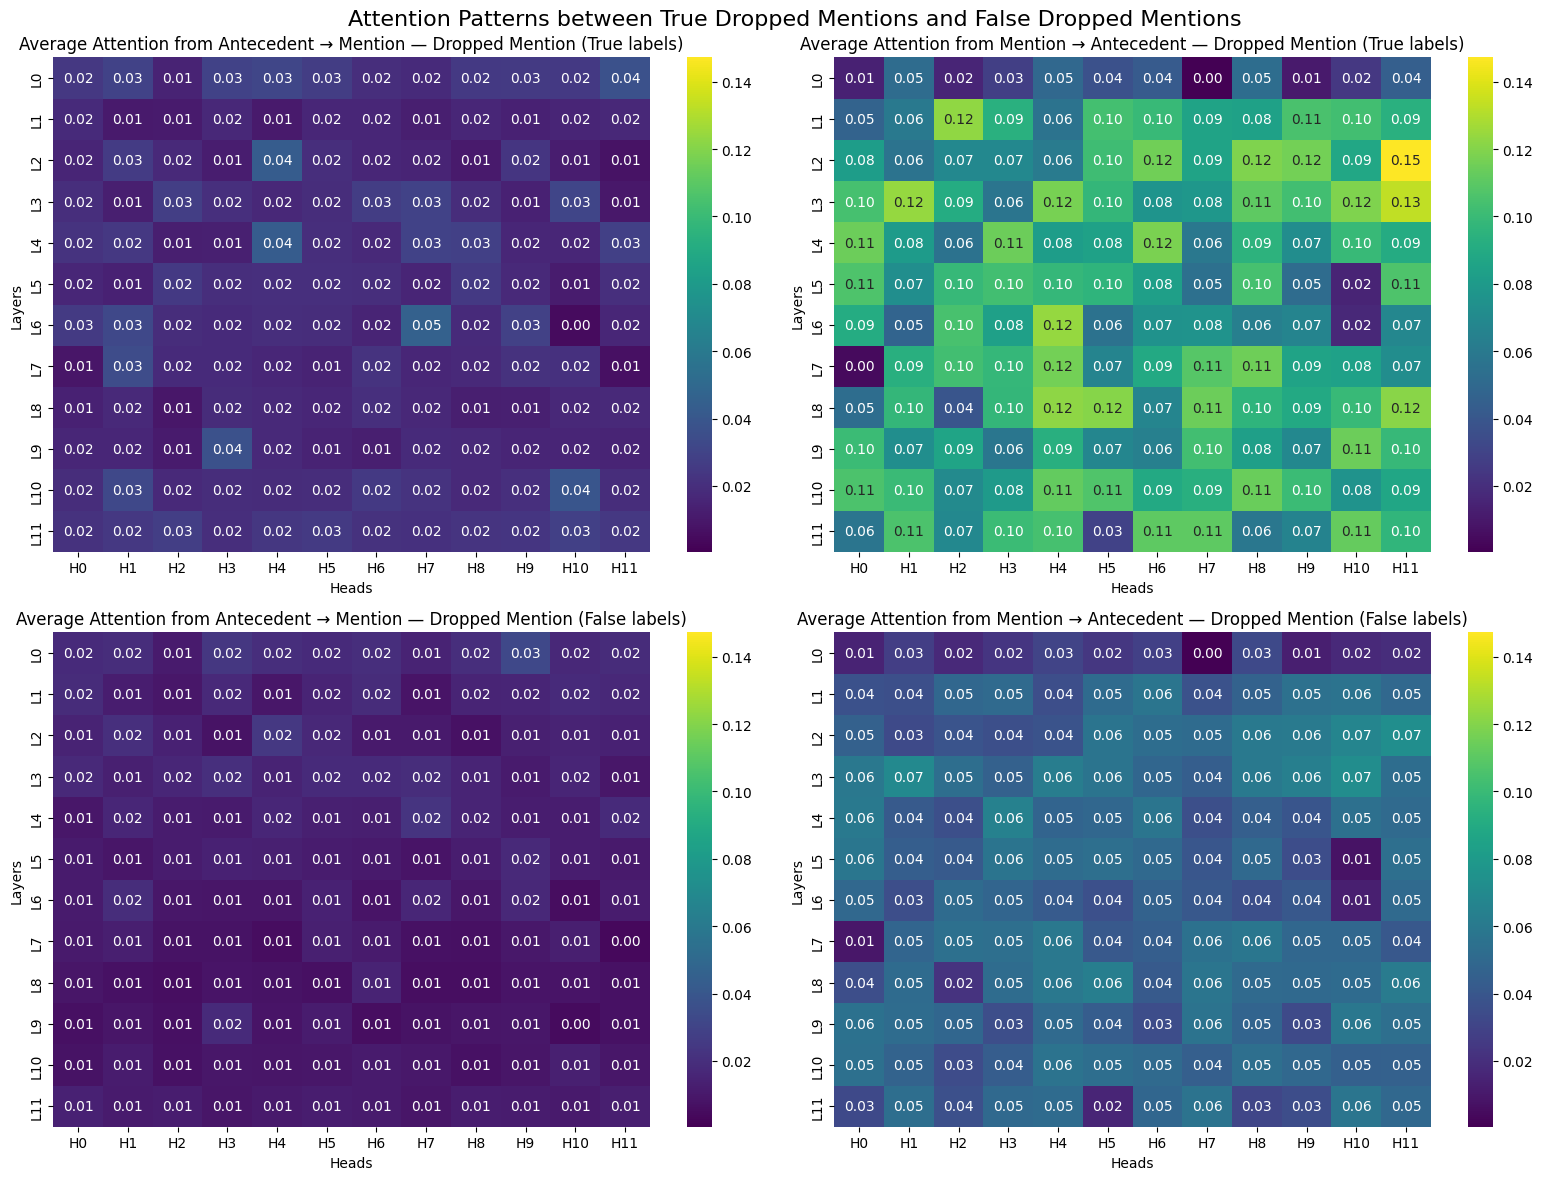

model name: idb-ita/gilberto-uncased-from-camembert


Processing: 100%|██████████| 652/652 [01:13<00:00,  8.92sample/s]


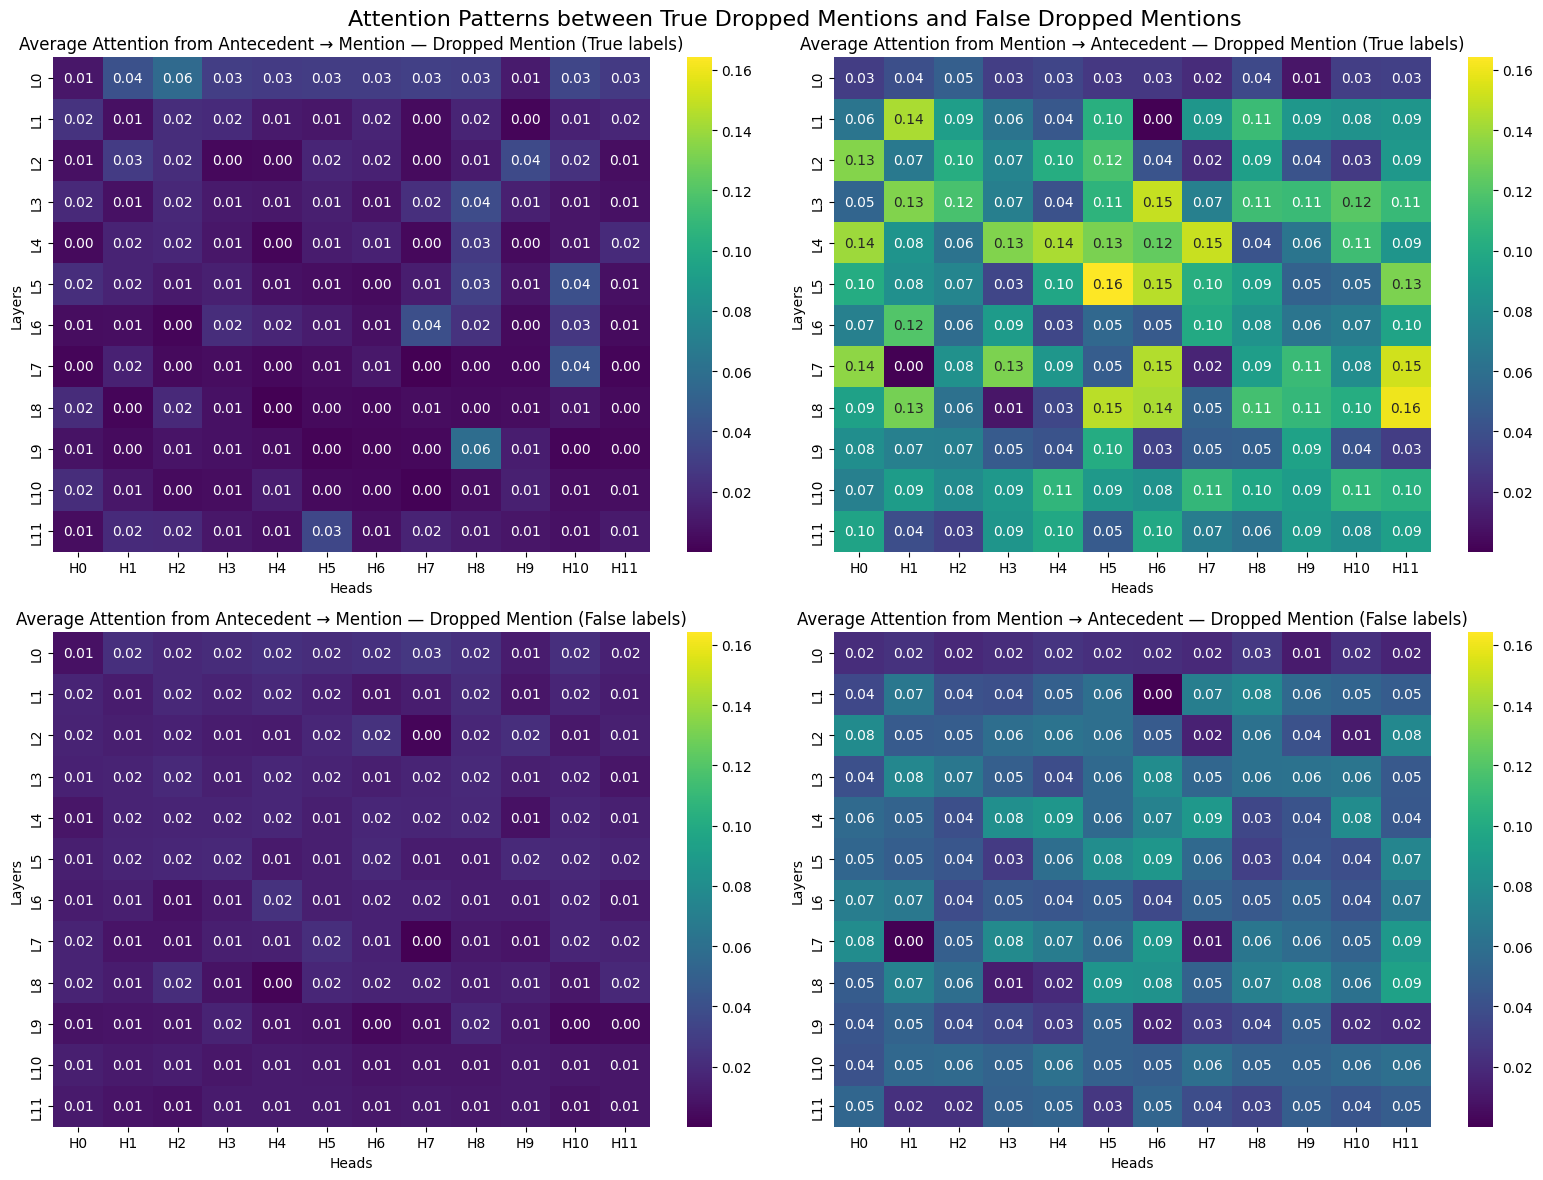

model name: m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0


Processing: 100%|██████████| 652/652 [01:13<00:00,  8.87sample/s]


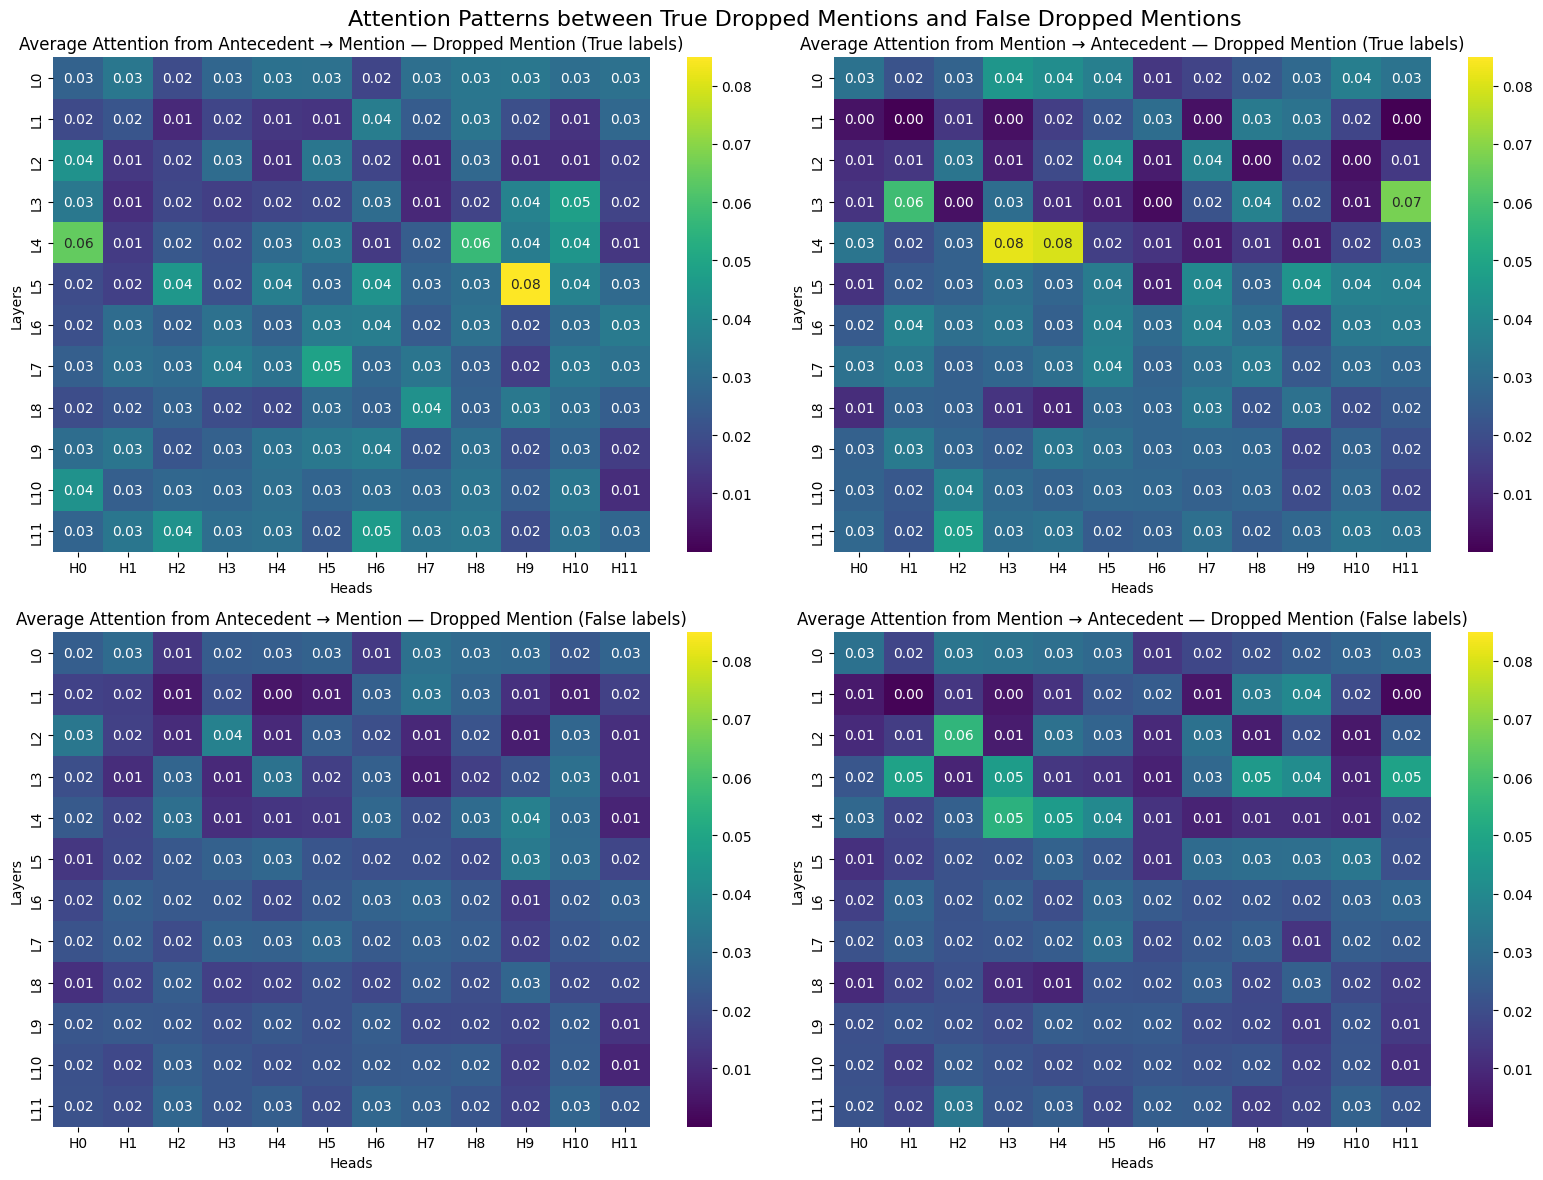

In [9]:
## attention pattern between True and False dropped mentions (True/False dropped mentions dataset)

for m in model_pairs[1:]:

    model_name = m[0]
    print(f"model name: {model_name}")
    tokenizer = m[1]
    model = m[2]

    num_layers = model.config.num_hidden_layers
    num_heads = model.config.num_attention_heads

    average_attention_split(df_tf_true_drop,df_tf_false_drop,"Dropped Mention (True labels)","Dropped Mention (False labels)","Attention Patterns between True Dropped Mentions and False Dropped Mentions")

**Visualisation of attention patterns between antecedent and mention (in both directions) in dataframe containing dropped mentions examples:** <br>
**Comparison of True and False dropped mentions**

This visualisation is carried out in order to understand whether any verb activates attention towards the sentence in general, or if a verb can be seen as a mention in cases where the mention is dropped. In the first case, the activation patterns should be the same for verbs which have in their scope a dropped mention, thus referring back to an antecedent, and verbs which are not related to a mention which refers back to an antecedent. 

Once again, the two **UmBERTo** models behave very similarly. They present almost null activation patterns in the antecedent to mention (==verb) direction, in both the cases of a true and false mention. What is interesting to note is that both models have an extremely low activation in the final layers in the antecedent to mention activation for false mention cases. For what concerns the other direction, i.e., mention to antecedent, there appears a very visible difference in the attention scores and activation patterns between true dropped mentions and false dropped mentions: in the case of true dropped mentions attention is relatively high (peaks at 0.15 and 0.12 for UmBERTo from CommonCrawl and from Wikipedia respectively) and very distributed throughout the model, while activation remains notably low for false dropped mention cases (peaks at 0.08 and 0.07 respectively). <br>
**GilBERTo** shows the same pattern as the previous two models, with slight changes in scores. The activation in the antecedent to mention attention is basically null for both cases; while in the other direction, i.e., mention to antecedent, the activation is stronger and more diffused in true mention cases, and notably less so, in false mention cases: peaks at 0.16 for true cases and only at 0.09 for false cases. <br>
**AlBERTo** also gives an interesting picture, even though it has attention peaks that are lower than the other models. In the cases of true mentions, attention in both directions seems to be active, with some specific targeted heads located in the early layers and peaks at 0.08. Attention seems to be active also in false cases in both directions, with peaks at 0.04 and 0.06 for the two directions.

<h4>Visualisation of attention through attention matrices (summary)</h4>

In the previous section I proposed a visualisation of attention between two tokens via an attention matrix, i.e., a matrix that shows the model's layers (rows) and heads (columns) and the attention score, from 0.0 to 1.0, that a token pays to another token in the sequence in each layer and head. A higher attention score correlates with the token being paid attention to having more relevance in the interpretation of the token that is paying attention to it. This means that by exploring in which layers attention is higher between two tokens that share a particular relationship we could understand how and where a model processes certain kinds of linguistic relationships.

I proposed attention matrices for each of the four Italian models, a comparison between differences and similarities in the patterns produced might shed some light on their specific inner workings. In all the matrices I proposed attention is shown in the two possible directions, i.e., attention from an antecedent to a mention, and attention from a mention to an antecedent. I also tested different distributions of the data and propose their visualisation: 
- attention in a dataframe with only true labels: this was carried out in order to visualise the difference between the patterns coming from the two directions of attention, i.e., attention from an antecedent to a mention, and attention from a mention to an antecedent;
- attention in dataframe with only true labels comparing non-dropped and dropped mentions: this was carried out in order to visualise whether there exists a significant difference between the patterns of non-dropped mentions, which are marked on NPs, and dropped mentions, which are marked onto the verb which would have the dropped mention in its scope. Similar patterns between the two distributions could suggest that a verb with a dropped mention in its scope behaves similarly to a present mention, thus using a verb, and maybe its morphology, to create a coreference chain with an antecedent;
- attention in dataframe with true and false balanced labels comparing true and false mentions: this was carried out in order to visualise whether there exists a difference between a true antecedent-mention pair and a false antecedent-mention pair. The hypothesis is that a true antecedent-mention pair will have higher attention scores and a clearer pattern of activation as the false counterpart since the existence of a true coreference chain should activate, in the models, mechanisms that link the mention to the antecedent. If no difference existed, it could be hypothesised that the model would encounter difficulties in determining whether a mention stands in a coreference relationship to an antecedent or not;
- attention in dataframe with only dropped mentions comparing true and false dropped mentions: this was carried out in order to visualise whether all verbs, irrespective of whether they contain in their scope a true or false dropped mention, behave in the same way activating the same attention patterns. If there existed no difference between the two distributions, it would mean that the model treats all verbs in the same way, however, if a difference existed, it could suggest that verbs containing a true dropped mention in their scope could, in fact, be used by the model to create a coreference link with an antecedent.

A first clear pattern that emerges from the visualisations for all distributions is the fact that three out of four models, i.e., UmBERTo CommonCrawl, UmBERTo Wikipedia, and GilBERTo, show almost no activation in attention in the direction antecedent to mention, while showing consistent activation in the opposite direction, i.e., mention to antecedent. The same is not true for AlBERTo which, in all distributions analysed, shows consistent activation in both directions. <br>
Another difference which sets apart AlBERTo from the other models is the peak attention scores: while the other models reach peaks of \~0.15, AlBERTo never goes above 0.08. Moreover, while the three models show many heads active to the relation observed, resulting in an attention pattern diffused throughout the models' architectures (this is more visible for the two UmBERTo models and less so for GiLBERTo), AlBERTo usually has only very few active heads, making the attention between the two tokens way more localisable.

Analysing the results from comparing the different distributions three main observations can be made: 

1. when comparing true non-dropped mentions and true dropped mentions all models show higher attention scores between a mention and its antecedent if the mention is a dropped one, i.e., if the mention is a verb the attention to a previous true antecedent is higher than the attention between a NP mention and its antecedent;
2. when comparing true mention and false mentions, and when comparing true dropped-mention and false dropped-mentions all models show higher attention scores for true examples rather than for false example, even though in both cases the patterns are similar. This might suggest that models are able to differentiate between true and false mentions by assigning higher scores to the former ones;
3. the fact that when comparing true dropped mentions and false dropped mentions all models show higher attention scores for true examples rather than false ones might suggest that the model treats differently verbs which have a dropped mention in their scope that refers back to the antecedent than verbs that have a non-referring dropped mention in their scope. It is then possible that verbs containing a true dropped mention are used by the model to build a coreference chain when the NP mention is dropped.

<h3>Training a probing classifier</h3>

A probing classifier is trained on the representations from a specific part in the model's architecture (often the last layer, which gives the final representation that the model builds of an input sentence). <br>
In the next section I train a probing classifier using the last hidden states of the model, i.e., the representations from the last layer. In the training process, the probing classifier has access to the target sentence, the antecedent and mention pair, and the label indicating whether the mention is true or false: with these information the classifier learns to differentiate between true and false mentions depending on the representations extracted in the last layer. When tested on a split of the data not seen during training, the classifier has to guess the whether the mention is true or false given a sentence and an antecedent-mention pair. If the model correctly encodes a difference between true and false antecedent-mention pairs it will have a high score when tested on the dataset; on the other case, if the model does not manage to capture this difference, it will have low scores when tested on the dataset. If a high score is obtained, further explorations, like cosine similarity between antecedent and mention pairs can be carried out. 

In [5]:
## transform dataframe into dataset for integration in training pipeline

from datasets import Dataset

coref_dataset = Dataset.from_pandas(coref_df_tf) 
coref_dataset

Dataset({
    features: ['text', 'antecedent_offset', 'antecedent', 'mention_offset', 'mention', 'label', 'label_str', 'dropped_subject', 'dropped_subject_str', 'similarity-lst-UmBERToCC', 'similarity-l11-UmBERToCC', 'similarity-avg-UmBERToCC', 'similarity-lst-UmBERToW', 'similarity-l11-UmBERToW', 'similarity-avg-UmBERToW', 'similarity-lst-GilBERTo', 'similarity-l11-GilBERTo', 'similarity-avg-GilBERTo', 'similarity-lst-AlBERTo', 'similarity-l11-AlBERTo', 'similarity-avg-AlBERTo'],
    num_rows: 4258
})

model name: Musixmatch/umberto-commoncrawl-cased-v1


Extracting features: 100%|██████████| 4258/4258 [07:13<00:00,  9.82it/s]


              precision    recall  f1-score   support

           0       0.71      0.73      0.72       429
           1       0.72      0.70      0.71       423

    accuracy                           0.71       852
   macro avg       0.71      0.71      0.71       852
weighted avg       0.71      0.71      0.71       852

Number of correct predictions: 609
Number of incorrect predictions: 243


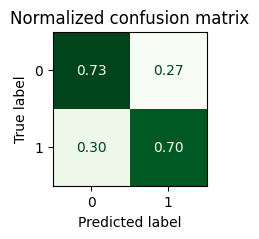

------------------------------------------------------------------------------------
model name: Musixmatch/umberto-wikipedia-uncased-v1


Extracting features: 100%|██████████| 4258/4258 [08:04<00:00,  8.79it/s]


              precision    recall  f1-score   support

           0       0.68      0.72      0.70       429
           1       0.70      0.66      0.68       423

    accuracy                           0.69       852
   macro avg       0.69      0.69      0.69       852
weighted avg       0.69      0.69      0.69       852

Number of correct predictions: 589
Number of incorrect predictions: 263


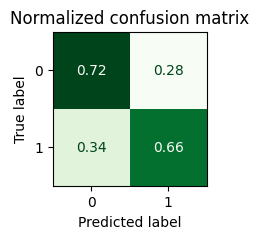

------------------------------------------------------------------------------------
model name: idb-ita/gilberto-uncased-from-camembert


Extracting features: 100%|██████████| 4258/4258 [07:55<00:00,  8.95it/s]


              precision    recall  f1-score   support

           0       0.70      0.73      0.72       429
           1       0.72      0.69      0.70       423

    accuracy                           0.71       852
   macro avg       0.71      0.71      0.71       852
weighted avg       0.71      0.71      0.71       852

Number of correct predictions: 604
Number of incorrect predictions: 248


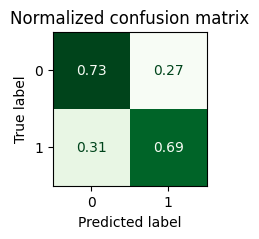

------------------------------------------------------------------------------------
model name: m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0


Extracting features: 100%|██████████| 4258/4258 [06:51<00:00, 10.36it/s]


              precision    recall  f1-score   support

           0       0.66      0.67      0.67       429
           1       0.66      0.65      0.66       423

    accuracy                           0.66       852
   macro avg       0.66      0.66      0.66       852
weighted avg       0.66      0.66      0.66       852

Number of correct predictions: 565
Number of incorrect predictions: 287


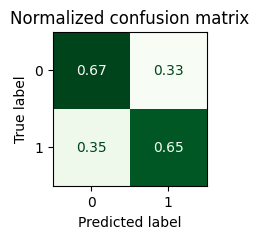

------------------------------------------------------------------------------------


In [11]:
## train probing classifier and visualise performance

## confusion matrix function 

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true,labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(2, 2))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0","1"])
    disp.plot(cmap="Greens", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()


## build representations function
## feature extraction function

from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import torch

def get_reps(example):
    text = example['text']
    men_offset = example['mention_offset']
    ant_offset = example['antecedent_offset']

    enc = tokenizer(text, return_offsets_mapping=True, return_tensors="pt")
    ids = enc['input_ids']
    offsets = enc['offset_mapping'][0]

    with torch.no_grad():
        reps = model(**{k: v for k, v in enc.items() if k!='offset_mapping'})
        hidden = reps.hidden_states[-1][0]  # last layer

    def find_rep(char_offset):
        idx = next(i for i,(s,e) in enumerate(offsets) if s <= char_offset < e)
        return hidden[idx]

    men = find_rep(men_offset)
    ant = find_rep(ant_offset)

    return {
        'men': men,
        'ant': ant,
        'lab': int(example['label'])
    }


def extract_features(dataset):
    features, labels = [], []
    for ex in tqdm(dataset, desc="Extracting features"):
        reps = get_reps(ex) 
        men = reps['men']
        ant = reps['ant']
        lab = reps['lab']
        features.append(torch.cat([men, ant]).numpy())
        labels.append(lab)

    return features, labels



## train probing classifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

summary_report = []
per_model_examples = {}  # store best/worst per model

for m in model_pairs[1:]:

    model_name = m[0]
    print(f"model name: {model_name}")
    tokenizer = m[1]
    model = AutoModel.from_pretrained(model_name, output_hidden_states=True)

    num_layers = model.config.num_hidden_layers
    num_heads = model.config.num_attention_heads

    model.eval()

    all_indices = np.arange(len(coref_dataset)) # array of original indices 
    #X_train, y_train = extract_features(train_data)
    #X_test, y_test = extract_features(test_data)
    features, labels = extract_features(coref_dataset)
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split( # keep indices for error analysis
        features, labels, all_indices, test_size=0.2, random_state=42 # if using only one split 
    )    
    #clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
    clf = make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=2000, solver='lbfgs') # upped max_iter becase it was not converging
    )
    clf.fit(X_train, y_train)

    y_preds = clf.predict(X_test)

    # get confidence scores (probability of predicted class)
    if hasattr(clf, "predict_proba"):
        probs = clf.predict_proba(X_test)  # shape (n_samples, n_classes)
        # confidence == max probability per example
        confidences = np.max(probs, axis=1)
    else:
        # fallback: use decision function and map to pseudo-confidence
        decision = clf.decision_function(X_test)
        confidences = 1 / (1 + np.exp(-np.abs(decision)))  # squash to [0.5,1)

    correct_mask = (y_preds == y_test)
    incorrect_mask = ~correct_mask

    # indices
    correct_idx = np.where(correct_mask)[0]
    incorrect_idx = np.where(incorrect_mask)[0]

    # sort by confidence
    best_correct = sorted(correct_idx, key=lambda i: confidences[i], reverse=True)[:5]
    worst_incorrect = sorted(incorrect_idx, key=lambda i: confidences[i], reverse=True)[:5]
    # low-confidence correct (closest to 0.5)
    lowconf_correct = sorted(correct_idx, key=lambda i: abs(confidences[i] - 0.5))[:5]

    per_model_examples[model_name] = {
        "best_correct": best_correct,
        "worst_incorrect": worst_incorrect,
        "lowconf_correct": lowconf_correct,
        "y_test": y_test,
        "y_preds": y_preds,
        "confidences": confidences,
        "X_test": X_test,
        "idx_test": idx_test,  
    }


    # print results of probing classifier
    print(classification_report(y_test, y_preds))
    summary_report.append({
        'model': model_name,
        'report': classification_report(y_test, y_preds, output_dict=True)
    })

    # visualise performance with confusion matrix    
    # find correct and incorrect predictions
    correct_indices = np.where(y_preds == y_test)[0] # gives out an array with indices
    incorrect_indices = np.where(y_preds != y_test)[0]
    
    print(f"Number of correct predictions: {len(correct_indices)}")
    print(f"Number of incorrect predictions: {len(incorrect_indices)}")
    
    plot_confusion_matrix(y_preds, y_test, labels=[0,1])

    
    print("------------------------------------------------------------------------------------")

In [16]:
## dummy classifier (most frequent class)

from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

X = X_test 
y = y_test 

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X, y)
y_pred = dummy.predict(X)

print(classification_report(y, y_pred, zero_division=0))
summary_report.append({
        'model': "dummy classifier",
        'report': classification_report(y, y_pred, zero_division=0, output_dict=True)
    })

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       429
           1       0.00      0.00      0.00       423

    accuracy                           0.50       852
   macro avg       0.25      0.50      0.33       852
weighted avg       0.25      0.50      0.34       852



In [13]:
## print summary of performances

print("summary of performances (f-1 scores)")
print(f"{'model':65} {'accuracy':>8}")
print("-" * 75)
for entry in summary_report:
    name = entry['model']
    acc = entry['report']['accuracy']
    print(f"{name:65} {acc:8.2f}")

summary of performances (f-1 scores)
model                                                             accuracy
---------------------------------------------------------------------------
Musixmatch/umberto-commoncrawl-cased-v1                               0.71
Musixmatch/umberto-wikipedia-uncased-v1                               0.69
idb-ita/gilberto-uncased-from-camembert                               0.71
m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0        0.66
dummy classifier                                                      0.50


The probing classifier shows good results for all models, way above the results gotten by the dummy classifier (strategy: predict the most frequent class) which reaches an accuracy of 0.50, i.e., chance level. The first three models (UmBERTo CC, UmBERTo W, and GilBERTo) reach similar scores (accuracy ~0.70) with AlBERTo performing slightly worse (accuracy of 0.66). <br>
In the following cell I show, for each model, cases in which confidence is high (both for correct and incorrect predictions) and cases in which confidence is low but prediction was still correct. This might help in understanding whether some examples skewed predictions, and eventually in cleaning the dataframe more. 

In [14]:
def build_examples_df(per_model_examples, coref_dataset):
    all_rows = []
    for model_name, ex in per_model_examples.items():
        for tag in ["best_correct", "worst_incorrect", "lowconf_correct"]:
            for i in ex[tag]:
                orig_idx = int(ex["idx_test"][i])
                row = coref_dataset[orig_idx]
                all_rows.append({
                    "model": model_name,
                    "tag": tag,
                    "text": row["text"],
                    "antecedent": row["antecedent"],
                    "mention": row["mention"],
                    "dropped_subject": row["dropped_subject"],
                    "true_label": ex["y_test"][i],
                    "pred_label": ex["y_preds"][i],
                    "confidence": ex["confidences"][i],
                })
    return pd.DataFrame(all_rows)

df_examples = build_examples_df(per_model_examples, coref_dataset)
df_examples.head(50)

current_model = ""
for i,row in df_examples.iterrows():
    m_name = row['model']
    if m_name == current_model or m_name == "":
        if m_name == "":
            print(f"Model name: {m_name}\n")
            current_model = m_name
        print(f"Sentence: {row['text']}")
        print(f"antecedent-mention: {row['antecedent']}-{row['mention']}")
        print(f"tag: {row['tag']}, true label: {row['true_label']}, pred: {row['pred_label']}, conf: {row['confidence']:.2f}")
        print("-----------------")
    else: 
        print(f"\n\nModel name: {m_name}\n")
        current_model = m_name



Model name: Musixmatch/umberto-commoncrawl-cased-v1

Sentence: Ma anche a questo riguardo bisogna dire che le Alpi, grazie alla configurazione del territorio, sono state per secoli il rifugio di una minoranza, la comunità valdese, che era sorta a Lione, ma ne era dovuta fuggire a causa delle persecuzioni.
antecedent-mention: la comunità valdese-ne
tag: best_correct, true label: 0, pred: 0, conf: 1.00
-----------------
Sentence: Il matrimonio con Olga Khokhlova si concluse in una separazione anziché in un divorzio perché secondo le leggi francesi un divorzio avrebbe significato dividere equamente le proprietà della coppia tra i due coniugi, cosa che Picasso non volle fare.
antecedent-mention: una separazione-un divorzio
tag: best_correct, true label: 0, pred: 0, conf: 1.00
-----------------
Sentence: Nel 1928 va a New York, dove tiene varie mostre personali, realizza varie ambientazioni di ristoranti, crea scenografie e costumi per vari teatri e molte coreografie.
antecedent-mention: 

From the analysis of the high confidence in correct cases I noticed how many examples showed antecedents that overlapped completely with the mention, or that contained the mention. This was also confirmed by running cosine similarity, in fact many examples in the true cases reached scores of 1 (perfect similarity). For this reason these examples were pruned from the data. <br>
A visual analysis of some of the examples after pruning does not highlight other major problems or skews in the data.

<h3>Cosine similarity</h3>

In this next section I explore the cosine similarity between antecedents and true and false mentions. Closeness in vector space is taken to be index of similarity between the model's representations and cosine similarity is a score that tells how close in vector space two vector representations are: the closer they are, the closer the score is to 1.00; the further away they are; the closer the score is to -1.00. A score of 1.00 indicates perfect similarity and is reached by two words that are the same word. <br>
I calculate cosine similarity scores from different representations extracted from different parts of the model, namely:

1. from the last layer, i.e., the final representation that the model builds of an input;
2. from the 11th layer, i.e., the representation that the model builds before the last one since the model, in the final representation, might drop other too specific relationships to gather again a more general representation of the sentence overall before passing it to an eventual classifier;
3. from an average of the embeddings from all layers in the model, i.e., all representations computed by the model at each layer are summed between themselves and averaged so that the cosine similarity reflects how the model perceives the target words in a more general manner.

The cosine similarity scores extracted from the three loci described above are extracted and compared from different splits of the original dataframe in order to see whether there exists a statistically relevant difference between different distributions of the data. These are:

1. True mentions vs False mentions: explored in order to see whether there is a statistically relevant difference between true and false examples overall. The model should, in fact, perceive with a higher cosine similarity score a true antecedent-mention pair rather than a false one. 
2. Non-Dropped mentions vs Dropped mentions: explored in order to see whether present mentions, i.e., NPs mentions, are treated in similar ways to dropped mentions, i.e., verbs that have in their scope a dropped NP mention. If no statistically relevant difference is found between the distributions of the two scores it means that the model perceives in the same way a present NP mention and a verb which has a dropped mention in its scope. 
3. True Dropped mentions vs False Dropped mentions: explored in order to see whether the model actually distinguishes between verbs that have a true dropped mention in their scope and verbs that have a false one. If there exists a statistically significant difference between the cosine similarity scores of these two distributions, and a higher score is assigned to the former class, it would mean that the model correctly distinguishes between true and false dropped mentions, thus possibly validating the results from point 2 above.

I extract the scores from the three loci described above and propose visualisations for the three splits described above for all four Italian models.

In [5]:
## functions for calculating and displaying cosine similarity

import torch
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def find_token_indices(tokenised_sentence, tokenised_target):
    """
    Finds token index or indices in cases where the word was divided into subunits.
    """
    for i in range(len(tokenised_sentence) - len(tokenised_target) + 1):
        if tokenised_sentence[i:i+len(tokenised_target)] == tokenised_target:
            return list(range(i, i+len(tokenised_target)))
    return None


def compare_matrices(mat1, mat2, tokens1, tokens2, title1="Method 1", title2="Method 2", annot=True):
    """
    Plots two plots side by side for comparison.
    It gets two matrices as arguments, the tokens for the two matrices, the titles for the two matrices.
    """
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    sns.heatmap(mat1, xticklabels=tokens1, yticklabels=tokens1, annot=annot, fmt=".2f", cmap="GnBu", ax=axs[0])
    axs[0].set_title(title1)

    sns.heatmap(mat2, xticklabels=tokens2, yticklabels=tokens2, annot=annot, fmt=".2f", cmap="GnBu", ax=axs[1])
    axs[1].set_title(title2)

    plt.tight_layout()
    plt.show()



def cosine_sim_matrix_single(tokenizer, model, sentence, show_plot=False, annot=True):
    """
    Takes a single sentence and gives a matrix graph with cosine similarity scores between all tokens (last hidden state).
    """
    model.eval()
    
    tokens_list = []
    
    # tokenise (return_tensors for batching)
    inputs = tokenizer(sentence.lower(), return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze())
    tokens_list = tokens[0:(len(tokens))] # add tokens to list (avoid special tokens); to include special tokens: tokens[0:(len(tokens))]

    # run model
    with torch.no_grad():
        outputs = model(**inputs)
    
    # get last hidden states
    last_hidden = outputs.last_hidden_state.squeeze(0)  # shape: (seq_len, hidden_dim)
    
    # initialise empty matrix 
    n = len(tokens_list)
    sim_matrix = np.zeros((n, n)) 
    
    for i, e1 in enumerate(tokens_list):
        for j, e2 in enumerate(tokens_list):
            # extract indices
            idx_1 = tokens.index(e1)
            idx_2 = tokens.index(e2)
            # extract embeddings
            vec_1 = last_hidden[idx_1]
            vec_2 = last_hidden[idx_2]
            # calculate cosine similarity
            sim_matrix[i][j] = F.cosine_similarity(vec_1, vec_2, dim=0).item()
    
    # plot heatmap
    if show_plot:    
        plt.figure(figsize=(10, 8))
        sns.heatmap(sim_matrix, xticklabels=tokens_list, yticklabels=tokens_list, annot=annot, fmt=".2f", cmap="Greens", vmin=0.0, vmax=1.0)
        plt.title("Cosine Similarity between Tokens")
        plt.show()
    
    return sim_matrix


def cosine_sim_across(tokenizer, model, sentence, word1, word2, show_plot=False):
    """
    Takes a single sentence and gives a graph showing cosine similarity through layers between two selected words.
    """
    model.eval()
    
    # tokenise (return_tensors for batching)
    inputs = tokenizer(sentence.lower(), return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze())
    
    # run model: get all hidden states (13 total: embedding + 12 layers)
    with torch.no_grad():
        outputs = model(**inputs)
        hidden_states = outputs.hidden_states  # tuple of len 13 for layers: 0 is embedding layer, 1-12 are transformer layers. each element has shape: (batch_size(1), seq_len, hidden_dim(768))
        # hidden_states[0] # gives embedding layer
        # hidden_states[12] # gives what .last_hidden_state gives 
    
    # locate the indices of word1 and word2
    tok1 = tokenizer.tokenize(word1.lower())
    tok2 = tokenizer.tokenize(word2.lower())
    idx_1 = find_token_indices(tokens,tok1)
    idx_2 = find_token_indices(tokens,tok2)
    
    # store scores across layers 
    similarities = []
    
    for layer in range(1, len(hidden_states)):  # skip layer 0 (embedding layer)
        layer_output = hidden_states[layer].squeeze(0)  # shape: (seq_len, hidden_dim)
        vec_1 = layer_output[idx_1].mean(dim=0)  # for multi-element words
        vec_2 = layer_output[idx_2].mean(dim=0)
        sim = F.cosine_similarity(vec_1, vec_2, dim=0).item()
        similarities.append(sim)

    # plot
    if show_plot:
        plt.plot(range(1, 13), similarities, marker='o')
        plt.ylim(-1.0, 1.0)
        plt.axhline(0.0, color='red', linestyle='--', linewidth=1)
        plt.xlabel(f"Model Layer ({model_name})")
        plt.ylabel(f"Cosine Similarity ('{word1}' vs. '{word2}')")
        plt.title("Cosine Similarity Across Layers")
        plt.xticks(range(1, 13))
        plt.grid(True)
        plt.show()
        
        print(f"Average cosine similarity between '{word1}' and '{word2}' (avg of per-layer similarities): {np.mean(similarities):.4f}")

    return similarities
        

def cosine_sim_matrix_average_sim(tokenizer, model, sentence, show_plot=False):
    """
    Takes a single sentence and gives a matrix graph with cosine similarity scores between all tokens averaged from all layers.
    ! It computes the similarities between tokens, THEN averages the similarities. !
    Returns a similarity matrix and tokens to be plotted side by side for comparison.
    """
    model.eval()
    
    tokens_list = []
    
    # tokenise (return_tensors for batching)
    inputs = tokenizer(sentence.lower(), return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze())
    tokens_list = tokens[0:(len(tokens))] # add tokens to list (avoid special tokens); to include special tokens: tokens[0:(len(tokens))]
    
    # run model: get all hidden states (13 total: embedding + 12 layers)
    with torch.no_grad():
        outputs = model(**inputs)
        hidden_states = outputs.hidden_states  # tuple of len 13 for layers: 0 is embedding layer, 1-12 are transformer layers. each element has shape: (batch_size(1), seq_len, hidden_dim(768))
        # hidden_states[0] # gives embedding layer
        # hidden_states[12] # gives what .last_hidden_state gives 
    
    # initialise empty matrix 
    n = len(tokens_list)
    sim_matrix = np.zeros((n, n)) 
    
    # compute cosine similarity per layer and average
    for i in range(n):
        for j in range(n):
            similarities = []
    
            for layer in range(1, len(hidden_states)):  # skip layer 0
                layer_output = hidden_states[layer].squeeze(0)  # shape: (seq_len, hidden_dim)
                vec_1 = layer_output[i]
                vec_2 = layer_output[j]
                sim = F.cosine_similarity(vec_1, vec_2, dim=0).item()
                similarities.append(sim)
    
            sim_matrix[i][j] = np.mean(similarities)
    
    # plot heatmap
    if show_plot:
        plt.figure(figsize=(10, 8))
        sns.heatmap(sim_matrix, xticklabels=tokens, yticklabels=tokens, annot=True, fmt=".2f", cmap="GnBu", vmin=0.0, vmax=1.0)
        plt.title("Cosine Similarity Between Tokens (Avg. of Per-Layer Similarities)")
        plt.show()

    return sim_matrix, tokens

    
def cosine_sim_matrix_average_emb(tokenizer, model, sentence, show_plot=False):
    """
    Takes a single sentence and gives a matrix graph with cosine similarity scores between all tokens averaged from all layers.
    ! It averages the embeddings across layers, THEN computes the similarity. !
    Returns a similarity matrix and tokens to be plotted side by side for comparison.
    """
    model.eval()
    
    tokens_list = []
    
    # tokenise (return_tensors for batching)
    inputs = tokenizer(sentence.lower(), return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze())
    tokens_list = tokens[0:(len(tokens))] # add tokens to list (avoid special tokens); to include special tokens: tokens[0:(len(tokens))]
    
    # run model: get all hidden states (13 total: embedding + 12 layers)
    with torch.no_grad():
        outputs = model(**inputs)
        hidden_states = outputs.hidden_states  # tuple of len 13 for layers: 0 is embedding layer, 1-12 are transformer layers. each element has shape: (batch_size(1), seq_len, hidden_dim(768))
    
    # stack layers 1–12 (ignore layer 0) 
    layer_stack = torch.stack(hidden_states[1:], dim=0)  # shape: (12, 1, seq_len, 768)
    # average across layers 
    mean_rep = layer_stack.mean(dim=0) # shape: (1, seq_len, hidden_dim)
    # remove batch dimension
    mean_rep = mean_rep.squeeze(0) # shape: (seq_len, hidden_dim)
    
    # initialise empty matrix 
    n = len(tokens_list)
    sim_matrix = np.zeros((n, n)) 
    
    for i in range(len(tokens_list)):
        for j in range(len(tokens_list)):
            vec_1 = mean_rep[i]
            vec_2 = mean_rep[j]
            sim = F.cosine_similarity(vec_1, vec_2, dim=0).item()
            sim_matrix[i][j] = sim
    
    # plot heatmap
    if show_plot:
        plt.figure(figsize=(10, 8))
        sns.heatmap(sim_matrix, xticklabels=tokens, yticklabels=tokens, annot=True, fmt=".2f", cmap="GnBu", vmin=0.0, vmax=1.0)
        plt.title("Cosine Similarity Between Tokens (Avg. of Layers' Embeddings)")
        plt.show()

    return sim_matrix, tokens


def cosine_sim_single_average_emb(tokenizer, model, sentence, word1, word2, layers=range(1, 13), print_result=False):
    """
    Takes a single sentence and gives average cosine similarity score between two words.
    ! It averages the two embeddings across layers, THEN computes the similarity. !
    """
    model.eval()
    
    inputs = tokenizer(sentence.lower(), return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze())
    
    with torch.no_grad():
        outputs = model(**inputs)
        hidden_states = outputs.hidden_states
    
    tok1 = tokenizer.tokenize(word1.lower())
    tok2 = tokenizer.tokenize(word2.lower())
    idx_1 = find_token_indices(tokens, tok1)
    idx_2 = find_token_indices(tokens, tok2)
    
    # average across selected layers
    vec_1 = torch.stack([hidden_states[i].squeeze(0)[idx_1].mean(dim=0) for i in layers]).mean(dim=0)
    vec_2 = torch.stack([hidden_states[i].squeeze(0)[idx_2].mean(dim=0) for i in layers]).mean(dim=0)
    
    sim = F.cosine_similarity(vec_1, vec_2, dim=0).item()

    if print_result:
        print(f"Average cosine similarity between '{word1}' and '{word2}': {sim}")
    
    return sim
    

def cosine_sim_single(tokenizer, model, sentence, word1, word2, print_result=False):
    """
    Takes a single sentence and gives cosine similarity score between two selected words (last layer).
    """
    model.eval()
        
    # tokenise (return_tensors for batching)
    inputs = tokenizer(sentence.lower(), return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze())

    #run model
    with torch.no_grad():
        outputs = model(**inputs)
    
    # get last hidden states
    last_hidden = outputs.last_hidden_state.squeeze(0)  # shape: (seq_len, hidden_dim)

    # extract indices
    tok1 = tokenizer.tokenize(word1.lower())
    tok2 = tokenizer.tokenize(word2.lower())
    idx_1 = find_token_indices(tokens,tok1)
    idx_2 = find_token_indices(tokens,tok2) 
    # extract embeddings
    vec_1 = last_hidden[idx_1].mean(dim=0) # for multi-element words
    vec_2 = last_hidden[idx_2].mean(dim=0)
    
    # compute cosine similarity
    similarity = F.cosine_similarity(vec_1, vec_2, dim=0).item()
    if print_result:
        print(f"Cosine similarity between '{word1}' and '{word2}' (last layer): {similarity:.4f}")
    return similarity

    
def cosine_sim_single_layer(tokenizer, model, sentence, word1, word2, layer, print_result=False):
    """
    Takes a single sentence and gives cosine similarity score between two selected words (selected layer).
    """
    model.eval()
    
    # tokenise (return_tensors for batching)
    inputs = tokenizer(sentence.lower(), return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze())
    
    # run model: get all hidden states (13 total: embedding + 12 layers)
    with torch.no_grad():
        outputs = model(**inputs)
        #hidden_states_layer = outputs.hidden_states[layer]  # tuple of len 13 for layers: 0 is embedding layer, 1-12 are transformer layers. each element has shape: (batch_size(1), seq_len, hidden_dim(768))
        # hidden_states[0] # gives embedding layer
        # hidden_states[12] # gives what .last_hidden_state gives 
    
    # extract indices
    tok1 = tokenizer.tokenize(word1.lower())
    tok2 = tokenizer.tokenize(word2.lower())
    idx_1 = find_token_indices(tokens,tok1)
    idx_2 = find_token_indices(tokens,tok2) 
    # extract embeddings
    layer_output = outputs.hidden_states[layer].squeeze(0)
    vec_1 = layer_output[idx_1].mean(dim=0) # for multi-element words
    vec_2 = layer_output[idx_2].mean(dim=0)
    
    # compute cosine similarity
    similarity = F.cosine_similarity(vec_1, vec_2, dim=0).item()
    if print_result:
        print(f"Cosine similarity between '{word1}' and '{word2}' in layer {layer}: {similarity:.4f}")
    return similarity 

In [14]:
## function to draw graphs and statistics: boxplot, distribution bell, statistics
## plotted in an easy to read format (side by side for each model)

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import numpy as np
import pandas as pd

def plot_with_stats_below(df, sim_cols, model_name, label_spec):
    """
    Plots in a column: box-plot, KDE, statistics; it does so 3 times, one for each visualisation (last, layer 11, average).
    sim_cols is a list of tuples: (column_name, title_suffix)
    """
    column_name, val_1, val_2 = label_spec
    palette = {val_1: sns.color_palette()[1], val_2: sns.color_palette()[0]}
    n = len(sim_cols)
    #fig, axes = plt.subplots(3, n, figsize=(5 * n, 10), constrained_layout=True)
    fig, axes = plt.subplots(
        3, n,
        figsize=(5 * n, 10),
        constrained_layout=True,
        gridspec_kw={'height_ratios': [1.5, 1.5, 1]} 
    )

    for idx, (col, suffix) in enumerate(sim_cols):
        # subsets
        trueM = df[df[column_name] == val_1][col].dropna() # dropping examples which could not be worked
        falseM = df[df[column_name] == val_2][col].dropna()

        # stats
        mean_true, med_true = trueM.mean(), trueM.median()
        mean_false, med_false = falseM.mean(), falseM.median()
        if len(trueM) >= 2 and len(falseM) >= 2:
            t_stat, p_val = ttest_ind(trueM, falseM, nan_policy='omit', equal_var=False) # equal_var=False : Welch's t-test for groups with unequal variances
            mean_diff = mean_true - mean_false
            pooled_std = np.sqrt((trueM.std() ** 2 + falseM.std() ** 2) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std != 0 else np.nan
        else:
            t_stat, p_val, cohens_d = np.nan, np.nan, np.nan

        vmin, vmax = -0.3, 1.25 # keep min and max values fixed for all models and plots
        # row 1: boxplot
        ax_box = axes[0, idx]
        sns.boxplot(
            data=df,
            x=column_name,
            y=col,
            palette=palette,
            order=[val_2, val_1],
            ax=ax_box,
        )
        ax_box.set_title(f"{model_name} — {suffix}", fontsize=12)
        ax_box.set_xlabel("")
        ax_box.set_ylim(vmin, vmax)
        ax_box.set_ylabel("Cosine Similarity")

        # row 2: KDE
        ax_kde = axes[1, idx]
        sns.kdeplot(data=df[df[column_name] == val_2], x=col,
                    label=val_2, fill=True, ax=ax_kde)
        sns.kdeplot(data=df[df[column_name] == val_1], x=col,
                    label=val_1, fill=True, ax=ax_kde)
        ax_kde.set_xlabel("Cosine Similarity")
        ax_kde.set_ylabel("Density")
        ax_kde.set_xlim(vmin, vmax)
        ax_kde.legend(fontsize=8)

        # row 3: summary stats as a mini table (render via text)
        ax_stats = axes[2, idx]
        ax_stats.axis("off")
        stats_df = pd.DataFrame({
            "mean": [mean_true, mean_false],
            "median": [med_true, med_false]
            },
            index=[val_1, val_2]
        ).round(3)
        p_str = f"p < 0.001" if p_val < 0.001 else f"p = {p_val:.3f}"
        stats_text = (
            f"{stats_df.to_string()}\n"
            f"t = {t_stat:.2f}, {p_str}\n"
            f"Cohen's d = {cohens_d:.2f}"
        )
        ax_stats.text(0, 0.5, stats_text, va="center", ha="left", fontsize=12, family="monospace")

    fig.suptitle(f"Cosine Similarity Distributions + Summary for {model_name}", fontsize=16, y=1.02)
    plt.show()

In [ ]:
""" 
!! this is really long to run and crashes sometimes (because of unstable connection I think)
    it took ~15min per column per model, i.e., 3-col * 4-mod = ~3h
I run it for one model at a time and always saved the output so that if it crashed damages were contained
After running it I saved the dataframe locally with the added columns for cosine similarity
so the only needed step is to load the pre-processed dataframe at the beginning of this notebook
"""

## compute similarity across the dataset (add columns with similarity to dataset)
## i) last layer, ii) selected layer (11), iii) average 

from tqdm import tqdm

for m in model_pairs[1:]:
    model_name = m[0]
    model = AutoModel.from_pretrained(model_name, output_hidden_states=True)
    tokenizer = m[1]
    simple_name = m[3]
    
    print(f"Model name: {model_name}")
    
    # optional: if using CUDA
    #model = model.to("cuda")


    # i) last layer 
    coref_df_tf[f'similarity-lst-{simple_name}'] = 0.0
    skipped = 0
    
    for i, row in tqdm(coref_df_tf.iterrows(), total=len(coref_df_tf), desc="Computing similarities: last layer"):
        sentence = row['text']
        word1 = row['antecedent']
        word2 = row['mention']
    
        try:
            sim = cosine_sim_single(tokenizer, model, sentence, word1, word2)
        except Exception as e:
            sim = None  
            #print(f"Error at row {i}: {e}")
            skipped+=1
    
        coref_df_tf.at[i, f'similarity-lst-{simple_name}'] = sim
    print(f"Skipped examples: {skipped}")


    # ii) layer 11
    coref_df_tf[f'similarity-l11-{simple_name}'] = 0.0
    skipped = 0
    
    for i, row in tqdm(coref_df_tf.iterrows(), total=len(coref_df_tf), desc="Computing similarities: layer 11"):
        sentence = row['text']
        word1 = row['antecedent']
        word2 = row['mention']
    
        try:
            sim = cosine_sim_single_layer(tokenizer, model, sentence, word1, word2, 11)
        except Exception as e:
            sim = None  
            #print(f"Error at row {i}: {e}")
            skipped+=1
    
        coref_df_tf.at[i, f'similarity-l11-{simple_name}'] = sim
    print(f"Skipped examples: {skipped}")


    # iii) average (average embedding)
    coref_df_tf[f'similarity-avg-{simple_name}'] = 0.0
    skipped = 0
    
    for i, row in tqdm(coref_df_tf.iterrows(), total=len(coref_df_tf), desc="Computing similarities: average"):
        sentence = row['text']
        word1 = row['antecedent']
        word2 = row['mention']
    
        try:
            sim = cosine_sim_single_average_emb(tokenizer, model, sentence, word1, word2)
        except Exception as e:
            sim = None  
            #print(f"Error at row {i}: {e}")
            skipped+=1
    
        coref_df_tf.at[i, f'similarity-avg-{simple_name}'] = sim
    print(f"Skipped examples: {skipped}\n")

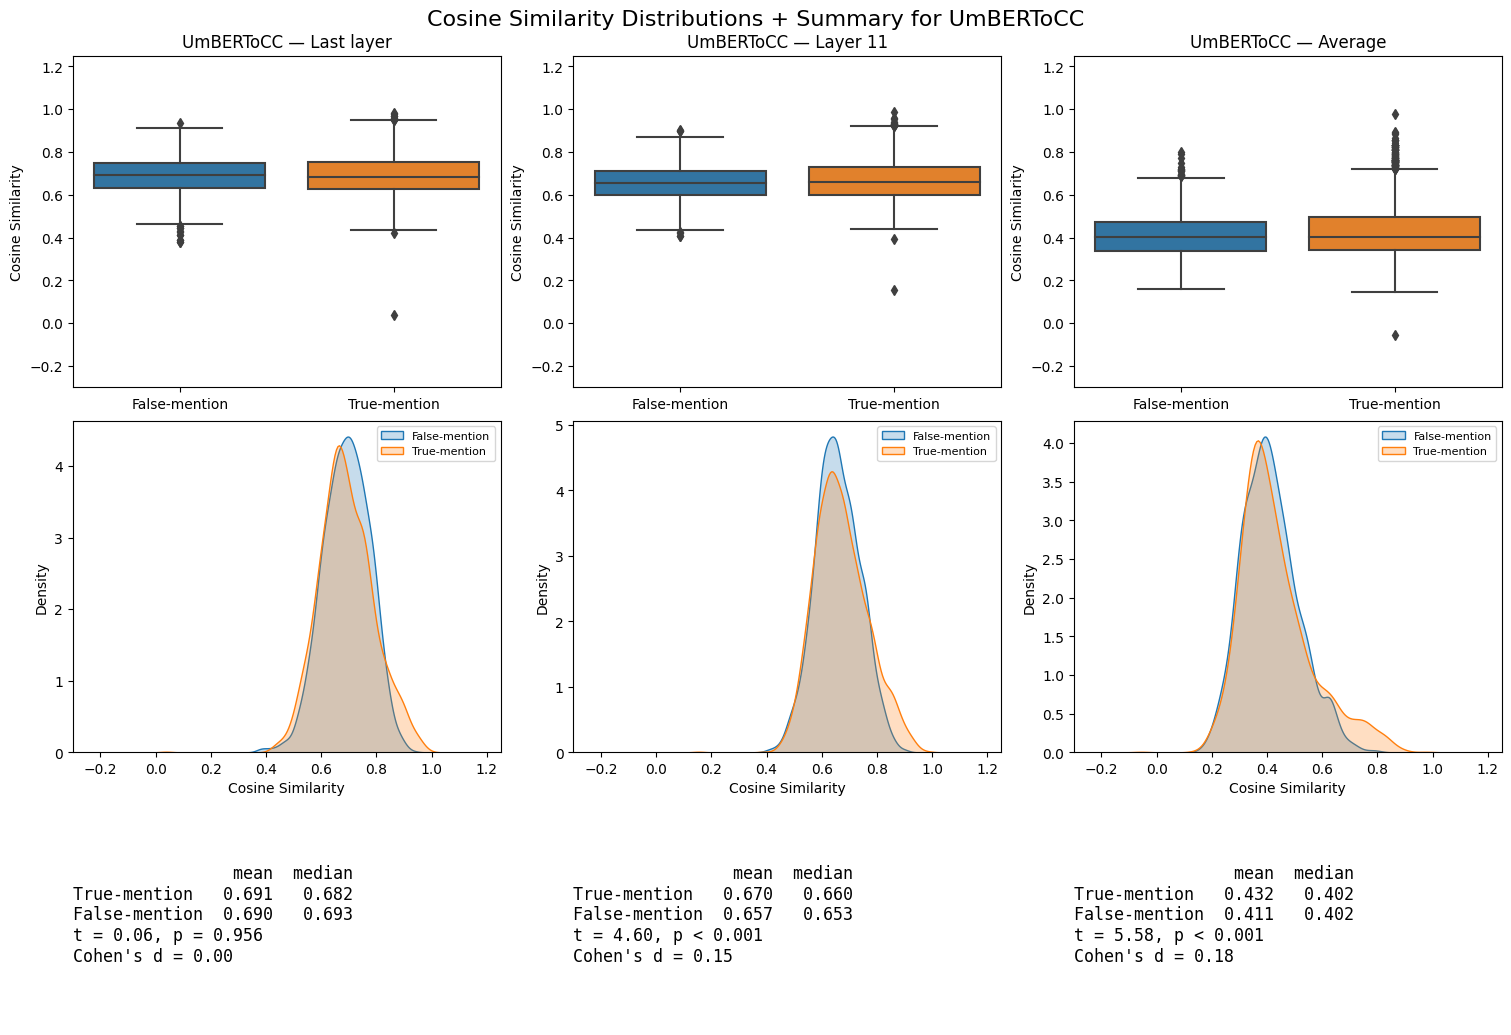

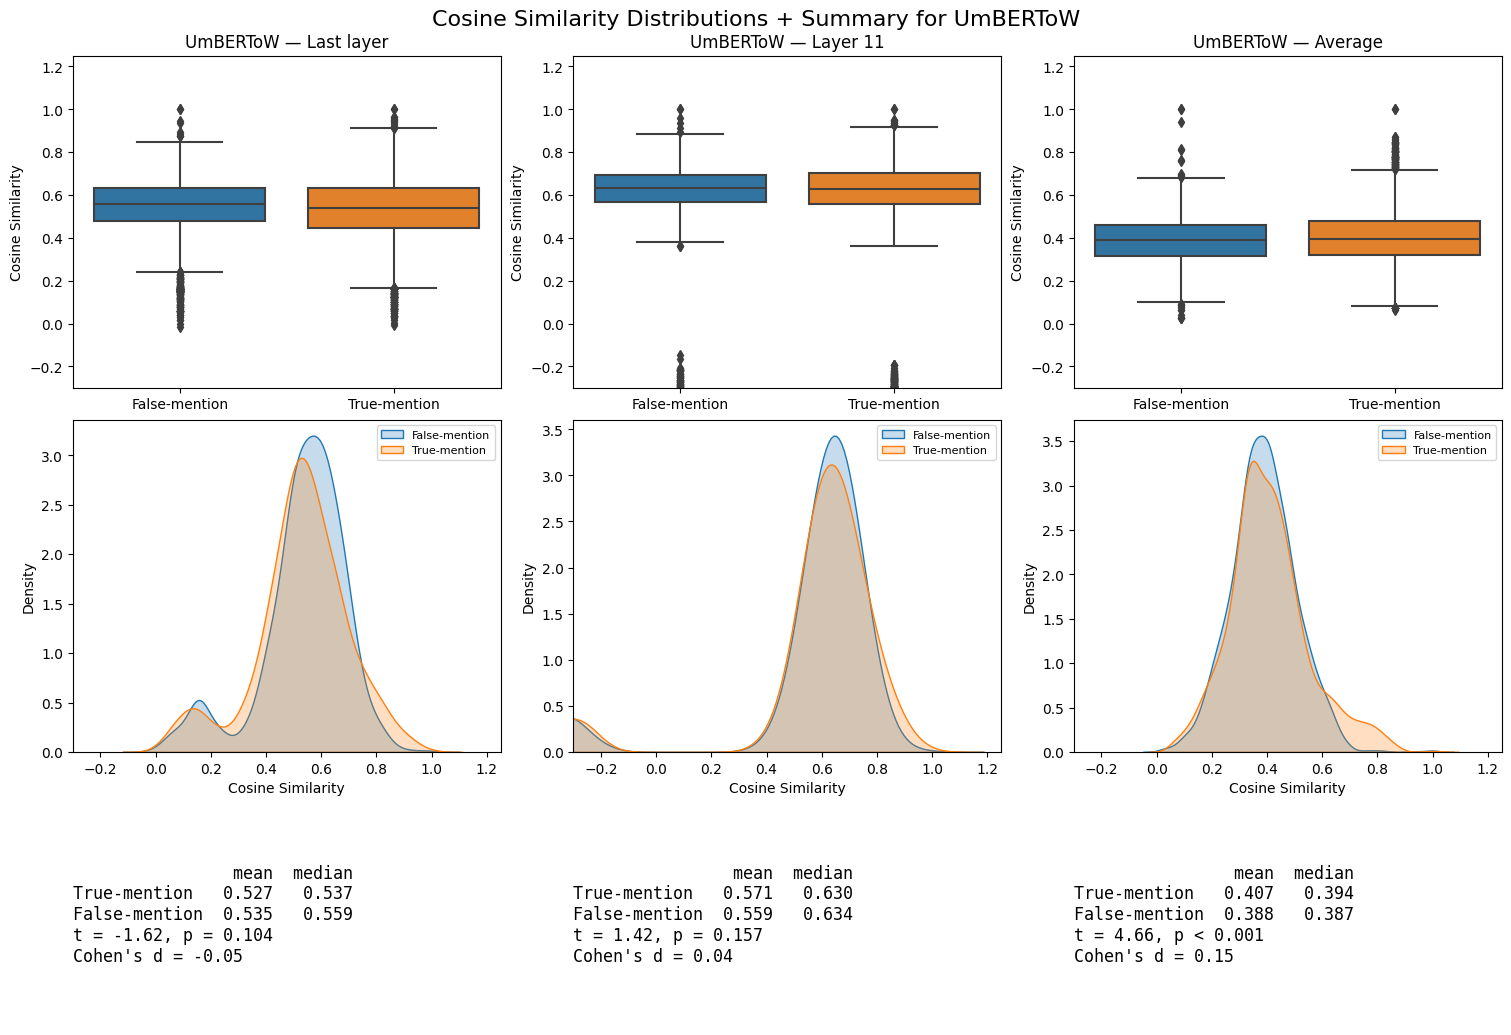

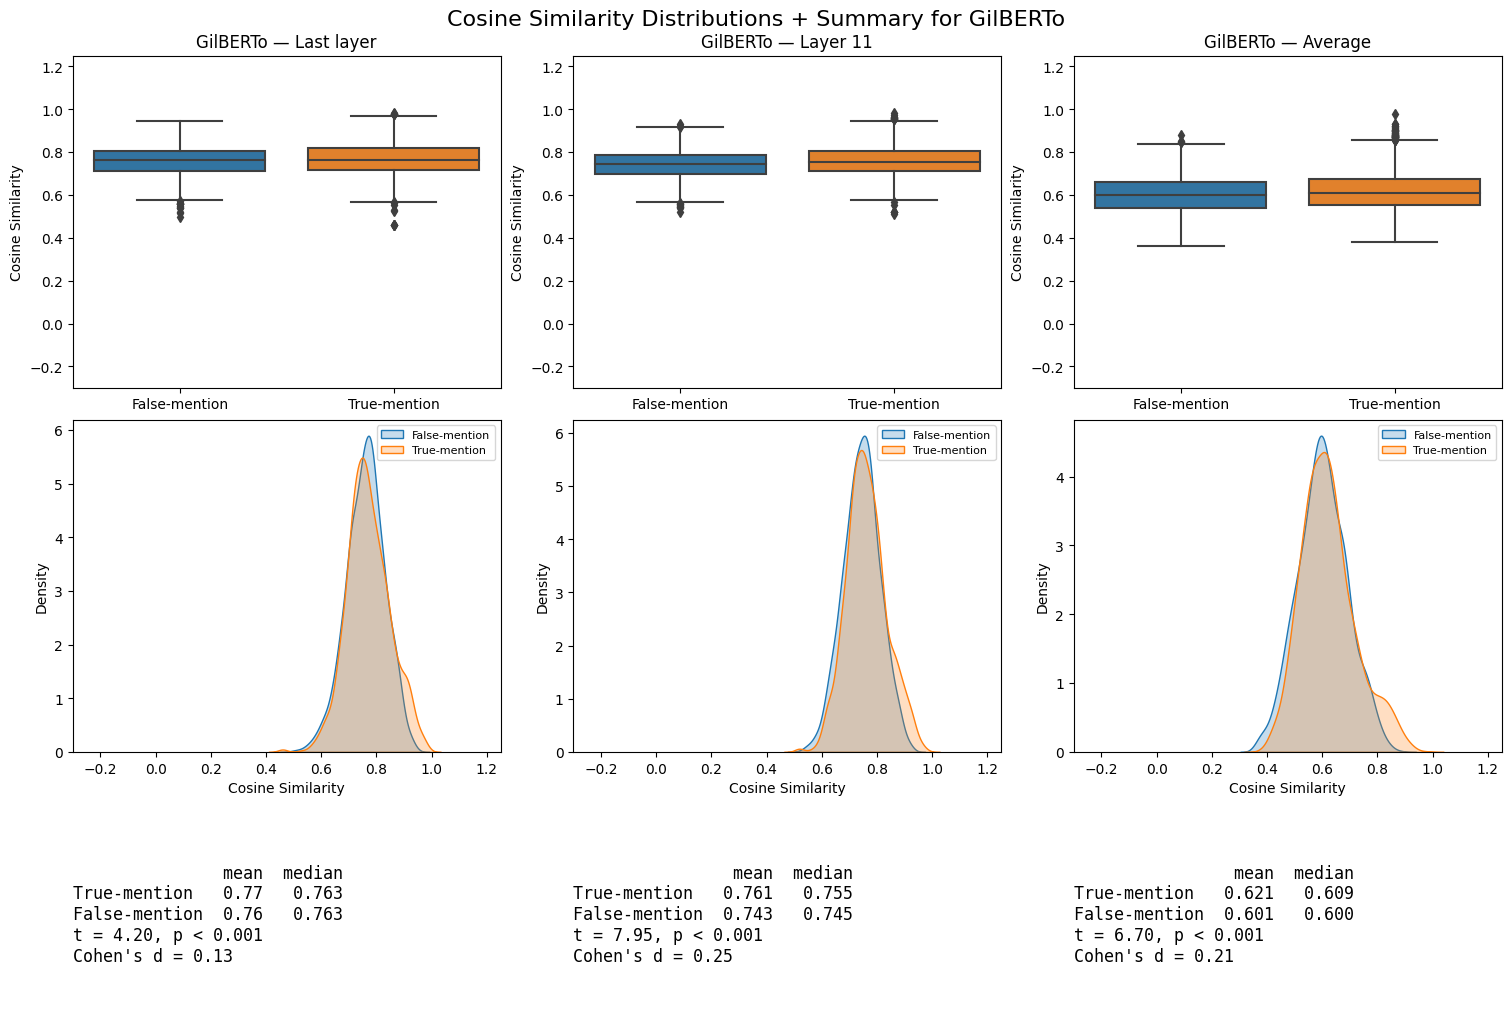

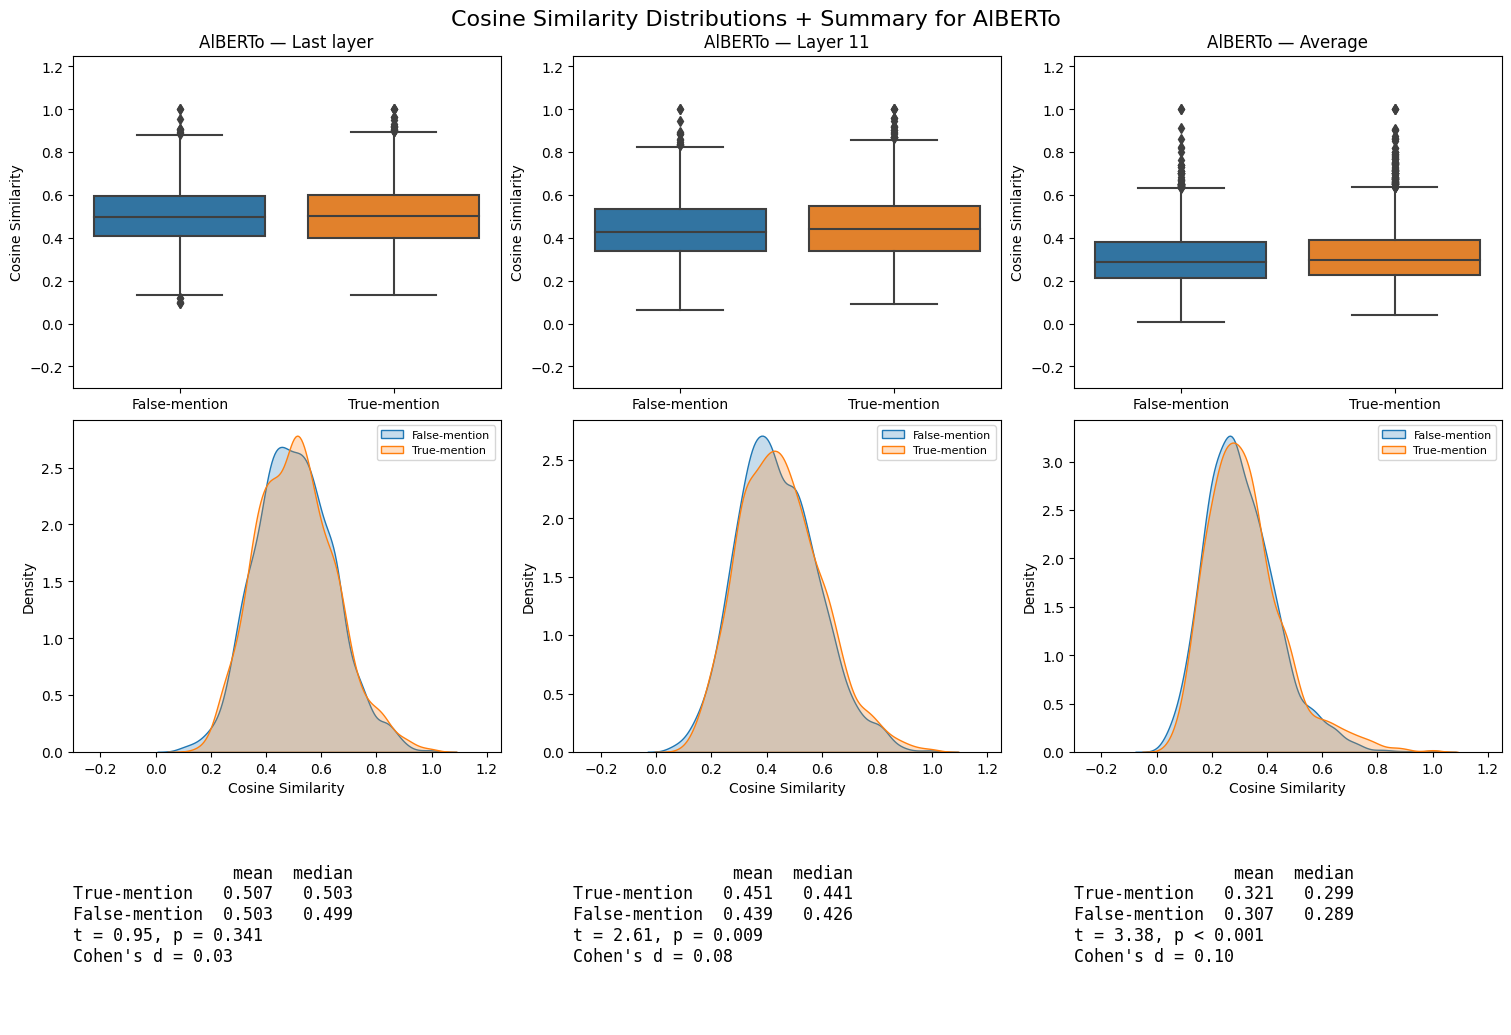

In [15]:
## visualisation of cosine similarity for all models: last layer, layer 11, average

## True vs False mentions

import warnings
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")

for m in model_pairs[1:]:
    simple_name = m[3]

    sim_cols = [
        (f"similarity-lst-{simple_name}", "Last layer"),
        (f"similarity-l11-{simple_name}", "Layer 11"),
        (f"similarity-avg-{simple_name}", "Average"),
    ]
    
    plot_with_stats_below(coref_df_tf, sim_cols, simple_name, ('label_str','True-mention','False-mention'))

**Visualisation of cosine similarity scores between true and false mentions.**

The cosine similarity scores compared in this first visualisation are those of true mentions and false mentions. A statistically relevant difference between the two distributions could indicate that the model is able to correctly link an antecedent with a correct mention, perceiving false mentions differently and assigning them lower similarity scores. On the other hand, if the two distributions were to come from the same distribution, it could indicate that the model has difficulties in perceiving the similarity between an antecedent and a mention, irrespective of it being a true or a false one. 

**UmBERTo** (CommonCrawl) shows statistically relevant *p*-values in the scores taken from the 11th layer, and in the scores averaged from the model's embeddings, while showing a non-statistically relevant *p*-value in the scores from the last layer. However, the effect size is very small, being respectively 0.15 and 0.18 for the two relevant cases. <br>
**UmBERTo** (Wikipedia) shows only one statistically relevant case, coming from comparing the two distributions in the average of the embeddings. Once again, the effect size is very small (0.15). <br>
**GilBERTo** shows statistically relevant *p*-values in all the cases cases, this time with slightly larger, but nonetheless small, effect sizes as UmBERTo CC: the effect sizes for scores from the last layer, from the 11th layer, and from the average of embeddings are respectively 0.13, 0.25, 0.21. <br>
**AlBERTo** shows only one statistically relevant *p*-value coming from the scores averaged from the model's embeddings. The effect size is, however, the smallest among all the models (0.10).

What is interesting to note here is that the statistical significance seems to reflect the scores obtained earlier by the classifier: the two models with the highest scores (GilBERTo and UmBERTo CC) also show the majority of statically significant cases with the biggest effect sizes; UmBERTo W, which performs slightly worse that the other two, shows statistical significance only in one case; and finally AlBERTo, which reaches the lowest scores with the probing classifier, shows only one statistically significant case and the lowest effect size across all models.

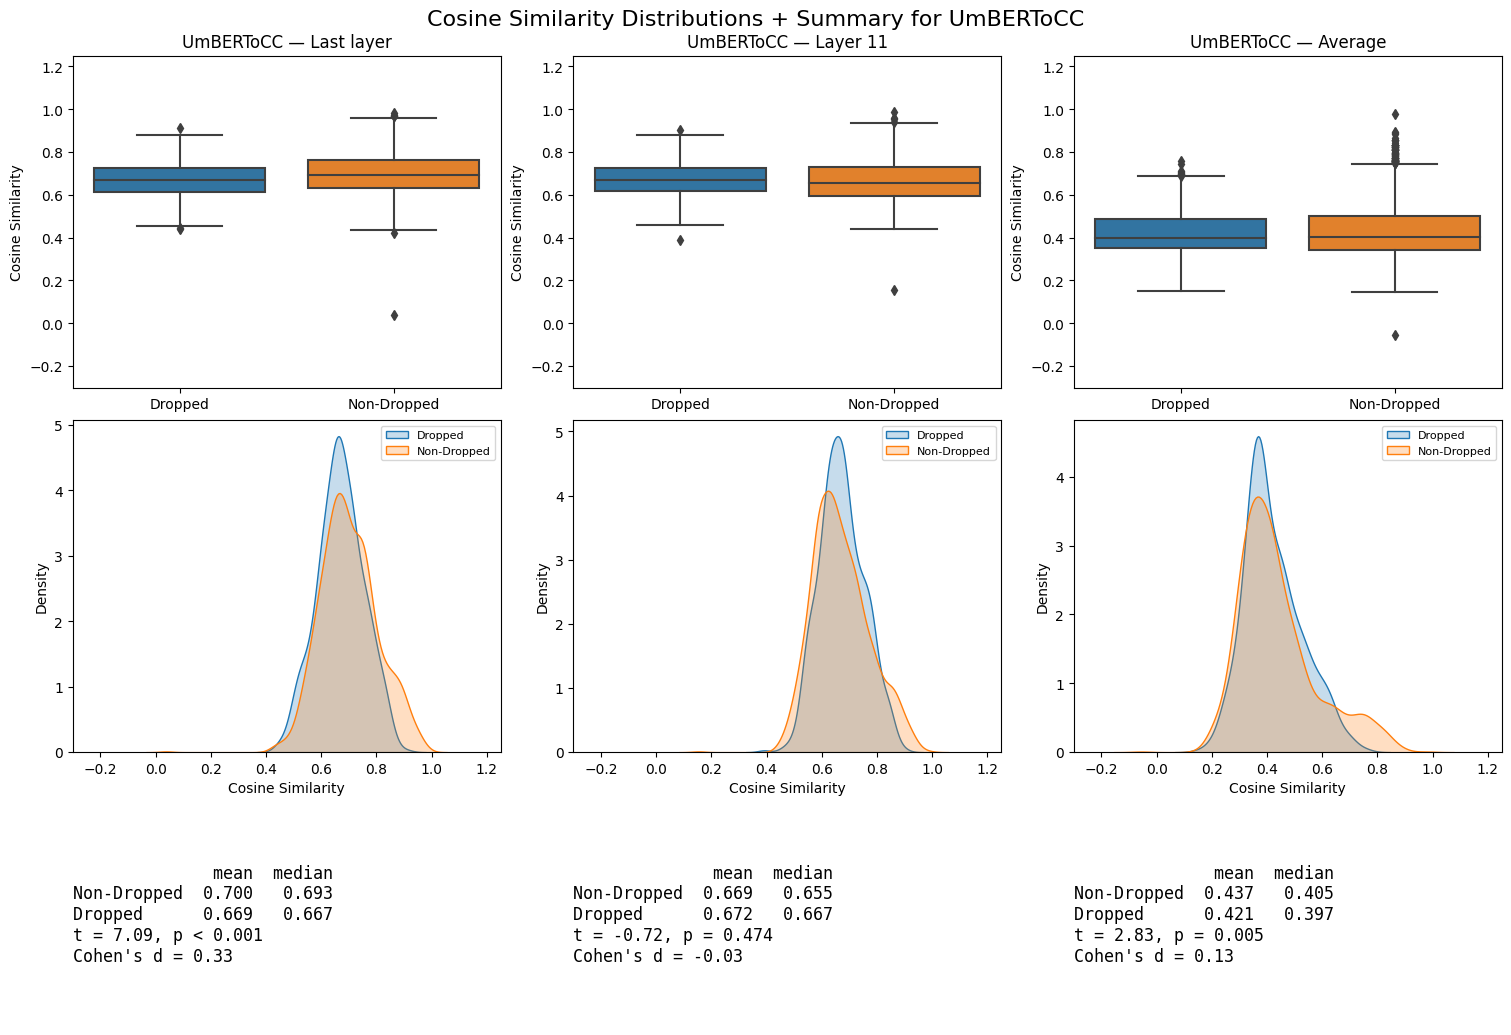

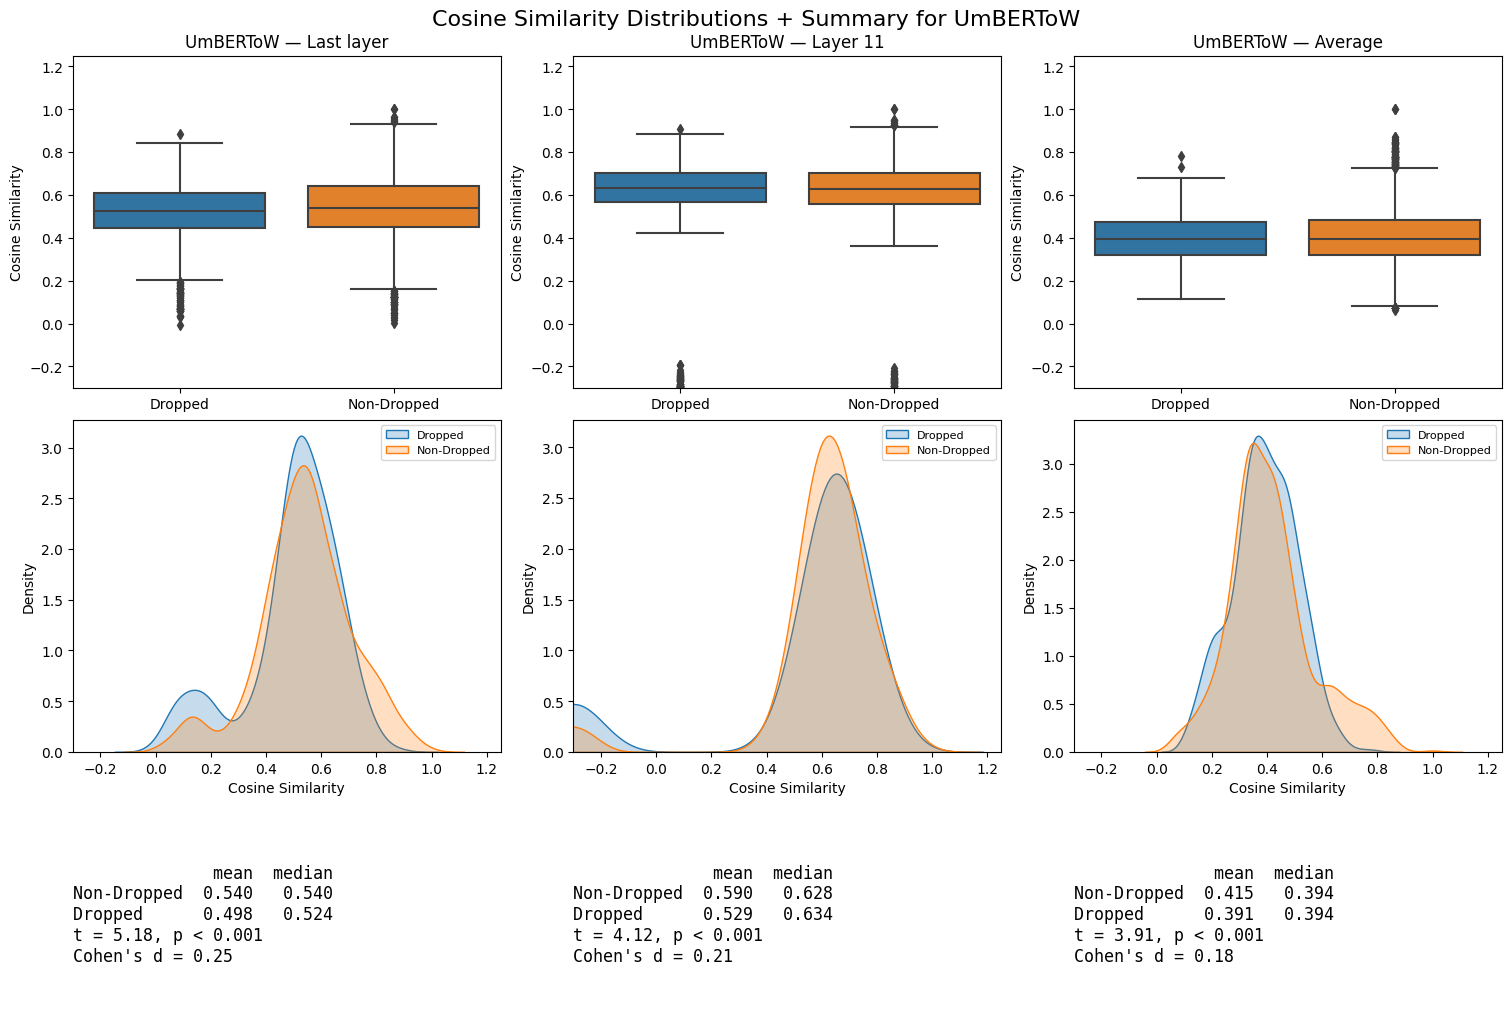

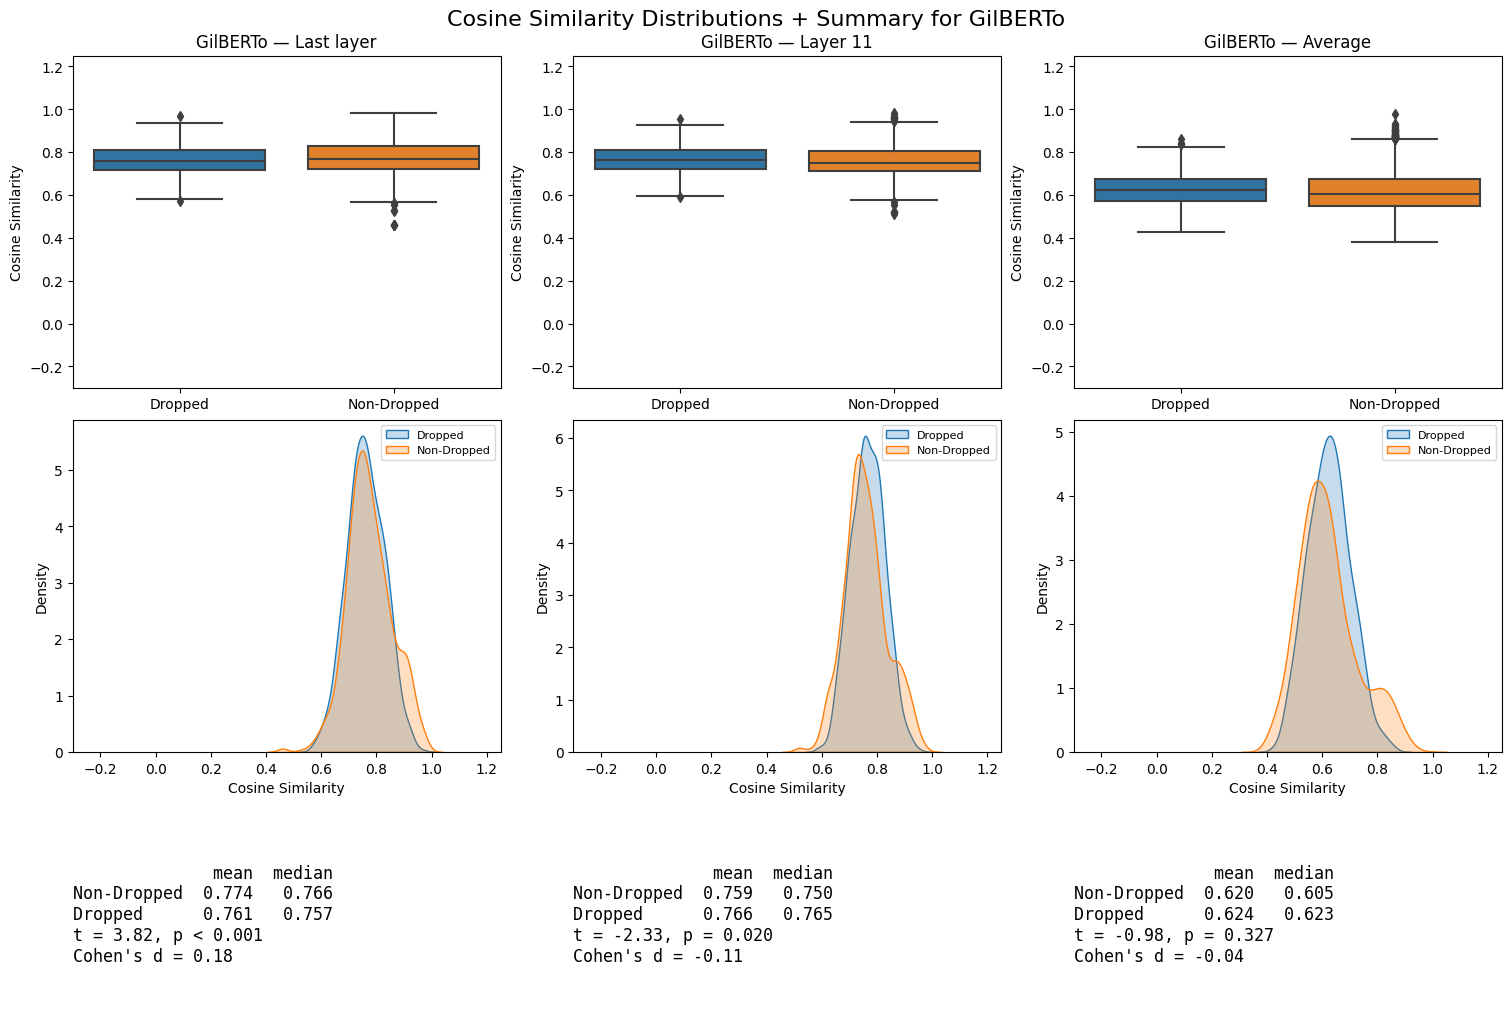

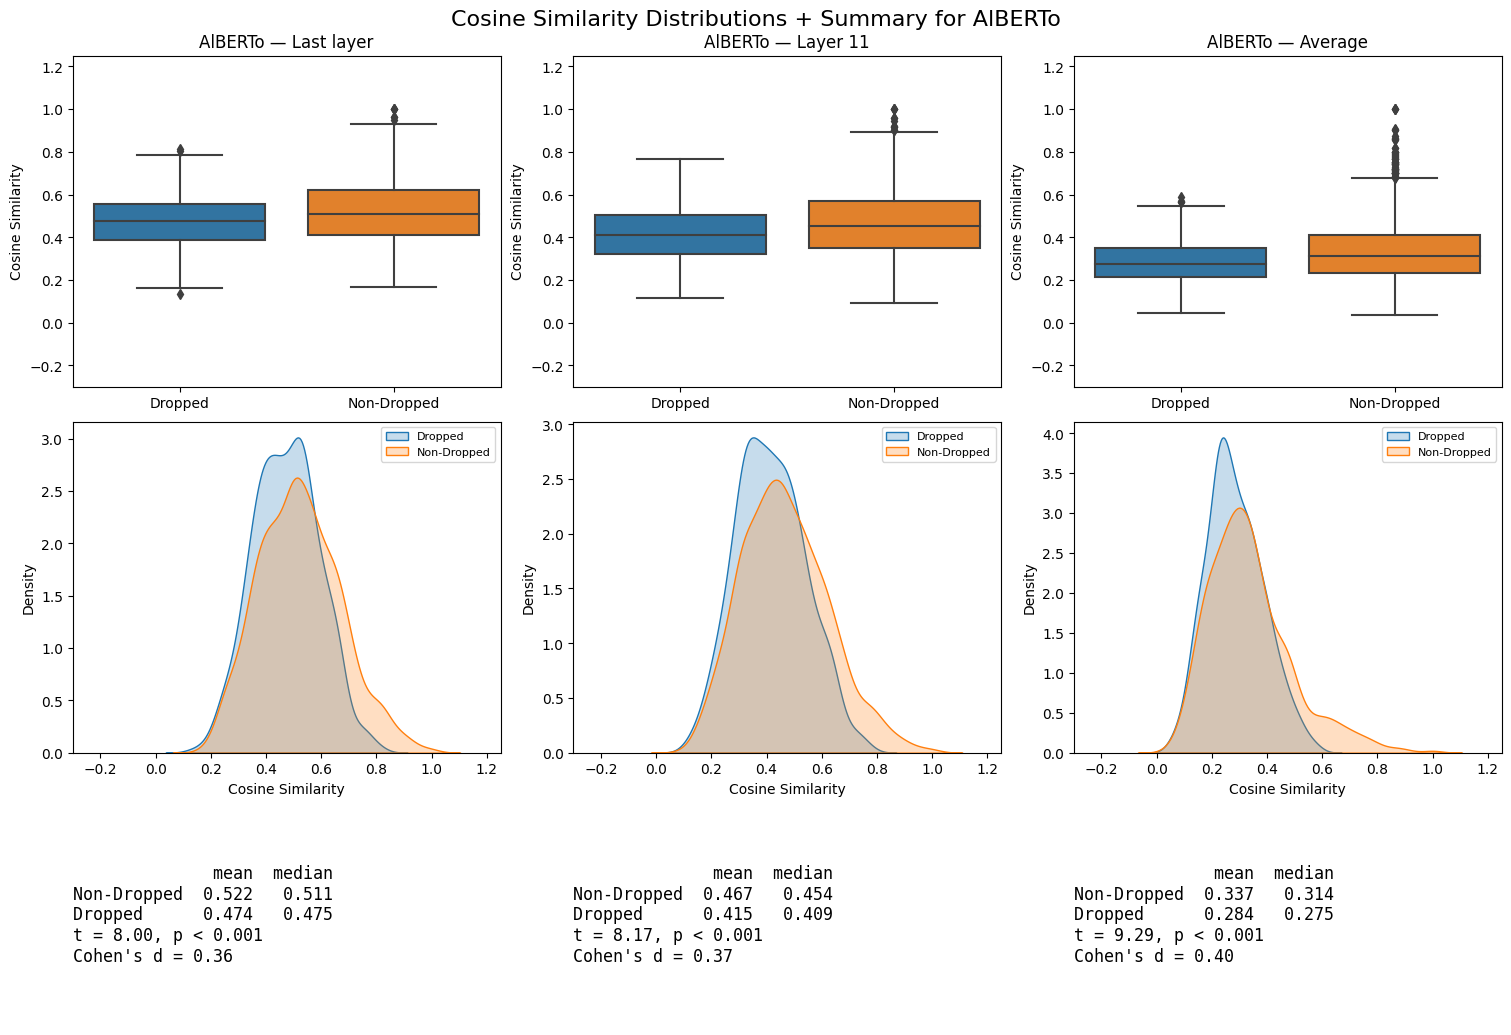

In [16]:
## visualisation of cosine similarity for all models: last layer, layer 11, average

## Non-Dropped vs Dropped mentions in True mentions examples

true_df = coref_df_tf[coref_df_tf['label'] == 1]


## visualisation of cosine similarity for all models

import warnings
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")

for m in model_pairs[1:]:
    simple_name = m[3]

    sim_cols = [
        (f"similarity-lst-{simple_name}", "Last layer"),
        (f"similarity-l11-{simple_name}", "Layer 11"),
        (f"similarity-avg-{simple_name}", "Average"),
    ]
    
    plot_with_stats_below(true_df, sim_cols, simple_name, ('dropped_subject_str','Non-Dropped','Dropped'))

**Visualisation of cosine similarity scores between dropped and non-dropped mentions in true examples.**

The plots above show cosine similarity scores for non-dropped and dropped mentions with the respective antecedents taken from examples with only true mention labels. <br>
A difference in the cosine similarity score distributions between non-dropped and dropped mentions would indicate that the model takes the antecedent to be more similar to one group rather than the other, i.e., more similar to an NP mention or to a V mention. If the similarity score between a verb (in the case of a dropped mention) and the antecedent shows the same pattern as the similarity score between a non-dropped mention and its antecedent, it might suggest that the model can retain from a verb the information it would usually get from a present mention. <br>

**UmBERTo** (CommonCrawl) shows a statistically relevant *p*-value only in the cosine similarity extracted from the last layer: the effect size is small to medium (0.33) and indicates that non-dropped mentions have higher similarity scores with their antecedents than dropped mentions. Non-dropped mentions and verbs which contain a dropped mention have nonetheless a very similar distribution, suggesting that the model perceives them similarly. <br>
**UmBERTo** (Wikipedia) shows statistically relevant *p*-values in all three cases observed, i.e., scores from the last layer, from the 11th layer, and averaged; the effect size is small and positive in all cases (0.25, 0.21, 0.18), signalling that non-dropped mentions have higher similarity scores to their antecedents than dropped mentions. <br>
**GilBERTo** shows a statistically significant *p*-value only in the similarity score extracted form the last layer: the effect size is small and positive (0.18), thus indicating again that non-dropped mentions have higher similarity scores with their antecedents than dropped mentions. The lack of many statistically significant *p*-values and such a small effect size indicates that non-dropped mentions and verbs which contain a dropped mention have nonetheless a very similar distribution, suggesting that the model perceives them almost in the same way. This may suggest that the model relies on the verb, and possibly on its morphology, to resolve a coreference chain. <br>
**AlBERTo** shows statistically significant *p*-values in all cases analysed, showing small to medium effect sizes (0.36, 0.37, 0.40 respectively), indicating that non-dropped mentions have higher similarity scores to their antecedents than dropped mentions. These results may suggest that the model does not perceive present mentions and dropped mentions in the same way, thus maybe relying on other factors to resolve the coreference chain.

Once again, it can be seen that UmBERTo CC and GilBERTo, as in the previous visualisation, cluster together in showing similar results. In fact they are the two models that show the fewest statistically relevant results and the smallest effect sizes, thus possibly suggesting that these two model perceives present mentions, i.e., NP mentions, and dropped mentions, i.e., verbs which have a dropped mention in their scope, as similar. On the other hand, UmBERTo W and AlBERTo show the highest number of statistically relevant results and the largest effect sizes, thus potentially suggesting that the model perceives present and dropped mentions as different. 

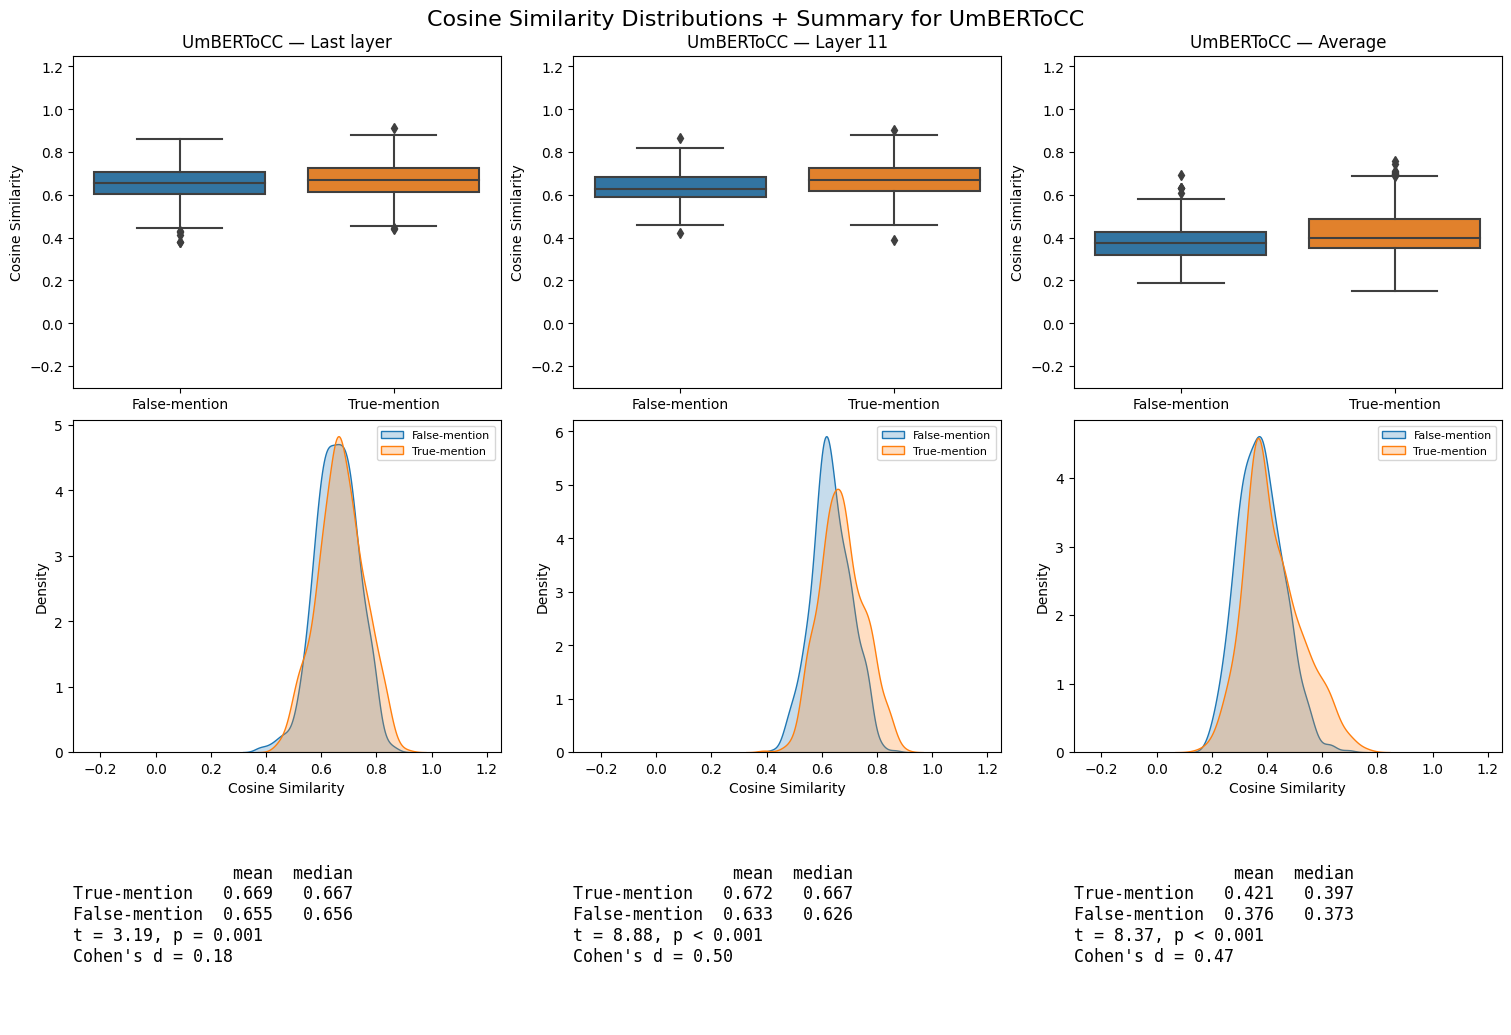

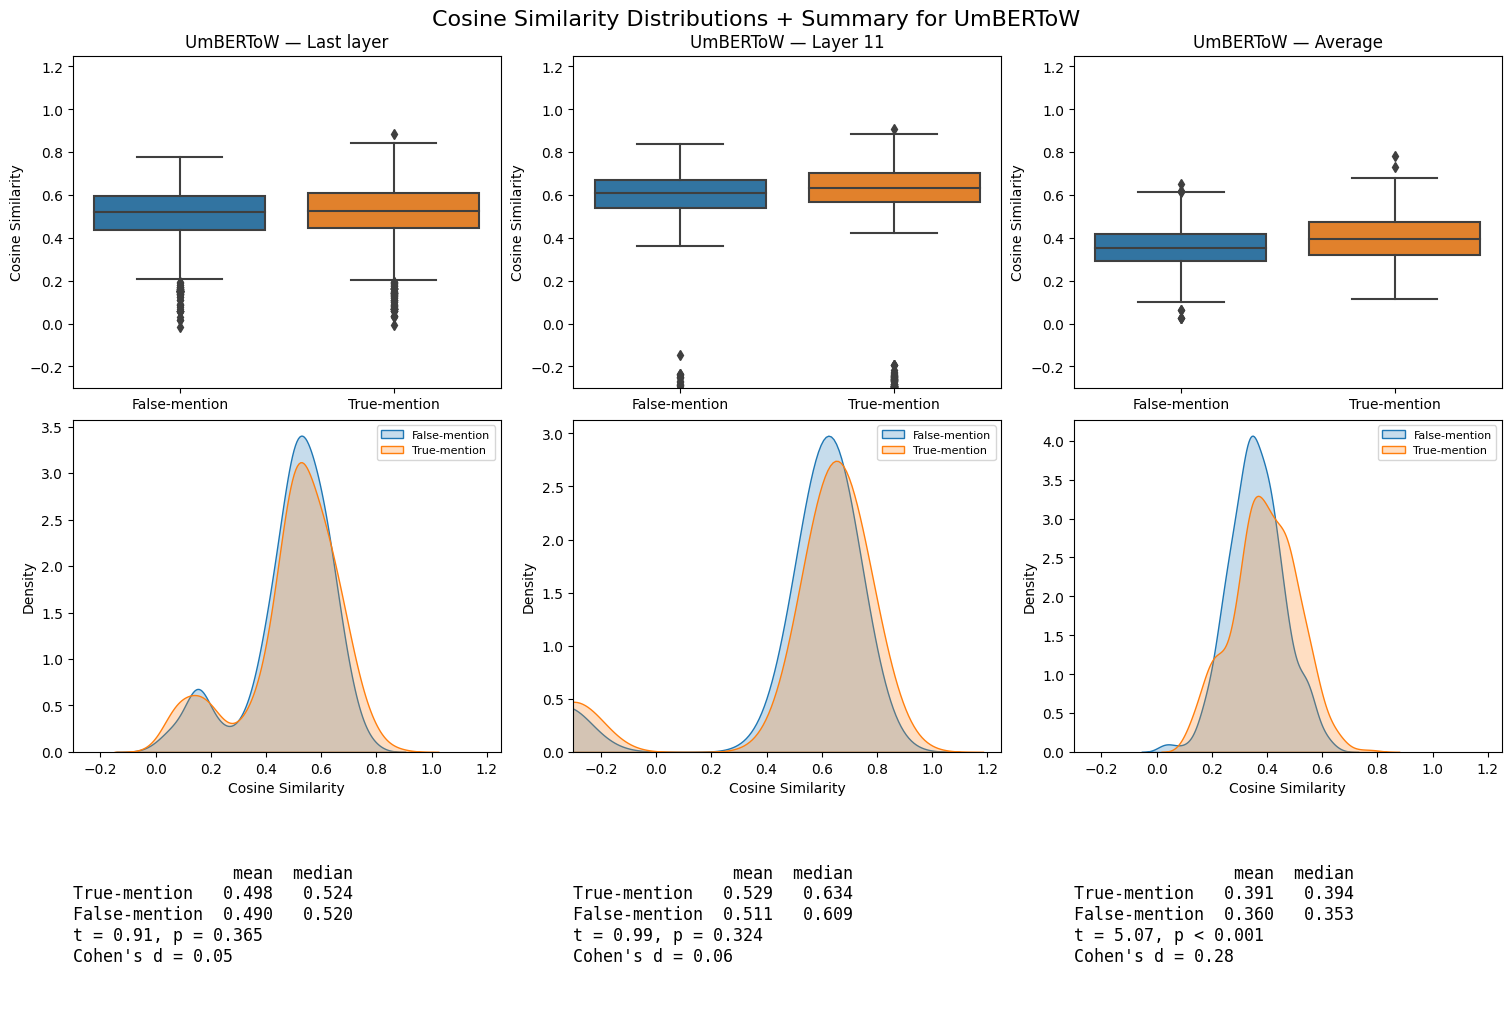

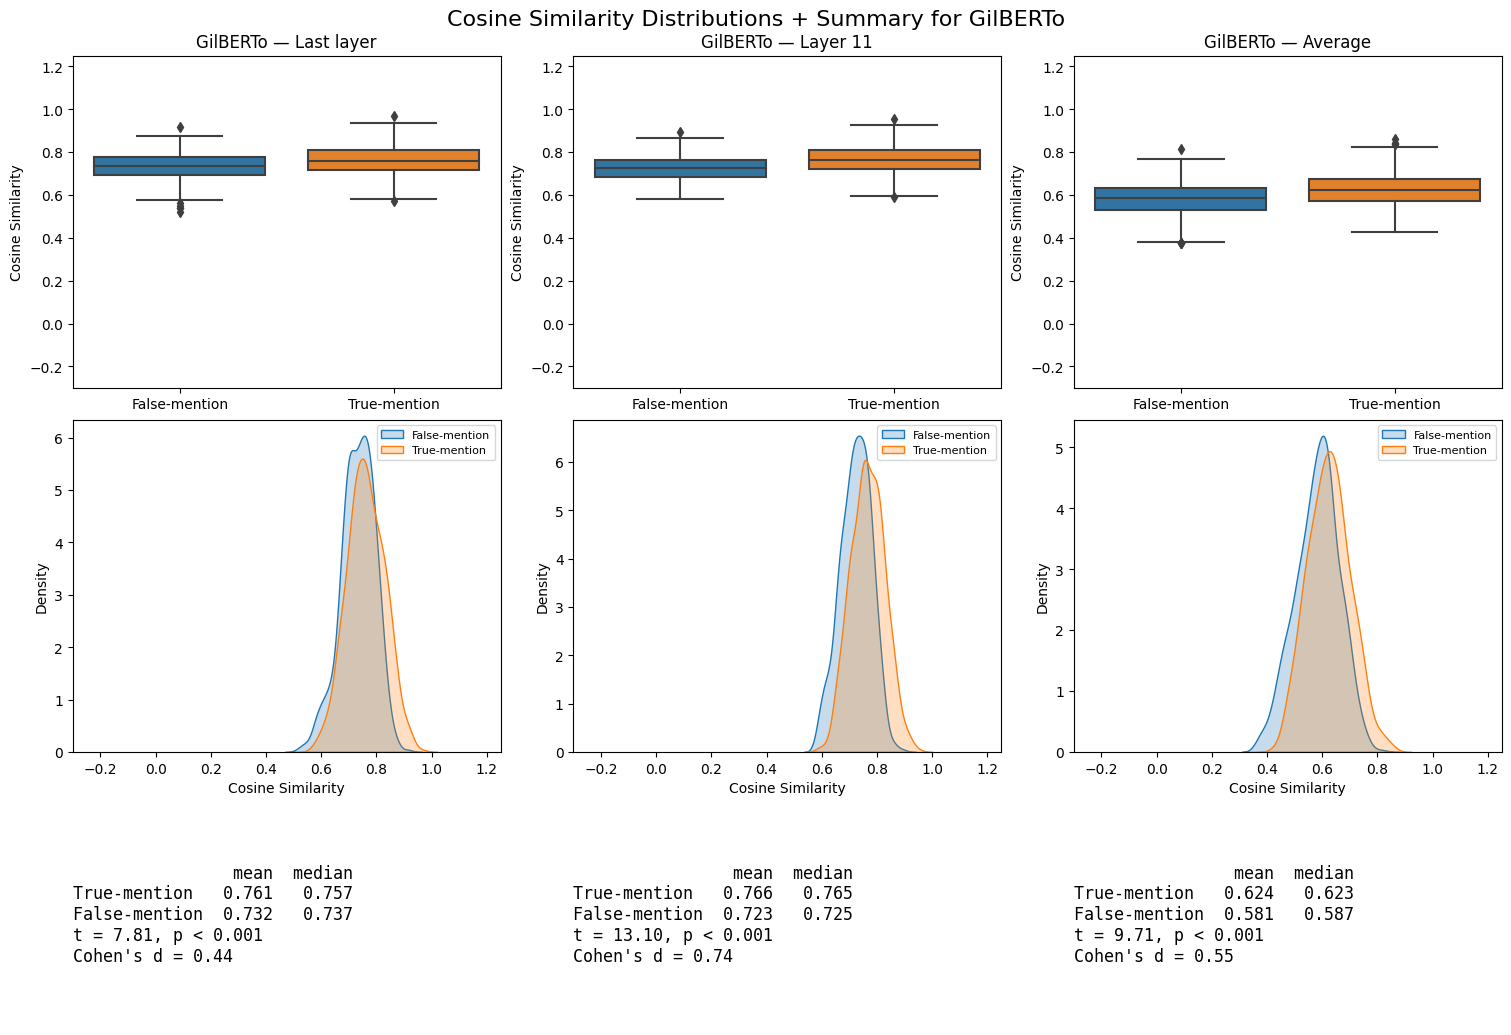

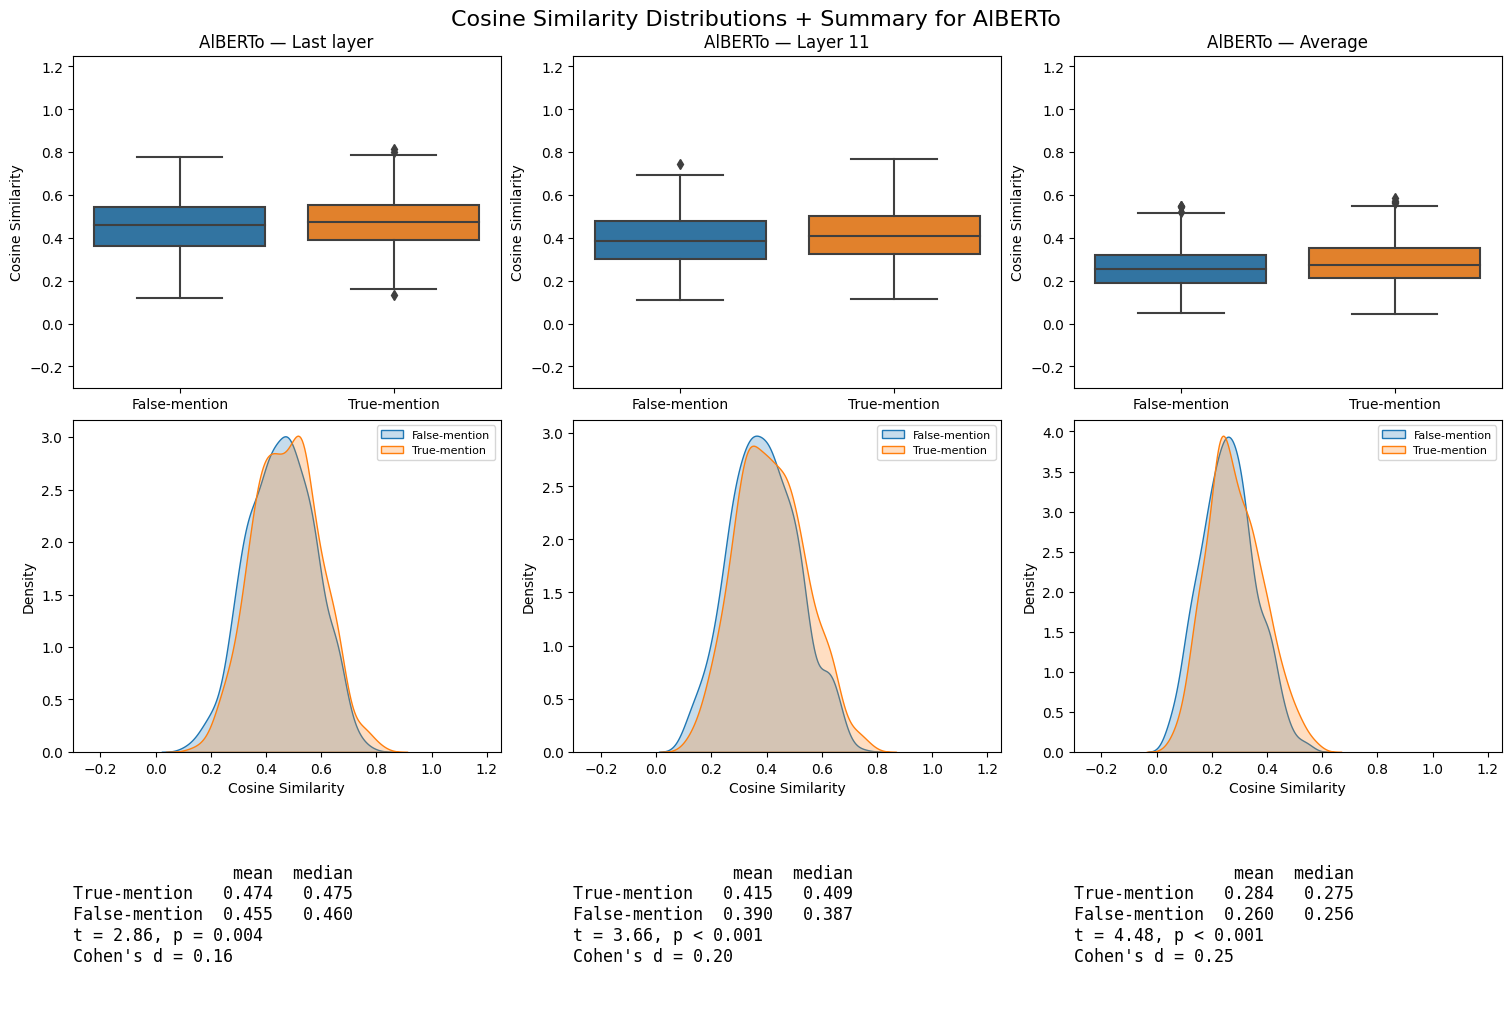

In [17]:
## visualisation of cosine similarity for all models: last layer, layer 11, average

## True Dropped mentions and False Dropped mentions

dropped_df = coref_df_tf[coref_df_tf['dropped_subject'] == 1]

## visualisation of cosine similarity for all models

import warnings
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")

for m in model_pairs[1:]:
    simple_name = m[3]

    sim_cols = [
        (f"similarity-lst-{simple_name}", "Last layer"),
        (f"similarity-l11-{simple_name}", "Layer 11"),
        (f"similarity-avg-{simple_name}", "Average"),
    ]
    
    plot_with_stats_below(dropped_df, sim_cols, simple_name, ('label_str','True-mention','False-mention'))

**Visualisation of cosine similarity scores between true dropped mentions and false dropped mentions.**

The plots above show the cosine similarity scores for true and false dropped mentions and their respective antecedents. I focused the attention on dropped mentions, both true and false, in order to explore whether the model treats all verbs the same or if higher similarity scores are assigned to verbs whose dropped mention correctly refers back to an antecedent. If no differences were found between the attention scores of true and false dropped mentions it would mean that the model treats verbs in the same way, irrespective of the fact that they might have in their scope a dropped mention referring back to an antecedent or one not referring back to it.

**UmBERTo** (CommonCrawl) has statistically relevant *p*-values in almost all cases (p = 0.001 in scores from the last layer). The effect size of the scores extracted from the 11th layer and from the average of embeddings are medium and positive (0.50 and 0.47 respectively), indicating a possible clear distinction between true dropped mentions and false dropped mentions, with the first ones being perceived more similar to the antecedent they refer to. This means that the model perceives verbs that have a dropped mention in their scope to be more similar to the antecedent to which the dropped mention refers to, rather than other verbs which have a dropped mention in their scope that does not refer back to that antecedent. <br>
**UmBERTo** (Wikipedia) has a statistically relevant *p*-value only in the scores from the average of embeddings. The effect size is small to medium and positive, thus also suggesting that the model might perceive true dropped mentions to be more similar to the antecedent they refer to than false dropped mentions.<br>
**GilBERTo** shows probably the most interesting results since all its *p*-values are statistically relevant and the effect sizes are medium in the case of scores extracted from the last layer (0.44), medium to large in the case of scores from the 11th layer (0.74) and medium in the case of the averaged score (0.55). This suggests that the model distinguishes well between a verb which contains a true dropped mention referring back to an antecedent and verbs containing a false dropped mention, i.e., the model assigns a higher similarity score between an antecedent and a verb which has a true dropped mention in its scope, rather than with a verb which has a dropped mention in its scope which does not refer back to the antecedent. <br>
**AlBERTo** shows statistically relevant *p*-values in the cases of scores from the 11th layer and from the average of embeddings. Effect sizes are small (0.20 and 0.25) and positive, thus suggesting that also this last model perceives true dropped mentions to be more similar to the antecedent than false dropped mentions.

As evinced in the previous two visualisations, it can be seen that UmBERTo CC and GilBERTo cluster together in having similar results: the high number of statistically relevant *p*-values and the medium to large effect sizes suggest that these two models are well able to distinguish between a true dropped mention and a false dropped mention, thus deeming verbs that contain a dropped NP mention in their scope as more similar to the antecedent the mention refers to. On the other hand, UmBERTo W and AlBERTo seem to not differentiate well between the two, with UmBERTo W performing slightly better than AlBERTo. 

<h4>Cosine similarity (summary)</h4>

I calculated the cosine similarity score, i.e., the closeness in vector space between two tokens—the closer they are the more similar the model takes them to be, between an antecedent and a mention given by the four Italian models in order to see how and where they differed. <br> 
The scores are extracted from three different loci in the models: 

1. from the last layer, i.e., from the last representation the model has of the sequence;
2. from the 11th layer, i.e. from the representation the model has of the sequence at its penultimate layer since it is possible that the model uses the last layer to regather a general understanding of the overall sentence dropping too specific relations;
3. from the average of the model's embeddings from all layers, i.e., the model's representations coming from all its layers are averaged in order to see how the model generally represents a token.

Different splits of the data are visualised and compared in order to see whether the model reacts differently to different distributions and whether there exists a difference in the model's behaviour between them. The distributions I compared are: 

1. True vs False examples, in order to see whether the model manages to encode a difference between mentions that truly refer to an antecedent and mentions which do not refer back to an antecedent;
2. Present vs Dropped mentions from True examples, in order to see whether there exists a similarity in the way the model conceives a present mention and a verb which has in its scope a dropped one;
3. True Dropped mentions vs False Dropped mentions, in order to see whether the model treats all verbs in the same way, irrespective of whether they contain a dropped mention that refers back to an antecedent or not. This last experiment is necessary to validate the observations from the previous point: if a verb that has a dropped mention in its scope behaves similarly to an NP mention, it is also important to confirm that that same verb behaves differently from a verb whose dropped mention does not refer back to the antecedent.

The models that seem to capture best the difference between True and False examples, even though with a small effect size, are UmBERTo CommonCrawl and GilBERTo. These two models are also the ones that perceive the less difference between a true present mention and a true dropped mention, i.e., an NP mention is treated in the same way as a verb which has a dropped mention in its scope; on the other hand, the other two models, UmBERTo Wikipedia and AlBERTo, perceive present and dropped mentions with the highest differences among the models, thus potentially suggesting that these models do not use the dropped mention's verb to close the coreference chain. Finally, UmBERTo CommonCrawl and GilBERTo also show the highest differences (with medium to large effect sizes) when it comes to differentiating between a true dropped mention and a false dropped mention; on the other hand, the verbs are more or less perceived similarly by the two other models, irrespective of whether the dropped mention in their scope refers back to the antecedent or not. 

Summing up, in observing the model's cosine similarities scores for the different distributions of the data, it is clear that two models outperform the others. In fact, UmBERTo CommonCrawl and GilBERTo not only are the models that better differentiate between true and false mentions, they also seem to perceive as similar true present mentions and verbs which have in their scope a true dropped mention, also showing that they are able to differentiate well between true dropped mentions and false dropped mentions cases. On the other hand, the other two models, i.e., UmBERTo Wikipedia and AlBERTo, show somewhat the opposite pattern: they are less able to differentiate between true and false examples, they perceive true present mentions and true dropped mentions to be coming from different distributions, and they do not differentiate well between true dropped mentions and false dropped mentions. <br>
These results pattern with the results obtained from the previous probing classifier experiment: the two best performing models in both cases were UmBERTO CC and GilBERTO, with the other two models, i.e., UmBERTO W and AlBERTo, falling behind. 

<h2>Final experiment</h2>

After the results from the previous sections and the previous experiments, i.e., attention matrix visualisation, probing classifier training, and cosine similarity scores analysis, I carry out, in this last section, a final experiment to see whether the previous results are borne out. <br>
I train a probing classifier multiple times for each model and evaluate the performances. The probing classifier is trained using the representations created by the models at different places of their architectures, i.e., representations from the first 3 layers, from the first middle 3 layers, from the last middle 3 layers, and from the last 3 layers. In this way it is possible to see where and how well each model encodes this type of relationship in its architecture, and it allows a direct comparison with the attention matrices previously showed in order to see whether performance throughout the layers correlates with the patterns of activation showed in the matrices.   

In [6]:
## function get representations: tokenise single example, get attention (from layer range)
## function extract features

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true,labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(2, 2))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0","1"])
    disp.plot(cmap="Greens", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

def get_reps(example, model, tokenizer, layer_range):
    text = example['text']
    men_offset = example['mention_offset']
    ant_offset = example['antecedent_offset']

    enc = tokenizer(text, return_offsets_mapping=True, return_tensors="pt")
    ids = enc['input_ids']
    offsets = enc['offset_mapping'][0]

    with torch.no_grad():
        reps = model(**{k: v for k, v in enc.items() if k != 'offset_mapping'})
        hidden_states = reps.hidden_states  # tuple of [layer][batch][tokens][hidden]

    # average over selected layers
    selected = hidden_states[layer_range[0]:layer_range[1]]
    hidden = torch.stack(selected).mean(dim=0)[0]  # [tokens, hidden_size]

    def find_rep(char_offset):
        idx = next(i for i, (s, e) in enumerate(offsets) if s <= char_offset < e)
        return hidden[idx]

    men = find_rep(men_offset)
    ant = find_rep(ant_offset)

    return {
        'men': men,
        'ant': ant,
        'lab': int(example['label'])
    }



def extract_features(dataset, model, tokenizer, layer_range):
    features, labels = [], []
    for ex in tqdm(dataset, desc="Extracting features"):
        reps = get_reps(ex, model, tokenizer, layer_range)
        men = reps['men']
        ant = reps['ant']
        lab = reps['lab']
        features.append(torch.cat([men, ant]).numpy())
        labels.append(lab)

    return features, labels

In [ ]:
"""
this is very long to run, with the accelerator on it took ~7 minutes per classifier: 
    i.e., 7 min * 4 layer-groups * 4 models = 112 minutes (~2h)
I trained each model's classifiers independently and stored results in a dataframe which I then downloaded locally
eventually I collected all results in a single dataframe and loaded it in order to plot the results
"""

## probe classifier on representations of first 3, middle 3a, middle 3b, last 3 layers 

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from tqdm import tqdm
import torch

layer_groups = {
    "First 3": (0, 3),
    "Middle 3a": (3, 6),
    "Middle 3b": (6, 9),
    "Last 4": (9, 12)
}

x_pos = [3, 6, 9, 12]
all_model_results = {}
summary_report = {}
per_model_examples = {}



for m in model_pairs[4:5]:

    model_name = m[0]
    print(f"\n\n=== Evaluating model: {model_name} ===")
    tokenizer = m[1]
    model = AutoModel.from_pretrained(model_name, output_hidden_states=True)

    num_layers = model.config.num_hidden_layers
    num_heads = model.config.num_attention_heads

    model.eval()

    accuracies = []

    for group_name, layer_range in layer_groups.items():
        print(f"\n--- Layer Group: {group_name} ---")

        features, labels = extract_features(coref_dataset, model, tokenizer, layer_range)
        all_indices = np.arange(len(coref_dataset))
        X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
            features, labels, all_indices, test_size=0.2, random_state=42
        )

        clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, solver='lbfgs'))
        clf.fit(X_train, y_train)
        y_preds = clf.predict(X_test)

        # Accuracy logging
        report = classification_report(y_test, y_preds, output_dict=True)
        accuracies.append(report['accuracy'])
        #print(classification_report(y_test, y_preds))
        f1 = f1_score(y_test, y_preds, average='macro')
        print(f"Macro F1 Score: {f1}")

        # Store best/worst examples
        if hasattr(clf, "predict_proba"):
            probs = clf.predict_proba(X_test)
            confidences = np.max(probs, axis=1)
        else:
            decision = clf.decision_function(X_test)
            confidences = 1 / (1 + np.exp(-np.abs(decision)))

        correct_mask = (y_preds == y_test)
        incorrect_mask = ~correct_mask

        best_correct = sorted(np.where(correct_mask)[0], key=lambda i: confidences[i], reverse=True)[:5]
        worst_incorrect = sorted(np.where(incorrect_mask)[0], key=lambda i: confidences[i], reverse=True)[:5]
        lowconf_correct = sorted(np.where(correct_mask)[0], key=lambda i: abs(confidences[i] - 0.5))[:5]

        per_model_examples[(model_name, group_name)] = {
            "best_correct": best_correct,
            "worst_incorrect": worst_incorrect,
            "lowconf_correct": lowconf_correct,
            "y_test": y_test,
            "y_preds": y_preds,
            "confidences": confidences,
            "X_test": X_test,
            "idx_test": idx_test
        }

        summary_report[(model_name, group_name)] = report

        #print(f"Correct: {sum(correct_mask)} | Incorrect: {sum(incorrect_mask)}")
        #plot_confusion_matrix(y_preds, y_test, labels=[0, 1])
        #print("-" * 60)

    all_model_results[model_name] = accuracies

In [13]:
## load dataframe with results from evaluation of models' probing classifiers

import pandas as pd

df = pd.read_csv("/kaggle/input/models-performance-3layergroups/model_layer_results.csv")

model layer_group  accuracy  \
0             Musixmatch/umberto-commoncrawl-cased-v1     First 3  0.671362   
1             Musixmatch/umberto-commoncrawl-cased-v1   Middle 3a  0.686620   
2             Musixmatch/umberto-commoncrawl-cased-v1   Middle 3b  0.724178   
3             Musixmatch/umberto-commoncrawl-cased-v1      Last 4  0.724178   
4             Musixmatch/umberto-wikipedia-uncased-v1     First 3  0.679577   
5             Musixmatch/umberto-wikipedia-uncased-v1   Middle 3a  0.697183   
6             Musixmatch/umberto-wikipedia-uncased-v1   Middle 3b  0.683099   
7             Musixmatch/umberto-wikipedia-uncased-v1      Last 4  0.708920   
8             idb-ita/gilberto-uncased-from-camembert     First 3  0.681925   
9             idb-ita/gilberto-uncased-from-camembert   Middle 3a  0.730047   
10            idb-ita/gilberto-uncased-from-camembert   Middle 3b  0.693662   
11            idb-ita/gilberto-uncased-from-camembert      Last 4  0.720657   
12  m-polignano-uniba/bert_uncased_L-12_H-768_A-12...     First 3  0.653756   
13  m-polignano-uniba/bert_uncased_L-12_H-768_A-12...   Middle 3a  0.696009   
14  m-polignano-uniba/bert_uncased_L-12_H-768_A-12...   Middle 3b  0.696009   
15  m-polignano-uniba/bert_uncased_L-12_H-768_A-12...      Last 4  0.674883   

     x  
0    3  
1    6  
2    9  
3   12  
4    3  
5    6  
6    9  
7   12  
8    3  
9    6  
10   9  
11  12  
12   3  
13   6  
14   9  
15  12

In [21]:
## print models' results 

model_name = None

for _, row in df.iterrows():
    current_model = row['model']
    
    if current_model != model_name:
        print(f"\nModel: {current_model}")
        model_name = current_model

    print(f"  Layer group: {row['layer_group']}   \tAccuracy: {row['accuracy']:.4f}")



Model: Musixmatch/umberto-commoncrawl-cased-v1
  Layer group: First 3   	Accuracy: 0.6714
  Layer group: Middle 3a   	Accuracy: 0.6866
  Layer group: Middle 3b   	Accuracy: 0.7242
  Layer group: Last 4   	Accuracy: 0.7242

Model: Musixmatch/umberto-wikipedia-uncased-v1
  Layer group: First 3   	Accuracy: 0.6796
  Layer group: Middle 3a   	Accuracy: 0.6972
  Layer group: Middle 3b   	Accuracy: 0.6831
  Layer group: Last 4   	Accuracy: 0.7089

Model: idb-ita/gilberto-uncased-from-camembert
  Layer group: First 3   	Accuracy: 0.6819
  Layer group: Middle 3a   	Accuracy: 0.7300
  Layer group: Middle 3b   	Accuracy: 0.6937
  Layer group: Last 4   	Accuracy: 0.7207

Model: m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0
  Layer group: First 3   	Accuracy: 0.6538
  Layer group: Middle 3a   	Accuracy: 0.6960
  Layer group: Middle 3b   	Accuracy: 0.6960
  Layer group: Last 4   	Accuracy: 0.6749


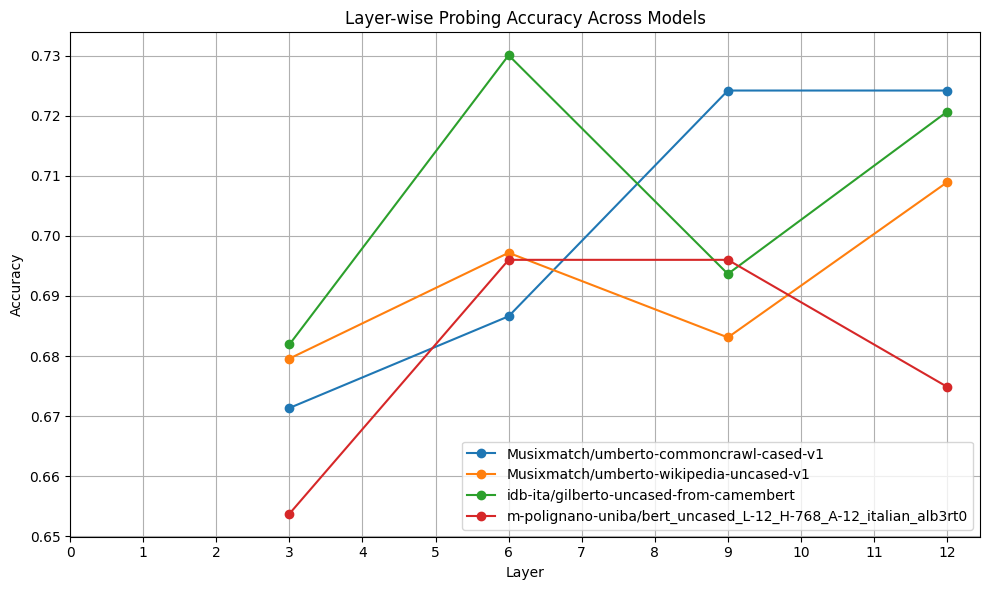

In [11]:
## plot results

import matplotlib.pyplot as plt

# map layer group names to x-axis positions
layer_group_to_x = {
    "First 3": 3,
    "Middle 3a": 6,
    "Middle 3b": 9,
    "Last 4": 12
}
# new column for x-axis values
df["x"] = df["layer_group"].map(layer_group_to_x)


plt.figure(figsize=(10, 6))

for model_name in df["model"].unique():
    model_data = df[df["model"] == model_name].sort_values("x")
    plt.plot(model_data["x"], model_data["accuracy"], marker='o', label=model_name)

plt.xticks(ticks=range(0, 13))
plt.xlabel("Layer")
plt.ylabel("Accuracy")
plt.title("Layer-wise Probing Accuracy Across Models")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


The plot shows the results coming from the evaluation of the different probing classifiers trained using the representations coming from groups of 3 layers from each model. For each model I trained 4 probing classifiers: the first one used the model's representations after the first 3 layers, the second one used the representations after 6 layers, the third used the representations after 9 layers, and the last one used the representations from the last layer.  

The picture drawn by the plot seems to confirm the trend that we saw up to this point: the two best performing models are UmBERTo CommonCrawl and GilBERTo, as was also shown by the previous probing classifier analysis. These are also the two models that got the best results in the analysis of their cosine similarity scores between antecedents and mentions. UmBERTo Wikipedia performs slightly worse than the first two models, falling only a couple of points behind. Finally, AlBERTo is the worst performing model, ending up with a difference of 5 points in accuracy from the best performing model. <br>
The analysis of the results' development throughout the models' architecture is also interesting. The analysis of the two UmBERTo models is not easy and clearcut because of the very diffused activation of attention in their attention matrices, so it is not easy to see which heads and layers are responsible for their different accuracy score development: in fact **UmBERTo CommonCrawl** sees a steady increase in accuracy while **UmBERTo Wikipedia** sees a first peak after six layers and a second peak at the end. Unfortunately the correlation between these developments is not easily seen in their attention matrices. <br> 
On the other hand, a clearer pattern can be seen for **GilBERTo**: the development of its results sees a peak at \~0.73—thus higher than the final score, after six layers, and a second peak at the end of its architecture: this is more or less visible in the different attention matrices associated with this model, in fact it can be seen that the layers which seem to have the majority of the most responsive heads are layer 3, 4, and 5. This would explain the peak in performance at layer 6, since the model seems to pay the most of attention to this relationship in the few layers immediately before. <br>
An even clearer example comes from the observation of **AlBERTo**, even though it reaches poorer results than the other models. Its performance development shows a peak after six layers, which remains steady after nine, and eventually declines at the end of the model. This might mean that the relationship is attended to in the first half of the model, kept somewhat active until layer 9, and then dropped towards the end, resulting in a performance degradation. This observation can be confirmed by observing the model's attention matrices: a clearer picture is visible here thanks to the very focused attention that this model displays, in fact the four heads that are most active in the coreference relationship are located in layer 3 and 4, exactly where this model peaks in performance; later heads are way less active in the relationship, thus possibly explaining the degradation in performance that this model experiences.

<h2>Summary</h2>

#### Dataset
In this notebook I used four different Italian language models and tried to explore if and how they encoded the relation of coreference between an antecedent and a mention. I explored how the models deal with mentions that are dropped—since in Italian the subject does not need to be present, and whether in these cases the models closed the coreference chain with the verb whose scope contained the dropped mention, the verb being both the linguistic head dominating the dropped mention and containing the relevant morphology able to indicate the number and person of the dropped mention. <br>
These experiments are carried out using the Live Memories Corpus from *Anaphoric Annotation of Wikipedia and Blogs in the Live Memories Corpus* ([Rodriguez et al. 2010](http://www.lrec-conf.org/proceedings/lrec2010/summaries/431.html)).

#### Models
The four models used are UmBERTo from CommonCrawl, UmBERTo from Wikipedia, GilBERTO, and AlBERTo. They have similar architectures, all having 12 layers and 12 heads, the same number of hidden states (768) and the same number of parameters (\~110M). <br>
Comparing these models is interesting because, while they have similar characteristics also in their inner workings, they still differ slightly from each other. For example, AlBERTo differs from the other models in the fact that the model pre-processes texts before using its SentencePiece tokeniser since the texts coming from Twitter need to be normalised. On the other hand, the two UmBERTo models are the only one using Whole Word Masking (WWM) as a pre-training task, with the two others using Subword Masking (MLM). AlBERTo differs from the others also in the fact that it uses a BERT architecture while the others use a RoBERTa architecture, i.e., a more modern and efficient one. Finally, also to be taken into consideration, is the differences in the training corpus: UmBERTo CommonCrawl is trained on a large amount of texts taken from the web, UmBERTo Wikipedia is trained on a smaller corpus coming from Wikipedia articles, GilBERTo is also trained from texts crawled from the web, and finally AlBERTo is trained on a twitter corpus, thus being more focused on social network language. 

#### Processing of dataset
The first needed step was to load the dataset and process it into a dataframe whose format could be used for the different experiments that needed to be carried out. For this reason the dataset, which contained one word per row and the relative linguistic and anaphoric information, was transformed in a dataframe which contained one sentence per row, rebuilt using the token's indices from the original dataset, an antecedent and a possible mention contained in the sentence, a label indicating whether the mention was a true mention referring back to the antecedent or a false one, a label indicating whether the mention was a present mention, i.e., an NP, or a dropped mention, i.e., a verb containing in its scope a dropped NP mention, offset information for both antecedent and mention, and a string translations of the two labels needed for better visualisation when plotting the graphs. Eventually, I sampled some examples from the model and operated some final corrections, namely I inverted labels where an antecedent followed a mention so that the dataframe consistently had mentions before antecedents, and I corrected some specific cases of mentions and antecedents that were either too long or contained a comma in the text by keeping the first three words (article + adjective + noun) and by keeping only the text before the comma respectively. <br>
Moreover, after I run a dummy cosine similarity test, I noticed a peak around score 1, i.e., a perfect match that should ideally only be the case where the two tokens are the same. This brought to a further observation of the data and to a pruning of examples which had an antecedent and a mention that were either the same, or one contained in the other. This eliminated the cases of perfect scores in the distribution and avoided a potential skew in the data. <br>
The last step was balancing the resulting dataframe in order to have an equal number of true and false labels overall, and an equal number of true and false dropped mentions. It was not possible to balance non-dropped and dropped mentions because of the lower number of the latter.

#### Attention matrices
The first experiment I carried out involved a visual analysis of the attention patterns in each of the models for different splits of the data. I achieved such a visualisation via displaying the level of activation of the different attention heads throughout the model's layers for the relation of interest, i.e., the relation between an antecedent and a mention. This builds a matrix in which the columns represent the model's heads and the rows its layers: active heads in the top layers mean that the relation of interest is attended to at the beginning of the model's architecture, vice versa, heads active towards the bottom layers suggest that the relation of interest is attended to at the end of the model's architecture. Attention could be either focused or diffused, making it easier in the former case to pinpoint where in the model a relation is attended to, and harder in the latter.

The attention matrices show that the models have different behaviours in regard to how, where, and to what extent they activate their heads. <br>
Generally for what concerns the pattern of activation, the two UmBERTo models behave similarly: they show very diffused attention patterns and make it hard to pinpoint the relation to any of the models' parts. It seems like the coreference relation is attended to by many different heads throughout the model's architecture. GilBERTo, even though it shows a less distributed pattern, still has many heads attending to the relation. The active heads in GilBERTo are mainly focused in the middle layers, making it somewhat possible to roughly pinpoint the relation to the middle layers. AlBERTo, on the other hand, shows the opposite trend: the heads active in the relation are very few (usually around 4) and all located in layer 4 and 5, making it possible to identify the locus where this relation is processed. <br>
The intensity of activation also changes in the different models: the two UmBERTo models behave similarly and have peaks of around 0.15; GilBERTo follows the same pattern and has peaks at 0.16; AlBERTo, on the other hand, shows less strong activations, with peaks at 0.08. <br>
Inspecting the two directions of attention we can see that all the models except AlBERTo have a preference for the mention to antecedent direction, i.e., no head is active in the antecedent to mention direction, while all active heads can be seen in the opposite direction. AlBERTo, once again, behaves differently, and has active heads in both directions. <br>
For what concerns the different splits of the data all the models seem to have a similar behaviour. In comparing the splits of true non-dropped and dropped mentions, all models show a stronger activation in the attention to dropped mentions while showing similar patterns, i.e., mentions NPs and mentions marked on verbs have a similar activation pattern, which is however stronger in the latter. When comparing the splits of true and false examples, all the models show stronger activation patterns in the true examples, thus suggesting that they are able to differentiate between a true and a false mention. Finally, to confirm that the models were also able to differentiate between true dropped mentions and false dropped mentions I compared these two distributions: the activation of attention heads between a true dropped mention and an antecedent is higher for all models than the activation of attention heads between false dropped mentions and an antecedent, thus suggesting that the model pays more attention, in the interpretation of a verb that has a dropped mention in its scope, to an antecedent who stands in a true coreference relationship with the dropped mention. 

This first visualisation highlighted that all models seem to be able to differentiate between true and false mentions by activating attention heads in the relationship between an antecedent and a mention in a stronger way when the mention is a true one. They also seem to be well able to differentiate between verbs which have in their scope a true dropped mention and verbs which have a false dropped mention: the attention between the former and an antecedent is stronger and more active rather than in the other case. From the matrices some differences emerged in the way attention is distributed throughout the layers for the two UmBERTo models and, even though less so, for GilBERTo, while, on the other hand, it is focused in a few heads for AlBERTo. AlBERTo also showed a substantial difference from the other models because it is the only one in which attention heads are active in both directions, i.e., from antecedent to mention, and from mention to antecedent; the other models only show active heads in the latter case. 

#### Probing classifier
The following experiment, which I then explore further in the last section of the notebook, involved training a probing classifier using the models' representations and evaluating it on data not used in the training. A probing classifier is trained using features learned by a model at a particular point in its architecture: a good successive classifier's performance suggests that the model learned important and useful features in the data and was later able to use them to differentiate between test examples. In this first trial I used the representations from the last layer in order to see the general models' performance. The best performing models were UmBERTo CommonCrawl (0.71) and GilBERTo (0.71), with UmBERTo Wikipedia (0.69) trailing behind, and AlBERTo falling behind a few points (0.66). <br>
I also trained a dummy classifier that predicted the most common class, thus performing at chance level, which reaches accuracy of 0.50, thus confirming that the models' results were not out of chance but rather because of the models actually learning useful representations from the data. 

#### Cosine similarity
The next experiment I carried out involved cosine similarity scores. Cosine similarity between two tokens measures the closeness in vector space between the two elements, closer elements are thought to be more similar. Cosine similarity scores can be calculated at different points in the model's architecture in order to see how similar a model perceives a pair of words at a specific location in its architecture. <br> 
I calculated scores in three different loci: 
- scores extracted from the last layer, which represent the final representation the model builds;
- scores extracted from the 11th layer, i.e., the penultimate layer, which could be the last layer in which the model attends to specific relations between words before gathering a more general sentence understanding in the last layer, thus dropping previously built word representations;
- scores extracted from the average of the model's embeddings throughout all its layers, which could give a more general picture of how the model perceives the relation between the two words.
- 
I proposed visualisations for all four models and for different splits of the data in order to see whetehr there existed relevant differences between different kinds of examples. The different splits explored were:
- true mentions vs false mentions: carried out in order to see whether there was a statistically significant difference between the similarity scores between true and false examples;
- non-dropped mention vs dropped mentions in true examples: carried out in order to see whether there exists a statistically significant difference between NPs mentions and verbs which have a dropped mention in their score: the lack of a difference in this experiment would indicate that the model perceives as the same present mentions (NPs) and dropped mentions (verbs which have a dropped mention in their scope);
- dropped true mentions vs dropped false mentions: carried out in order to see whether a model perceives in the same way verbs which have a true dropped mention in their scope and verbs which have a false dropped mention in their scope. This last trial is used to validate the previous one: if a model is observed to treat present and dropped mentions similarly, it is also necessary to test whether the same model can tell apart a true dropped mention and a false dropped mention.  

From the results of this experiment two models stood out, which were also the two models that performed best in the probing classifier experiment, namely UmBERTo CommonCrawl and GilBERTo. They achieved the best scores—when talking about statistical significance of the difference between the distributions and effect sizes, when comparing true and false examples, thus indicating that they assigned higher cosine similarity scores to true antecedent-mention pairs rather than false ones. These two models also treated present mentions (i.e., NPs) and dropped mentions (i.e., verbs containing a dropped mention in their scope) in a similar way: this means that there is no statistically significant difference between the cosine similarity of a true antecedent-present mention pair and of a true antecedent-dropped mention pair, suggesting that these models may treat verbs with a dropped mention in their scope in the same way as NPs mention; on the other hand, the other two models showed some statistically significant differences when comparing the distributions of the scores of antecedent-present mention and antecedent-dropped mention pairs, thus suggesting that present and dropped mentions are treated differently by the models, or that the models does not close the coreference chain with the verb containing the dropped mention. Finally, the UmBERTo CC and GilBERTo also showed statistically significant differences and large effect sizes when comparing the distributions of the similarity scores between a true dropped mention and a false dropped mention, thus confirming that the models perceive verbs that have a true and a false dropped mention in their scope differently.

The results from this experiment are in line with the results observed with the probing classifier and further confirm where and how UmBERTo CommonCrawl and GilBERTo outperform the other models.  

#### Final experiment
The last experiment I carried out tried to merge the results obtained from the other experiments. I trained a probing classifier multiple times for each model using representations created by the models at different points in their architectures, namely from layer 3, from layer 6, from layer 9, and from layer 12 (the last layer). The goal is to observe how each model encodes the representations throughout its architecture by measuring the performance of the classifier, a higher performance correlates to a better representation created by the model at a particular point in its architecture. The hypotheses are that the overall performance would reflect the performance already observed from the previous experiment with the probing classifier and successively confirmed by the experiment using cosine similarity scores, and that the developments in accuracy throughout the models' layers would follow the patterns seen in the attention matrices displayed in the first experiment. For what concerns performance, GilBERTo and UmBERTo CommonCrawl are hypothesised to be the best models, as evinced by the previous probing classifier and by the analysis of their cosine similarity scores; for what concerns the attention matrices, while unfortunately the patterns displayed by the two UmBERTo models are too diffused to make a plausible prediction, the other models offer a clearer picture, especially AlBERTo which shows a precise locus where attention seem to be located for the relation of interest: in AlBERTo it is clear that attention is located in layers 4 and 5 and one would expect that the representations from these layers bring the best results when used to train a probing classifier; GilBERTo, on the other hand, displays a more diffused pattern which makes it harder to point out a precise layer responsible for the relation, but it can be seen by its matrices that the relation is nonetheless mostly attended to in the middle layers. 

The observation of the development of the probing classifier's performance for the two models of interest confirms the hypotheses. <br>
AlBERTo shows interesting results: the model performance starts low in the first three layers and peaks at layer 6 (exactly where one would expect the best representations of the coreference relation to be found looking at the model's attention matrices). Moreover, as it was already shown in the previous probing classifier experiment, it performs worse than all other models. What is interesting is that model's performance actually worsens the later in the architecture one goes, confirming that the most active attention heads in the coreference relation are located at the beginning of its architecture. <br>
GilBERTo also shows an interesting development curve: in fact, it peaks at layer 6, confirming, once again, the observation that it focuses attention of the coreference relation in its middle layers. Performance then degrades, to rise again at the end of the model: this might be due to the fact that this model has a more diffused attention than AlBERTo and manages to keep information regarding this relationship up to the very end. Also here it is interesting to note that the highest peak in performance is in layer 6, with final performance being slightly worse than it: this reflects the fact that the relation is attended more strongly in that layer. The other hypothesis is also confirmed, i.e., GilBERTo is among the top performing models of the group.

#### Final observations
I carried out the experiments above in order to explore where and how different Italian language models encode the relationship of coreference. The results highlighted that different models have different behaviours and reach different degrees of accuracy. It was observed that cosine similarity between an antecedent and a mention could be used to predict models' performance, i.e., higher differences of cosine similarity scores between true and false antecedent-mention pairs correlated with higher accuracy in the model's performance. The different models showed different performances in the cosine similarity scores with the models better differentiating between true and false examples and between true and false dropped mentions also showing a higher similarity between the antecedent and an NPs mention or a verb that contained a true dropped mention. A higher observed performance in the cosine similarity experiment correlated with a higher performance from a probing classifier. <br>
A second observation is that the activation of attention seems to be localisable through attention matrices, and a higher attention score in a particular layer correlates with a better representation of the relation created by the model; in fact, using such a representation to train a probing classifier resulted in higher accuracy scores.

In summary, both attention matrix visualisations and cosine similarity scores seem to be two valuable methods to understand how well models encode linguistic information (in this experiment I only tested for coreference but hopefully other types of linguistic relationships could be explored in the same way) and where in the model's architecture this information is processed.